# **Deep learning psoriasis/rosacea**


## Torch, torchvision, fastai

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch==1.4 (from versions: 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0)
ERROR: No matching distribution found for torch==1.4


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
!python --version

Python 3.9.16


In [ ]:
!pip install fastai

In [ ]:
!pip list -v | grep fastai

fastai                        2.7.12               /usr/local/lib/python3.9/dist-packages pip


## Librerías y carga de imágenes

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/tfm_bioinformatica/Dataset2/Imagenes"
path

'/content/drive/MyDrive/Colab Notebooks/tfm_bioinformatica/Dataset2/Imagenes'

In [ ]:
import fastai
from fastai.basics import *
from fastai.vision.all import *
from fastai.metrics import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.model_selection import LeaveOneOut

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Modelos

### Red neuronal CNN

In [ ]:
# Creamos el modelo
model_cnn = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(64*28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 2)
)

# Crea un objeto LeaveOneOut
loo = LeaveOneOut()

# Crear listas vacías para cada métrica
accuracy_list1 = []
precision_list1 = []
recall_list1 = []
f1score_list1 = []

# Crea listas para almacenar las predicciones y las etiquetas verdaderas
all_preds1 = []
all_labels1 = []

# Itera sobre cada conjunto de entrenamiento y prueba en el esquema LOO
for train_idx, test_idx in loo.split(get_image_files(path)):
    # Obtiene los índices de los elementos de entrenamiento y prueba
    train_items, test_items = get_image_files(path)[train_idx], get_image_files(path)[test_idx]

    # Crea un objeto DataBlock para cargar las imágenes de entrenamiento y prueba
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_image_files,
                       get_y=parent_label,
                       item_tfms=Resize(224),
                       batch_tfms=aug_transforms())

    # Crea un objeto DataLoader para los datos de entrenamiento y prueba
    dls = dblock.dataloaders(path, bs=16, train=train_items, valid=test_items)

    # Crear una nueva red neuronal convolucional con arquitectura ResNet-18 para este pliegue
    learn_cnn = Learner(dls, model_cnn)

    # Entrena el modelo
    learn_cnn.fine_tune(5)

    # Realiza la evaluación en los datos de prueba
    preds, labels = learn_cnn.get_preds(dl=dls.valid)
    all_preds1.extend(torch.argmax(preds, dim=1).tolist())
    all_labels1.extend(labels.tolist())

    # Calcula las métricas utilizando sklearn.metrics
    accuracy_list1.append(accuracy_score(labels, torch.argmax(preds, dim=1)))
    precision_list1.append(precision_score(labels, torch.argmax(preds, dim=1), average='macro'))
    recall_list1.append(recall_score(labels, torch.argmax(preds, dim=1), average='macro'))
    f1score_list1.append(f1_score(labels, torch.argmax(preds, dim=1), average='macro'))

epoch,train_loss,valid_loss,time
0,0.771031,0.714064,00:02


epoch,train_loss,valid_loss,time
0,0.726287,0.686309,00:02
1,0.700914,0.729622,00:02
2,0.689296,0.644700,00:03
3,0.663386,0.635889,00:03
4,0.637047,0.620336,00:02


epoch,train_loss,valid_loss,time
0,0.566193,0.550781,00:02


epoch,train_loss,valid_loss,time
0,0.508179,0.547437,00:02
1,0.474561,0.538352,00:02
2,0.457172,0.475951,00:02
3,0.465342,0.480071,00:03
4,0.459710,0.472227,00:02


epoch,train_loss,valid_loss,time
0,0.514364,0.574377,00:02


epoch,train_loss,valid_loss,time
0,0.444787,0.755660,00:02
1,0.463687,0.555966,00:02
2,0.472218,0.487817,00:03
3,0.461883,0.456022,00:02
4,0.450234,0.450797,00:02


epoch,train_loss,valid_loss,time
0,0.444300,0.553172,00:02


epoch,train_loss,valid_loss,time
0,0.451646,0.388995,00:02
1,0.437484,0.378399,00:02
2,0.433111,0.348835,00:02
3,0.428725,0.353332,00:02
4,0.425390,0.375049,00:02


epoch,train_loss,valid_loss,time
0,0.545021,0.395187,00:02


epoch,train_loss,valid_loss,time
0,0.411033,0.297962,00:02
1,0.512739,0.265769,00:03
2,0.501355,0.412332,00:02
3,0.474454,0.421447,00:02
4,0.475818,0.415309,00:02


epoch,train_loss,valid_loss,time
0,0.489995,0.437501,00:02


epoch,train_loss,valid_loss,time
0,0.454678,0.322504,00:02
1,0.419017,0.438425,00:03
2,0.412443,0.372333,00:02
3,0.403696,0.306127,00:02
4,0.399604,0.315310,00:02


epoch,train_loss,valid_loss,time
0,0.474631,0.860770,00:02


epoch,train_loss,valid_loss,time
0,0.444650,0.335085,00:03
1,0.418599,0.424453,00:02
2,0.425753,0.424802,00:02
3,0.400504,0.360496,00:02
4,0.390793,0.348033,00:02


epoch,train_loss,valid_loss,time
0,0.330662,1.104196,00:02


epoch,train_loss,valid_loss,time
0,0.658883,0.539196,00:03
1,0.545775,0.448949,00:02
2,0.483812,0.357644,00:02
3,0.402970,0.372236,00:02
4,0.395701,0.379760,00:02


epoch,train_loss,valid_loss,time
0,0.310397,0.227108,00:03


epoch,train_loss,valid_loss,time
0,0.341548,0.216188,00:02
1,0.333710,0.215019,00:02
2,0.315411,0.236456,00:02
3,0.341551,0.256910,00:02
4,0.321613,0.251140,00:02


epoch,train_loss,valid_loss,time
0,0.319044,0.117755,00:03


epoch,train_loss,valid_loss,time
0,0.340365,0.295723,00:02
1,0.325082,0.210278,00:02
2,0.345136,0.220593,00:02
3,0.343918,0.532345,00:02
4,0.330508,0.453722,00:03


epoch,train_loss,valid_loss,time
0,0.445822,0.306981,00:02


epoch,train_loss,valid_loss,time
0,0.311214,0.179667,00:02
1,0.344216,0.243939,00:02
2,0.332595,0.286867,00:02
3,0.323675,0.362768,00:02
4,0.330654,0.335870,00:03


epoch,train_loss,valid_loss,time
0,0.257592,0.916786,00:02


epoch,train_loss,valid_loss,time
0,0.301335,0.247610,00:02
1,0.225792,0.447690,00:02
2,0.245760,0.636526,00:02
3,0.236446,0.514440,00:03
4,0.225140,0.460164,00:02


epoch,train_loss,valid_loss,time
0,0.320194,0.320555,00:02


epoch,train_loss,valid_loss,time
0,0.274466,0.073834,00:02
1,0.273850,0.123894,00:02
2,0.289720,0.182197,00:02
3,0.314899,0.139873,00:02
4,0.294259,0.134542,00:02


epoch,train_loss,valid_loss,time
0,0.297193,0.300878,00:02


epoch,train_loss,valid_loss,time
0,0.231991,0.286397,00:02
1,0.200588,0.239075,00:02
2,0.233220,0.216718,00:03
3,0.223897,0.245108,00:02
4,0.206618,0.206681,00:02


epoch,train_loss,valid_loss,time
0,0.270939,0.098299,00:02


epoch,train_loss,valid_loss,time
0,0.357817,0.150991,00:02
1,0.245703,0.093912,00:03
2,0.277983,0.086325,00:02
3,0.306529,0.144449,00:02
4,0.287891,0.133996,00:02


epoch,train_loss,valid_loss,time
0,0.372849,0.202770,00:02


epoch,train_loss,valid_loss,time
0,0.171172,0.219017,00:02
1,0.252397,0.033458,00:02
2,0.288031,0.191477,00:02
3,0.292361,0.308122,00:02
4,0.298672,0.276105,00:02


epoch,train_loss,valid_loss,time
0,0.204364,0.321209,00:02


epoch,train_loss,valid_loss,time
0,0.157803,0.248798,00:03
1,0.160692,0.223885,00:02
2,0.161786,0.477279,00:02
3,0.180529,0.706309,00:02
4,0.193448,0.528357,00:02


epoch,train_loss,valid_loss,time
0,0.343417,0.102757,00:03


epoch,train_loss,valid_loss,time
0,0.143017,0.042525,00:02
1,0.359672,0.028591,00:02
2,0.311474,0.190649,00:02
3,0.315599,0.194675,00:02
4,0.295634,0.179620,00:02


epoch,train_loss,valid_loss,time
0,0.299895,0.187369,00:02


epoch,train_loss,valid_loss,time
0,0.182350,0.085425,00:02
1,0.200960,0.175433,00:02
2,0.210800,0.160756,00:02
3,0.211033,0.146710,00:02
4,0.203164,0.161850,00:03


epoch,train_loss,valid_loss,time
0,0.254479,0.133898,00:02


epoch,train_loss,valid_loss,time
0,0.190146,0.127889,00:02
1,0.160007,0.180950,00:02
2,0.174058,0.116880,00:02
3,0.175218,0.163972,00:02
4,0.172415,0.167858,00:03


epoch,train_loss,valid_loss,time
0,0.136391,0.105991,00:02


epoch,train_loss,valid_loss,time
0,0.265106,0.101151,00:02
1,0.253563,0.080633,00:02
2,0.195941,0.095146,00:02
3,0.167144,0.113210,00:03
4,0.169700,0.113203,00:02


epoch,train_loss,valid_loss,time
0,0.225434,0.027267,00:02


epoch,train_loss,valid_loss,time
0,0.106332,0.104676,00:02
1,0.149900,0.061857,00:02
2,0.149610,0.070277,00:03
3,0.156923,0.039963,00:02
4,0.143343,0.042518,00:02


epoch,train_loss,valid_loss,time
0,0.321875,0.042965,00:02


epoch,train_loss,valid_loss,time
0,0.206971,0.060652,00:02
1,0.182003,0.228240,00:02
2,0.185825,0.062351,00:03
3,0.176346,0.060454,00:02
4,0.163320,0.053377,00:02


epoch,train_loss,valid_loss,time
0,0.214580,0.302763,00:02


epoch,train_loss,valid_loss,time
0,0.319319,0.046752,00:02
1,0.225970,0.106246,00:03
2,0.173831,0.097672,00:02
3,0.157010,0.095622,00:02
4,0.138651,0.098127,00:02


epoch,train_loss,valid_loss,time
0,0.182319,0.372414,00:02


epoch,train_loss,valid_loss,time
0,0.224760,0.049259,00:02
1,0.184438,0.073900,00:03
2,0.205915,0.076553,00:02
3,0.169819,0.048166,00:02
4,0.175274,0.048991,00:02


epoch,train_loss,valid_loss,time
0,0.180512,0.135136,00:02


epoch,train_loss,valid_loss,time
0,0.135461,0.054563,00:03
1,0.188308,0.158031,00:02
2,0.172114,0.138635,00:02
3,0.202710,0.135485,00:02
4,0.192452,0.126549,00:02


epoch,train_loss,valid_loss,time
0,0.305272,0.101385,00:02


epoch,train_loss,valid_loss,time
0,0.116149,0.113183,00:03
1,0.115696,0.088161,00:02
2,0.140346,0.040643,00:02
3,0.138932,0.108350,00:02
4,0.135985,0.106730,00:02


epoch,train_loss,valid_loss,time
0,0.342585,0.020471,00:03


epoch,train_loss,valid_loss,time
0,0.074697,0.017308,00:02
1,0.180175,0.037861,00:02
2,0.177969,0.154279,00:02
3,0.219211,0.128990,00:02
4,0.190836,0.076242,00:02


epoch,train_loss,valid_loss,time
0,0.097187,0.094993,00:03


epoch,train_loss,valid_loss,time
0,0.230764,0.306205,00:02
1,0.143461,0.098387,00:02
2,0.136400,0.196347,00:02
3,0.127583,0.235503,00:02
4,0.124717,0.179232,00:02


epoch,train_loss,valid_loss,time
0,0.149801,0.014033,00:02


epoch,train_loss,valid_loss,time
0,0.066285,0.004344,00:02
1,0.192210,0.008488,00:02
2,0.194343,0.032010,00:02
3,0.176211,0.144770,00:02
4,0.179258,0.145855,00:03


epoch,train_loss,valid_loss,time
0,0.168342,0.031358,00:02


epoch,train_loss,valid_loss,time
0,0.263683,0.464573,00:02
1,0.188450,0.121917,00:02
2,0.172950,0.161461,00:02
3,0.195362,0.129741,00:02
4,0.168172,0.125890,00:03


epoch,train_loss,valid_loss,time
0,0.098281,0.009327,00:02


epoch,train_loss,valid_loss,time
0,0.116981,0.015649,00:02
1,0.088710,0.110746,00:02
2,0.111638,0.005825,00:02
3,0.122145,0.032700,00:03
4,0.124808,0.046507,00:02


epoch,train_loss,valid_loss,time
0,0.087091,0.064004,00:02


epoch,train_loss,valid_loss,time
0,0.115659,0.002899,00:02
1,0.205740,0.003673,00:02
2,0.168270,0.007299,00:02
3,0.200677,0.024493,00:03
4,0.202258,0.019643,00:02


epoch,train_loss,valid_loss,time
0,0.099794,0.015405,00:02


epoch,train_loss,valid_loss,time
0,0.200174,0.012987,00:02
1,0.110910,0.035285,00:02
2,0.142938,0.007490,00:03
3,0.111990,0.024253,00:02
4,0.111887,0.023230,00:02


epoch,train_loss,valid_loss,time
0,0.039997,0.011061,00:02


epoch,train_loss,valid_loss,time
0,0.071688,0.037659,00:02
1,0.058640,0.027394,00:02
2,0.096462,0.024949,00:03
3,0.099198,0.014401,00:02
4,0.107892,0.017420,00:02


epoch,train_loss,valid_loss,time
0,0.092836,0.007246,00:02


epoch,train_loss,valid_loss,time
0,0.061321,0.005781,00:02
1,0.111378,0.011161,00:03
2,0.129158,0.014309,00:02
3,0.127195,0.029655,00:02
4,0.128856,0.024138,00:02


epoch,train_loss,valid_loss,time
0,0.081038,0.296995,00:02


epoch,train_loss,valid_loss,time
0,0.213505,0.034915,00:02
1,0.189687,0.030226,00:03
2,0.156514,0.039044,00:02
3,0.119570,0.054421,00:02
4,0.116862,0.054388,00:02


epoch,train_loss,valid_loss,time
0,0.134565,0.214690,00:02


epoch,train_loss,valid_loss,time
0,0.242576,0.269152,00:03
1,0.144722,0.005728,00:02
2,0.114928,0.051872,00:02
3,0.098520,0.048551,00:02
4,0.097434,0.043546,00:02


epoch,train_loss,valid_loss,time
0,0.070061,0.350117,00:02


epoch,train_loss,valid_loss,time
0,0.418606,0.003945,00:03
1,0.431085,0.016338,00:02
2,0.347363,0.044138,00:02
3,0.287905,0.050368,00:02
4,0.234417,0.044654,00:02


epoch,train_loss,valid_loss,time
0,0.130091,0.018885,00:03


epoch,train_loss,valid_loss,time
0,0.079109,0.002724,00:02
1,0.055513,0.030340,00:02
2,0.142965,0.016553,00:02
3,0.127939,0.057347,00:02
4,0.103515,0.047617,00:02


epoch,train_loss,valid_loss,time
0,0.082532,0.000780,00:02


epoch,train_loss,valid_loss,time
0,0.307242,0.000837,00:02
1,0.216197,0.000038,00:02
2,0.205279,0.000443,00:02
3,0.158454,0.000205,00:02
4,0.129127,0.000170,00:03


epoch,train_loss,valid_loss,time
0,0.065126,0.002052,00:02


epoch,train_loss,valid_loss,time
0,0.137856,0.017986,00:02
1,0.079515,0.005953,00:02
2,0.053905,0.003374,00:02
3,0.043582,0.005317,00:02
4,0.045180,0.005627,00:03


epoch,train_loss,valid_loss,time
0,0.043118,0.028920,00:02


epoch,train_loss,valid_loss,time
0,0.112301,0.001078,00:02
1,0.065609,0.019454,00:02
2,0.050517,0.002518,00:02
3,0.064760,0.000360,00:03
4,0.069855,0.000323,00:02


epoch,train_loss,valid_loss,time
0,0.321457,0.041875,00:02


epoch,train_loss,valid_loss,time
0,0.109093,0.000604,00:02
1,0.136307,0.000896,00:02
2,0.153878,0.018011,00:02
3,0.117302,0.099440,00:03
4,0.099505,0.112276,00:02


epoch,train_loss,valid_loss,time
0,0.037970,0.010869,00:02


epoch,train_loss,valid_loss,time
0,0.269456,0.124226,00:02
1,0.175083,0.004313,00:02
2,0.163338,0.009293,00:03
3,0.149608,0.003064,00:02
4,0.146282,0.003784,00:02


epoch,train_loss,valid_loss,time
0,0.149769,0.169541,00:02


epoch,train_loss,valid_loss,time
0,0.139699,0.002747,00:02
1,0.160801,0.001046,00:03
2,0.113293,0.001244,00:02
3,0.123179,0.003862,00:02
4,0.099112,0.003981,00:02


epoch,train_loss,valid_loss,time
0,0.036443,0.016922,00:02


epoch,train_loss,valid_loss,time
0,0.117906,0.003860,00:02
1,0.084504,0.001288,00:03
2,0.216229,0.057657,00:02
3,0.207939,0.016105,00:02
4,0.221017,0.013823,00:02


epoch,train_loss,valid_loss,time
0,0.042470,0.020475,00:02


epoch,train_loss,valid_loss,time
0,0.060120,0.043014,00:03
1,0.126263,0.012776,00:02
2,0.128243,0.004718,00:02
3,0.119915,0.015340,00:02
4,0.094094,0.019519,00:02


epoch,train_loss,valid_loss,time
0,0.145901,0.004346,00:02


epoch,train_loss,valid_loss,time
0,0.104591,0.014039,00:03
1,0.065851,0.007737,00:02
2,0.090308,0.000353,00:02
3,0.078581,0.000734,00:02
4,0.076711,0.000665,00:02


epoch,train_loss,valid_loss,time
0,0.088421,0.001121,00:03


epoch,train_loss,valid_loss,time
0,0.053713,0.001657,00:02
1,0.040959,0.000557,00:02
2,0.079242,0.052562,00:02
3,0.060454,0.260442,00:02
4,0.058969,0.249557,00:02


epoch,train_loss,valid_loss,time
0,0.070073,0.011361,00:03


epoch,train_loss,valid_loss,time
0,0.133060,0.006529,00:02
1,0.087783,0.018596,00:02
2,0.067006,0.012055,00:02
3,0.062162,0.124962,00:02
4,0.079633,0.137516,00:02


epoch,train_loss,valid_loss,time
0,0.129563,0.020793,00:02


epoch,train_loss,valid_loss,time
0,0.158476,0.014742,00:02
1,0.097730,0.001403,00:02
2,0.129081,0.000751,00:02
3,0.136623,0.005327,00:02
4,0.122518,0.005256,00:03


epoch,train_loss,valid_loss,time
0,0.095602,0.000536,00:02


epoch,train_loss,valid_loss,time
0,0.124186,0.000216,00:02
1,0.073588,0.000089,00:02
2,0.100016,0.000144,00:02
3,0.112105,0.000437,00:02
4,0.191194,0.000361,00:03


epoch,train_loss,valid_loss,time
0,0.016724,0.032291,00:02


epoch,train_loss,valid_loss,time
0,0.099102,0.053762,00:02
1,0.052664,0.016658,00:02
2,0.045545,0.086627,00:02
3,0.086519,0.115072,00:03
4,0.082399,0.120207,00:02


epoch,train_loss,valid_loss,time
0,0.003955,0.000219,00:02


epoch,train_loss,valid_loss,time
0,0.033409,0.001135,00:02
1,0.205427,0.000032,00:02
2,0.163140,0.001424,00:02
3,0.161449,0.224895,00:03
4,0.157272,0.258982,00:02


epoch,train_loss,valid_loss,time
0,0.214732,0.001304,00:02


epoch,train_loss,valid_loss,time
0,0.072968,0.000216,00:02
1,0.081386,0.001047,00:02
2,0.186252,0.001361,00:03
3,0.192677,0.000169,00:02
4,0.167625,0.000116,00:02


epoch,train_loss,valid_loss,time
0,0.145195,0.000427,00:02


epoch,train_loss,valid_loss,time
0,0.043517,0.006540,00:02
1,0.058345,0.001911,00:03
2,0.047851,0.000328,00:02
3,0.036800,0.000705,00:02
4,0.097445,0.000626,00:02


epoch,train_loss,valid_loss,time
0,0.469367,0.003455,00:02


epoch,train_loss,valid_loss,time
0,0.119368,0.002638,00:02
1,0.147944,0.006334,00:02
2,0.203699,0.003179,00:02
3,0.195438,0.006023,00:02
4,0.175625,0.006914,00:02


epoch,train_loss,valid_loss,time
0,0.105123,0.000198,00:02


epoch,train_loss,valid_loss,time
0,0.010874,0.000304,00:03
1,0.026312,0.000061,00:02
2,0.084967,0.000835,00:02
3,0.062997,0.118408,00:02
4,0.062453,0.190951,00:02


epoch,train_loss,valid_loss,time
0,0.271150,0.000391,00:03


epoch,train_loss,valid_loss,time
0,0.080361,0.000024,00:02
1,0.084732,0.001126,00:02
2,0.120732,0.003100,00:02
3,0.095290,0.016261,00:02
4,0.094905,0.016686,00:02


epoch,train_loss,valid_loss,time
0,0.146236,0.000233,00:03


epoch,train_loss,valid_loss,time
0,0.129024,0.000037,00:02
1,0.068511,0.000079,00:02
2,0.069112,0.000021,00:02
3,0.097620,0.000011,00:02
4,0.090629,0.000018,00:02


epoch,train_loss,valid_loss,time
0,0.087023,0.000029,00:02


epoch,train_loss,valid_loss,time
0,0.041721,0.000030,00:02
1,0.022218,0.000008,00:02
2,0.029886,0.000001,00:02
3,0.030862,0.000313,00:02
4,0.068125,0.000041,00:03


epoch,train_loss,valid_loss,time
0,0.242000,0.263943,00:02


epoch,train_loss,valid_loss,time
0,0.181368,0.002804,00:02
1,0.134281,0.000758,00:02
2,0.099554,0.008343,00:02
3,0.090927,0.005517,00:02
4,0.070051,0.003505,00:03


epoch,train_loss,valid_loss,time
0,0.097854,0.001270,00:02


epoch,train_loss,valid_loss,time
0,0.402451,0.032146,00:02
1,0.202559,0.002993,00:02
2,0.157137,0.001464,00:02
3,0.129932,0.004430,00:03
4,0.120570,0.003189,00:02


epoch,train_loss,valid_loss,time
0,0.205836,0.000377,00:02


epoch,train_loss,valid_loss,time
0,0.045458,0.000038,00:02
1,0.029923,0.000067,00:02
2,0.023361,0.000489,00:03
3,0.103051,0.000157,00:02
4,0.133893,0.000190,00:02


epoch,train_loss,valid_loss,time
0,0.145393,0.000045,00:02


epoch,train_loss,valid_loss,time
0,0.230864,0.000086,00:02
1,0.150371,0.000085,00:02
2,0.148610,0.000182,00:03
3,0.181051,0.000133,00:02
4,0.239684,0.000245,00:02


epoch,train_loss,valid_loss,time
0,0.064654,0.001030,00:02


epoch,train_loss,valid_loss,time
0,0.068002,0.044452,00:02
1,0.092805,0.000613,00:03
2,0.126958,0.029619,00:02
3,0.117081,0.070195,00:02
4,0.128239,0.047169,00:02


epoch,train_loss,valid_loss,time
0,0.127814,0.026733,00:02


epoch,train_loss,valid_loss,time
0,0.125570,0.001699,00:03
1,0.092875,0.001188,00:02
2,0.107364,0.001231,00:02
3,0.111601,0.007013,00:02
4,0.110725,0.010927,00:02


epoch,train_loss,valid_loss,time
0,0.170861,0.019350,00:02


epoch,train_loss,valid_loss,time
0,0.207297,0.006590,00:03
1,0.168216,0.013370,00:02
2,0.158091,0.005360,00:02
3,0.136846,0.016315,00:02
4,0.134283,0.014755,00:02


epoch,train_loss,valid_loss,time
0,0.090128,0.000890,00:03


epoch,train_loss,valid_loss,time
0,0.005107,0.001280,00:02
1,0.081093,0.164447,00:02
2,0.109412,0.003389,00:02
3,0.135553,0.001270,00:02
4,0.110158,0.002124,00:02


epoch,train_loss,valid_loss,time
0,0.063923,0.000098,00:03


epoch,train_loss,valid_loss,time
0,0.125476,0.000089,00:02
1,0.080172,0.000170,00:03
2,0.064078,0.000094,00:02
3,0.086099,0.000227,00:03
4,0.081224,0.000622,00:02


epoch,train_loss,valid_loss,time
0,0.102706,0.169016,00:02


epoch,train_loss,valid_loss,time
0,0.307661,0.000046,00:02
1,0.192292,0.000090,00:02
2,0.213104,0.003093,00:02
3,0.186210,0.000170,00:03
4,0.190657,0.000159,00:02


epoch,train_loss,valid_loss,time
0,0.111605,0.333740,00:02


epoch,train_loss,valid_loss,time
0,0.182347,0.000148,00:02
1,0.101307,0.000708,00:02
2,0.090293,0.000739,00:03
3,0.068710,0.000587,00:02
4,0.106823,0.000621,00:02


epoch,train_loss,valid_loss,time
0,0.072013,0.000067,00:02


epoch,train_loss,valid_loss,time
0,0.198258,0.000209,00:02
1,0.255215,0.000241,00:02
2,0.205472,0.001317,00:02
3,0.181782,0.001193,00:02
4,0.154278,0.000936,00:02


epoch,train_loss,valid_loss,time
0,0.022678,0.001521,00:02


epoch,train_loss,valid_loss,time
0,0.011303,0.003588,00:02
1,0.015458,0.000030,00:03
2,0.034125,0.062470,00:02
3,0.082485,0.037706,00:02
4,0.065358,0.029088,00:02


epoch,train_loss,valid_loss,time
0,0.036307,0.000090,00:02


epoch,train_loss,valid_loss,time
0,0.012281,0.011855,00:03
1,0.041955,0.181610,00:02
2,0.147162,0.001637,00:02
3,0.113084,0.018184,00:02
4,0.149376,0.011532,00:02


epoch,train_loss,valid_loss,time
0,0.074163,0.000139,00:02


epoch,train_loss,valid_loss,time
0,0.059595,0.000720,00:03
1,0.202592,0.000244,00:02
2,0.147807,0.001205,00:02
3,0.147132,0.002510,00:02
4,0.120111,0.001902,00:02


epoch,train_loss,valid_loss,time
0,0.031131,0.003950,00:03


epoch,train_loss,valid_loss,time
0,0.072794,0.000239,00:02
1,0.067374,0.000949,00:02
2,0.061086,0.000334,00:02
3,0.053886,0.001269,00:02
4,0.047725,0.002456,00:02


epoch,train_loss,valid_loss,time
0,0.025662,0.006157,00:03


epoch,train_loss,valid_loss,time
0,0.066372,0.000542,00:02
1,0.035836,0.000506,00:02
2,0.038389,0.002533,00:02
3,0.036205,0.005692,00:02
4,0.028805,0.004776,00:03


epoch,train_loss,valid_loss,time
0,0.087423,0.013601,00:02


epoch,train_loss,valid_loss,time
0,0.188338,0.000020,00:02
1,0.182291,0.000993,00:02
2,0.127461,0.000176,00:02
3,0.109198,0.000086,00:02
4,0.085344,0.000103,00:02


epoch,train_loss,valid_loss,time
0,0.003021,0.000751,00:02


epoch,train_loss,valid_loss,time
0,0.006001,0.001303,00:02
1,0.003591,0.001876,00:02
2,0.002829,0.000016,00:02
3,0.013197,0.000036,00:03
4,0.025436,0.000101,00:02


epoch,train_loss,valid_loss,time
0,0.006765,0.000921,00:02


epoch,train_loss,valid_loss,time
0,0.129704,0.000229,00:02
1,0.206570,0.002329,00:02
2,0.166211,0.000812,00:03
3,0.148597,0.000796,00:02
4,0.120072,0.000967,00:02


epoch,train_loss,valid_loss,time
0,0.018527,0.011678,00:02


epoch,train_loss,valid_loss,time
0,0.044434,0.002995,00:02
1,0.045527,0.090847,00:03
2,0.050765,0.005082,00:02
3,0.036633,0.002338,00:02
4,0.037766,0.005207,00:02


epoch,train_loss,valid_loss,time
0,0.017324,0.396774,00:02


epoch,train_loss,valid_loss,time
0,0.057625,0.000012,00:03
1,0.100096,0.000233,00:02
2,0.083660,0.027833,00:02
3,0.064016,0.002887,00:02
4,0.065723,0.002226,00:02


epoch,train_loss,valid_loss,time
0,0.060339,0.000071,00:02


epoch,train_loss,valid_loss,time
0,0.027479,0.000042,00:03
1,0.024171,0.000026,00:02
2,0.052396,0.000006,00:02
3,0.055621,0.000027,00:02
4,0.072309,0.000033,00:02


epoch,train_loss,valid_loss,time
0,0.097235,0.000533,00:03


epoch,train_loss,valid_loss,time
0,0.015478,0.000086,00:02
1,0.030332,0.000119,00:02
2,0.041444,0.036984,00:02
3,0.052480,0.000276,00:02
4,0.041657,0.000164,00:03


epoch,train_loss,valid_loss,time
0,0.007929,0.316129,00:02


epoch,train_loss,valid_loss,time
0,0.227151,0.000100,00:02
1,0.109250,0.000037,00:02
2,0.069182,0.000063,00:02
3,0.050532,0.000076,00:04
4,0.044082,0.000077,00:02


epoch,train_loss,valid_loss,time
0,0.023639,0.002502,00:02


epoch,train_loss,valid_loss,time
0,0.124093,0.000005,00:02
1,0.062783,0.000017,00:02
2,0.041482,0.000231,00:03
3,0.030476,0.000682,00:02
4,0.032336,0.000680,00:02


epoch,train_loss,valid_loss,time
0,0.066707,0.037489,00:02


epoch,train_loss,valid_loss,time
0,0.019851,0.000001,00:02
1,0.018832,0.000005,00:03
2,0.066272,0.000060,00:02
3,0.054551,0.000392,00:02
4,0.052680,0.002019,00:02


epoch,train_loss,valid_loss,time
0,0.035341,0.001554,00:02


epoch,train_loss,valid_loss,time
0,0.031466,0.000001,00:02
1,0.026896,0.000026,00:02
2,0.053226,0.000000,00:02
3,0.085030,0.000189,00:02
4,0.100218,0.000800,00:02


epoch,train_loss,valid_loss,time
0,0.321339,0.000011,00:02


epoch,train_loss,valid_loss,time
0,0.024719,0.000002,00:03
1,0.031793,0.000430,00:02
2,0.050955,0.061775,00:02
3,0.078823,0.210264,00:02
4,0.062799,0.218990,00:02


epoch,train_loss,valid_loss,time
0,0.045140,0.000007,00:03


epoch,train_loss,valid_loss,time
0,0.038714,0.000000,00:02
1,0.235009,0.000032,00:02
2,0.247422,0.010129,00:02
3,0.183000,0.001264,00:02
4,0.143533,0.002692,00:02


epoch,train_loss,valid_loss,time
0,0.005304,0.007165,00:03


epoch,train_loss,valid_loss,time
0,0.012965,0.000068,00:02
1,0.011093,0.000034,00:02
2,0.022551,0.005832,00:02
3,0.034155,0.000529,00:02
4,0.037325,0.000126,00:03


epoch,train_loss,valid_loss,time
0,0.098257,0.000193,00:02


epoch,train_loss,valid_loss,time
0,0.016745,0.000002,00:02
1,0.040406,0.000027,00:02
2,0.039522,0.015802,00:02
3,0.039662,0.000196,00:03
4,0.039719,0.000100,00:02


epoch,train_loss,valid_loss,time
0,0.105167,0.000088,00:02


epoch,train_loss,valid_loss,time
0,0.080616,0.000220,00:02
1,0.040123,0.000014,00:02
2,0.026335,0.000623,00:02
3,0.065699,0.000309,00:03
4,0.069761,0.000423,00:02


epoch,train_loss,valid_loss,time
0,0.003992,0.139627,00:02


epoch,train_loss,valid_loss,time
0,0.026729,0.164138,00:02
1,0.140796,0.005646,00:02
2,0.188258,0.008630,00:03
3,0.159171,0.000648,00:02
4,0.128420,0.000130,00:02


epoch,train_loss,valid_loss,time
0,0.009150,0.000001,00:02


epoch,train_loss,valid_loss,time
0,0.001663,0.000002,00:02
1,0.001231,0.000000,00:03
2,0.015526,0.000101,00:02
3,0.112652,0.000009,00:02
4,0.086181,0.000006,00:02


epoch,train_loss,valid_loss,time
0,0.050415,0.000079,00:02


epoch,train_loss,valid_loss,time
0,0.019910,0.000216,00:02
1,0.051632,0.068897,00:03
2,0.050844,0.014480,00:02
3,0.104090,0.020738,00:02
4,0.121735,0.009445,00:02


epoch,train_loss,valid_loss,time
0,0.233617,0.000000,00:02


epoch,train_loss,valid_loss,time
0,0.004039,0.000000,00:03
1,0.011646,0.000000,00:02
2,0.028103,0.000000,00:02
3,0.020273,0.000000,00:02
4,0.040294,0.000001,00:02


epoch,train_loss,valid_loss,time
0,0.087740,0.000483,00:03


epoch,train_loss,valid_loss,time
0,0.030384,0.000025,00:02
1,0.026308,0.000006,00:02
2,0.088525,0.000666,00:02
3,0.125062,0.001692,00:02
4,0.110985,0.000480,00:02


epoch,train_loss,valid_loss,time
0,0.017293,0.000069,00:03


epoch,train_loss,valid_loss,time
0,0.066481,0.000108,00:02
1,0.064514,0.001387,00:02
2,0.104030,0.000107,00:02
3,0.091935,0.000548,00:02
4,0.084299,0.001242,00:03


epoch,train_loss,valid_loss,time
0,0.145100,0.000297,00:02


epoch,train_loss,valid_loss,time
0,0.128047,0.000000,00:02
1,0.060894,0.000015,00:02
2,0.045902,0.000000,00:02
3,0.050414,0.000000,00:02
4,0.043966,0.000000,00:03


epoch,train_loss,valid_loss,time
0,0.009637,0.000013,00:02


epoch,train_loss,valid_loss,time
0,0.002786,0.000000,00:02
1,0.003842,0.006449,00:02
2,0.042641,0.000001,00:02
3,0.033080,0.000000,00:03
4,0.039131,0.000000,00:02


epoch,train_loss,valid_loss,time
0,0.149150,0.095348,00:02


epoch,train_loss,valid_loss,time
0,0.046947,0.000339,00:02
1,0.094026,0.000004,00:02
2,0.144730,0.000027,00:03
3,0.145744,0.000008,00:02
4,0.120989,0.000006,00:02


epoch,train_loss,valid_loss,time
0,0.009056,0.000330,00:02


epoch,train_loss,valid_loss,time
0,0.111020,0.000105,00:02
1,0.136346,0.000000,00:02
2,0.094984,0.000010,00:03
3,0.081766,0.000006,00:02
4,0.072022,0.000005,00:02


epoch,train_loss,valid_loss,time
0,0.046076,0.000000,00:02


epoch,train_loss,valid_loss,time
0,0.064534,0.000000,00:02
1,0.030941,0.000000,00:03
2,0.028544,0.000000,00:02
3,0.038907,0.000000,00:02
4,0.029606,0.000000,00:02


epoch,train_loss,valid_loss,time
0,0.008372,0.394831,00:02


epoch,train_loss,valid_loss,time
0,0.001686,0.004566,00:03
1,0.082361,0.128276,00:02
2,0.074754,0.065930,00:02
3,0.066517,0.009832,00:02
4,0.056134,0.013074,00:02


epoch,train_loss,valid_loss,time
0,0.077318,0.000012,00:02


epoch,train_loss,valid_loss,time
0,0.073064,0.000002,00:02
1,0.077275,0.000012,00:02
2,0.121981,0.000163,00:02
3,0.094570,0.002595,00:02
4,0.113324,0.002774,00:02


epoch,train_loss,valid_loss,time
0,0.137754,0.000006,00:03


epoch,train_loss,valid_loss,time
0,0.080301,0.000073,00:02
1,0.063114,0.000137,00:02
2,0.078342,0.000335,00:02
3,0.065988,0.063654,00:02
4,0.075305,0.046212,00:02


epoch,train_loss,valid_loss,time
0,0.059785,0.013307,00:02


epoch,train_loss,valid_loss,time
0,0.021292,0.000138,00:02
1,0.027679,0.001703,00:02
2,0.045127,0.001498,00:02
3,0.050380,0.012816,00:02
4,0.045113,0.016884,00:03


epoch,train_loss,valid_loss,time
0,0.000943,0.000009,00:02


epoch,train_loss,valid_loss,time
0,0.035025,0.002257,00:02
1,0.019246,0.000136,00:02
2,0.012563,0.000039,00:02
3,0.012949,0.000013,00:03
4,0.010119,0.000012,00:02


epoch,train_loss,valid_loss,time
0,0.026579,0.000002,00:02


epoch,train_loss,valid_loss,time
0,0.051684,0.000556,00:02
1,0.077231,0.143169,00:02
2,0.107817,0.001523,00:03
3,0.126985,0.000163,00:02
4,0.135450,0.000115,00:02


epoch,train_loss,valid_loss,time
0,0.044420,0.000005,00:02


epoch,train_loss,valid_loss,time
0,0.016324,0.002211,00:02
1,0.025637,0.000246,00:03
2,0.034165,0.000006,00:02
3,0.026570,0.000000,00:02
4,0.043600,0.000000,00:02


epoch,train_loss,valid_loss,time
0,0.175601,0.000022,00:02


epoch,train_loss,valid_loss,time
0,0.016351,0.000000,00:02
1,0.017780,0.000001,00:03
2,0.117306,0.000000,00:02
3,0.117366,0.000003,00:02
4,0.218492,0.000005,00:02


epoch,train_loss,valid_loss,time
0,0.297702,0.000000,00:02


epoch,train_loss,valid_loss,time
0,0.013098,0.000003,00:03
1,0.017103,0.000444,00:02
2,0.018055,0.000004,00:02
3,0.195395,0.000057,00:02
4,0.177642,0.000087,00:02


epoch,train_loss,valid_loss,time
0,0.019485,0.000000,00:03


epoch,train_loss,valid_loss,time
0,0.028823,0.000000,00:02
1,0.101333,0.000001,00:02
2,0.171331,0.002042,00:02
3,0.182989,0.000296,00:02
4,0.151070,0.000152,00:02


In [ ]:
import statistics

# Calcular el coeficiente de Cohen kappa global
kappa_global1 = cohen_kappa_score(all_labels1, all_preds1)

# Calcular la media y desviación estándar de cada métrica a partir de la lista correspondiente
accuracy_mean1 = statistics.mean(accuracy_list1)
accuracy_std1 = statistics.stdev(accuracy_list1)
precision_mean1 = statistics.mean(precision_list1)
precision_std1 = statistics.stdev(precision_list1)
recall_mean1 = statistics.mean(recall_list1)
recall_std1 = statistics.stdev(recall_list1)
f1score_mean1 = statistics.mean(f1score_list1)
f1score_std1 = statistics.stdev(f1score_list1)

# Imprimir los resultados en pantalla
print("Accuracy: {:.4f} ± {:.4f}".format(accuracy_mean1, accuracy_std1))
print("Precision: {:.4f} ± {:.4f}".format(precision_mean1, precision_std1))
print("Recall: {:.4f} ± {:.4f}".format(recall_mean1, recall_std1))
print("F1-score: {:.4f} ± {:.4f}".format(f1score_mean1, f1score_std1))
print("Cohen's Kappa: {:.4f}".format(kappa_global1))

Accuracy: 0.9618 ± 0.0735
Precision: 0.9626 ± 0.0724
Recall: 0.9617 ± 0.0743
F1-score: 0.9598 ± 0.0771
Cohen's Kappa: 0.9235


In [ ]:
# Crear un diccionario con los resultados
results1 = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', "Cohen's Kappa"],
    'Mean': [accuracy_mean1, precision_mean1, recall_mean1, f1score_mean1, kappa_global1],
    'Std': [accuracy_std1, precision_std1, recall_std1, f1score_std1, 0]
}

# Crear el DataFrame
df1 = pd.DataFrame(results1)

# Guardar el DataFrame en un archivo CSV
df1.to_csv('/content/drive/MyDrive/Colab Notebooks/tfm_bioinformatica/metric_results/metric_results1.csv', index=False)

### ResNet-18

In [ ]:
# Crea un objeto LeaveOneOut
loo = LeaveOneOut()

# Crear listas vacías para cada métrica
accuracy_list2 = []
precision_list2 = []
recall_list2 = []
f1score_list2 = []

# Crea listas para almacenar las predicciones y las etiquetas verdaderas
all_preds2 = []
all_labels2 = []

# Itera sobre cada conjunto de entrenamiento y prueba en el esquema LOO
for train_idx, test_idx in loo.split(get_image_files(path)):
  # Obtiene los índices de los elementos de entrenamiento y prueba
    train_items, test_items = get_image_files(path)[train_idx], get_image_files(path)[test_idx]

    # Crea un objeto DataBlock para cargar las imágenes de entrenamiento y prueba
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_image_files,
                       get_y=parent_label,
                       item_tfms=Resize(224),
                       batch_tfms=aug_transforms())

    # Crea un objeto DataLoader para los datos de entrenamiento y prueba
    dls = dblock.dataloaders(path, bs=16, train=train_items, valid=test_items)

    # Crea un modelo de aprendizaje automático
    learn_rn18 = cnn_learner(dls, resnet18, pretrained=True)

    # Entrena el modelo
    learn_rn18.fine_tune(5)

    # Realiza la evaluación en los datos de prueba
    preds, labels = learn_rn18.get_preds(dl=dls.valid)
    all_preds2.extend(torch.argmax(preds, dim=1).tolist())
    all_labels2.extend(labels.tolist())

    # Calcula las métricas utilizando sklearn.metrics
    accuracy_list2.append(accuracy_score(labels, torch.argmax(preds, dim=1)))
    precision_list2.append(precision_score(labels, torch.argmax(preds, dim=1), average='macro'))
    recall_list2.append(recall_score(labels, torch.argmax(preds, dim=1), average='macro'))
    f1score_list2.append(f1_score(labels, torch.argmax(preds, dim=1), average='macro'))

epoch,train_loss,valid_loss,time
0,1.573759,0.984193,00:02


epoch,train_loss,valid_loss,time
0,0.726697,0.630938,00:02
1,0.720247,0.732897,00:02
2,0.603306,0.585079,00:02
3,0.581269,0.509342,00:02
4,0.522158,0.434615,00:03


epoch,train_loss,valid_loss,time
0,1.014308,1.880018,00:02


epoch,train_loss,valid_loss,time
0,0.718258,1.326173,00:02
1,0.645979,1.019126,00:02
2,0.516286,1.028407,00:02
3,0.416316,1.095261,00:03
4,0.343860,1.074351,00:02


epoch,train_loss,valid_loss,time
0,1.266570,0.624024,00:02


epoch,train_loss,valid_loss,time
0,0.817460,0.744401,00:02
1,0.706857,0.548649,00:02
2,0.574871,0.594206,00:03
3,0.532292,0.605612,00:02
4,0.464828,0.585313,00:02


epoch,train_loss,valid_loss,time
0,1.391363,0.887709,00:02


epoch,train_loss,valid_loss,time
0,0.534913,0.870781,00:02
1,0.491039,0.967232,00:03
2,0.412647,1.044268,00:02
3,0.371579,0.983416,00:02
4,0.314310,0.935904,00:02


epoch,train_loss,valid_loss,time
0,1.322164,0.407470,00:02


epoch,train_loss,valid_loss,time
0,0.689857,0.366522,00:03
1,0.554269,0.400999,00:02
2,0.479092,0.490952,00:02
3,0.447569,0.544570,00:02
4,0.381566,0.528668,00:02


epoch,train_loss,valid_loss,time
0,1.302187,2.866429,00:03


epoch,train_loss,valid_loss,time
0,0.616058,0.915677,00:02
1,0.616870,0.414225,00:02
2,0.555645,0.225821,00:02
3,0.467331,0.263605,00:02
4,0.412279,0.280229,00:02


epoch,train_loss,valid_loss,time
0,1.087771,0.923977,00:02


epoch,train_loss,valid_loss,time
0,0.656340,0.845796,00:02
1,0.694773,0.765877,00:02
2,0.589427,0.711183,00:02
3,0.527748,0.610261,00:02
4,0.434569,0.595931,00:03


epoch,train_loss,valid_loss,time
0,1.241732,0.745941,00:02


epoch,train_loss,valid_loss,time
0,0.936933,0.585456,00:02
1,0.663315,0.731132,00:02
2,0.609129,0.790359,00:02
3,0.544120,0.797556,00:03
4,0.498038,0.776179,00:02


epoch,train_loss,valid_loss,time
0,1.268878,1.035163,00:02


epoch,train_loss,valid_loss,time
0,1.039615,1.283757,00:02
1,0.810952,0.973591,00:02
2,0.679623,0.863979,00:03
3,0.554198,0.805510,00:02
4,0.466367,0.753875,00:02


epoch,train_loss,valid_loss,time
0,1.249402,1.118663,00:02


epoch,train_loss,valid_loss,time
0,0.777962,0.666994,00:02
1,0.817299,0.662986,00:03
2,0.614360,0.700502,00:02
3,0.595958,0.720801,00:02
4,0.519034,0.711761,00:02


epoch,train_loss,valid_loss,time
0,1.091770,0.737661,00:02


epoch,train_loss,valid_loss,time
0,0.695925,0.201911,00:03
1,0.768730,0.166810,00:02
2,0.676845,0.259425,00:02
3,0.607476,0.289492,00:02
4,0.541410,0.297199,00:02


epoch,train_loss,valid_loss,time
0,1.290774,0.711983,00:03


epoch,train_loss,valid_loss,time
0,1.040691,0.850007,00:02
1,0.861417,0.753414,00:02
2,0.633211,0.689930,00:02
3,0.521600,0.595948,00:02
4,0.456283,0.506196,00:03


epoch,train_loss,valid_loss,time
0,1.077642,1.765726,00:02


epoch,train_loss,valid_loss,time
0,0.734271,1.444771,00:02
1,0.605191,0.879653,00:02
2,0.552586,0.581871,00:02
3,0.471094,0.521886,00:03
4,0.419054,0.536958,00:02


epoch,train_loss,valid_loss,time
0,1.133001,0.544039,00:02


epoch,train_loss,valid_loss,time
0,0.920928,0.772391,00:02
1,0.718817,0.606014,00:02
2,0.603639,0.394079,00:03
3,0.491007,0.265261,00:02
4,0.431548,0.218509,00:02


epoch,train_loss,valid_loss,time
0,1.241224,0.405914,00:02


epoch,train_loss,valid_loss,time
0,0.844968,0.433238,00:02
1,0.575255,0.734532,00:02
2,0.437322,1.008891,00:03
3,0.396882,1.023503,00:02
4,0.380325,1.018881,00:02


epoch,train_loss,valid_loss,time
0,1.053259,0.270158,00:02


epoch,train_loss,valid_loss,time
0,0.743269,0.255437,00:02
1,0.667633,0.310572,00:03
2,0.565316,0.426357,00:02
3,0.479253,0.522455,00:02
4,0.446006,0.557407,00:02


epoch,train_loss,valid_loss,time
0,1.583439,0.699406,00:02


epoch,train_loss,valid_loss,time
0,0.541598,0.686520,00:03
1,0.469230,0.748674,00:02
2,0.536139,0.755197,00:02
3,0.436718,0.752272,00:02
4,0.375474,0.723531,00:02


epoch,train_loss,valid_loss,time
0,1.170052,0.996139,00:03


epoch,train_loss,valid_loss,time
0,0.885187,0.708139,00:02
1,0.754206,0.677187,00:02
2,0.698015,0.595557,00:02
3,0.523134,0.531513,00:02
4,0.441586,0.512256,00:03


epoch,train_loss,valid_loss,time
0,1.375685,0.827613,00:02


epoch,train_loss,valid_loss,time
0,0.926260,0.664291,00:02
1,0.685703,0.559636,00:02
2,0.562012,0.593904,00:02
3,0.440157,0.516063,00:02
4,0.378780,0.525762,00:03


epoch,train_loss,valid_loss,time
0,1.297557,0.508841,00:02


epoch,train_loss,valid_loss,time
0,1.073984,0.427516,00:02
1,0.763641,0.584389,00:02
2,0.595705,0.559453,00:03
3,0.509003,0.475198,00:03
4,0.480285,0.473374,00:02


epoch,train_loss,valid_loss,time
0,1.142640,0.406360,00:02


epoch,train_loss,valid_loss,time
0,1.043112,0.208801,00:02
1,0.818877,0.247459,00:03
2,0.674346,0.371333,00:02
3,0.602638,0.329087,00:02
4,0.542686,0.299297,00:02


epoch,train_loss,valid_loss,time
0,1.802664,1.067739,00:02


epoch,train_loss,valid_loss,time
0,0.665556,0.777316,00:03
1,0.597967,0.852111,00:02
2,0.552533,0.922632,00:02
3,0.467372,0.820952,00:02
4,0.402617,0.770943,00:02


epoch,train_loss,valid_loss,time
0,1.329308,0.757819,00:03


epoch,train_loss,valid_loss,time
0,0.790366,0.657866,00:02
1,0.633595,0.436049,00:02
2,0.536124,0.499904,00:02
3,0.471616,0.406624,00:02
4,0.438915,0.324354,00:02


epoch,train_loss,valid_loss,time
0,1.161228,0.674624,00:02


epoch,train_loss,valid_loss,time
0,0.836071,0.692157,00:02
1,0.667321,0.631233,00:02
2,0.506636,0.819557,00:02
3,0.431399,0.772386,00:02
4,0.400163,0.724706,00:03


epoch,train_loss,valid_loss,time
0,1.300489,0.360192,00:02


epoch,train_loss,valid_loss,time
0,0.845627,0.541625,00:02
1,0.699613,0.687535,00:02
2,0.621908,0.892274,00:02
3,0.506562,0.941839,00:03
4,0.447156,0.816835,00:02


epoch,train_loss,valid_loss,time
0,1.269375,0.970896,00:02


epoch,train_loss,valid_loss,time
0,0.549581,1.011145,00:02
1,0.580801,1.017110,00:02
2,0.428172,1.119758,00:03
3,0.398085,1.156648,00:02
4,0.371614,1.150231,00:02


epoch,train_loss,valid_loss,time
0,0.985498,0.542915,00:02


epoch,train_loss,valid_loss,time
0,0.615566,0.654218,00:02
1,0.520218,0.827580,00:03
2,0.441033,0.826593,00:02
3,0.398184,0.716009,00:02
4,0.347223,0.711986,00:02


epoch,train_loss,valid_loss,time
0,1.074432,0.964851,00:02


epoch,train_loss,valid_loss,time
0,0.863627,0.653428,00:03
1,0.710835,0.569362,00:02
2,0.558019,0.614800,00:02
3,0.477877,0.613272,00:02
4,0.441644,0.626576,00:02


epoch,train_loss,valid_loss,time
0,1.578968,0.639258,00:02


epoch,train_loss,valid_loss,time
0,0.702925,0.512090,00:02
1,0.581682,0.551400,00:02
2,0.530122,0.691097,00:02
3,0.436507,0.661495,00:02
4,0.378820,0.652248,00:03


epoch,train_loss,valid_loss,time
0,1.519509,0.681092,00:02


epoch,train_loss,valid_loss,time
0,0.801373,0.708186,00:02
1,0.696850,0.661751,00:02
2,0.633708,0.632981,00:02
3,0.561572,0.630338,00:03
4,0.525515,0.614330,00:02


epoch,train_loss,valid_loss,time
0,0.931918,0.905692,00:02


epoch,train_loss,valid_loss,time
0,0.527464,0.609415,00:02
1,0.589587,0.615829,00:02
2,0.580545,0.246609,00:03
3,0.498170,0.201181,00:02
4,0.411589,0.202487,00:02


epoch,train_loss,valid_loss,time
0,1.294213,0.605967,00:02


epoch,train_loss,valid_loss,time
0,0.801493,0.708889,00:02
1,0.795812,0.803922,00:03
2,0.580959,0.607349,00:02
3,0.513812,0.458763,00:02
4,0.493813,0.426348,00:02


epoch,train_loss,valid_loss,time
0,1.264925,0.561224,00:02


epoch,train_loss,valid_loss,time
0,0.845049,0.536487,00:03
1,0.747145,0.825567,00:02
2,0.615534,0.948694,00:02
3,0.489168,0.989726,00:02
4,0.424147,0.939272,00:02


epoch,train_loss,valid_loss,time
0,1.303942,0.544493,00:03


epoch,train_loss,valid_loss,time
0,0.783120,0.599366,00:02
1,0.586846,0.510648,00:02
2,0.518207,0.410888,00:02
3,0.471173,0.433905,00:02
4,0.438683,0.414045,00:02


epoch,train_loss,valid_loss,time
0,0.980890,0.673901,00:02


epoch,train_loss,valid_loss,time
0,0.783637,0.411307,00:02
1,0.629077,0.397622,00:02
2,0.502395,0.474708,00:02
3,0.450326,0.528067,00:03
4,0.401662,0.559903,00:03


epoch,train_loss,valid_loss,time
0,1.449075,1.386763,00:02


epoch,train_loss,valid_loss,time
0,0.591759,0.706384,00:02
1,0.474504,0.682229,00:02
2,0.467431,0.758655,00:03
3,0.407213,0.767494,00:02
4,0.367397,0.744990,00:02


epoch,train_loss,valid_loss,time
0,1.412011,0.735525,00:02


epoch,train_loss,valid_loss,time
0,0.592530,0.433184,00:02
1,0.635540,0.488127,00:03
2,0.548392,0.466960,00:02
3,0.481360,0.395336,00:02
4,0.394858,0.369223,00:02


epoch,train_loss,valid_loss,time
0,1.073942,0.783227,00:02


epoch,train_loss,valid_loss,time
0,0.513035,0.744038,00:03
1,0.577149,0.550622,00:02
2,0.599914,0.518790,00:02
3,0.499676,0.567082,00:02
4,0.420645,0.598461,00:02


epoch,train_loss,valid_loss,time
0,1.047167,1.795353,00:04


epoch,train_loss,valid_loss,time
0,0.853528,0.976963,00:02
1,0.677826,0.532079,00:02
2,0.617986,0.486943,00:02
3,0.551558,0.397136,00:02
4,0.553472,0.426771,00:03


epoch,train_loss,valid_loss,time
0,1.172137,0.363029,00:02


epoch,train_loss,valid_loss,time
0,0.915202,0.344863,00:02
1,0.676930,0.506109,00:02
2,0.538792,0.383599,00:02
3,0.475019,0.330839,00:03
4,0.428369,0.299656,00:02


epoch,train_loss,valid_loss,time
0,1.129598,1.361627,00:02


epoch,train_loss,valid_loss,time
0,0.564886,1.012823,00:02
1,0.547543,0.865069,00:02
2,0.447985,0.553273,00:03
3,0.385082,0.538125,00:02
4,0.372207,0.540583,00:02


epoch,train_loss,valid_loss,time
0,1.444817,1.160880,00:02


epoch,train_loss,valid_loss,time
0,0.762658,1.094609,00:02
1,0.732012,1.255224,00:03
2,0.612603,1.337690,00:02
3,0.519049,1.272892,00:02
4,0.428152,1.262949,00:02


epoch,train_loss,valid_loss,time
0,1.304794,0.495775,00:02


epoch,train_loss,valid_loss,time
0,1.090561,0.354824,00:03
1,0.841039,0.361889,00:02
2,0.606808,0.511470,00:02
3,0.551108,0.399695,00:02
4,0.576337,0.305645,00:02


epoch,train_loss,valid_loss,time
0,0.951322,0.897127,00:03


epoch,train_loss,valid_loss,time
0,0.499431,0.540169,00:02
1,0.493306,0.476840,00:02
2,0.425238,0.580721,00:02
3,0.394946,0.594799,00:02
4,0.372760,0.643779,00:02


epoch,train_loss,valid_loss,time
0,1.058104,1.340555,00:02


epoch,train_loss,valid_loss,time
0,0.772866,0.744078,00:02
1,0.691343,0.858642,00:02
2,0.576638,0.968781,00:02
3,0.491070,1.097830,00:02
4,0.449296,1.210237,00:03


epoch,train_loss,valid_loss,time
0,1.277873,0.231851,00:02


epoch,train_loss,valid_loss,time
0,0.959526,0.230110,00:02
1,0.689652,0.165564,00:02
2,0.658073,0.165191,00:02
3,0.603879,0.108449,00:03
4,0.526047,0.104751,00:02


epoch,train_loss,valid_loss,time
0,1.393587,0.826149,00:02


epoch,train_loss,valid_loss,time
0,0.572993,0.747163,00:02
1,0.665397,0.657729,00:02
2,0.634182,0.614213,00:03
3,0.541814,0.601743,00:02
4,0.490710,0.617307,00:02


epoch,train_loss,valid_loss,time
0,1.532375,1.022014,00:02


epoch,train_loss,valid_loss,time
0,0.830143,0.432651,00:02
1,0.821080,0.441557,00:03
2,0.675507,0.391665,00:02
3,0.557539,0.369215,00:02
4,0.478886,0.339015,00:02


epoch,train_loss,valid_loss,time
0,0.947523,0.485161,00:02


epoch,train_loss,valid_loss,time
0,0.590699,0.627189,00:03
1,0.695107,0.832113,00:02
2,0.555451,0.892514,00:02
3,0.499613,0.778363,00:02
4,0.468436,0.812451,00:02


epoch,train_loss,valid_loss,time
0,1.102305,1.400510,00:03


epoch,train_loss,valid_loss,time
0,0.835684,0.566013,00:02
1,0.797746,0.345965,00:02
2,0.619575,0.357127,00:02
3,0.583157,0.345019,00:02
4,0.485673,0.303262,00:03


epoch,train_loss,valid_loss,time
0,1.264293,1.418692,00:02


epoch,train_loss,valid_loss,time
0,0.670139,0.910731,00:02
1,0.480721,0.778668,00:02
2,0.406323,0.705772,00:02
3,0.341517,0.729252,00:03
4,0.296575,0.741500,00:02


epoch,train_loss,valid_loss,time
0,1.451271,0.474170,00:02


epoch,train_loss,valid_loss,time
0,0.573035,0.572320,00:02
1,0.497973,0.410225,00:02
2,0.459569,0.543393,00:03
3,0.349013,0.574948,00:02
4,0.308003,0.634249,00:02


epoch,train_loss,valid_loss,time
0,1.120245,0.394195,00:02


epoch,train_loss,valid_loss,time
0,0.900716,0.135379,00:02
1,0.760798,0.136554,00:03
2,0.640943,0.078489,00:02
3,0.519498,0.150045,00:02
4,0.454157,0.181281,00:02


epoch,train_loss,valid_loss,time
0,1.011553,0.629306,00:02


epoch,train_loss,valid_loss,time
0,0.895333,0.416294,00:03
1,0.781654,0.411439,00:02
2,0.621297,0.513127,00:02
3,0.520172,0.565098,00:02
4,0.474396,0.535172,00:02


epoch,train_loss,valid_loss,time
0,1.211660,0.236506,00:03


epoch,train_loss,valid_loss,time
0,0.632625,0.284414,00:02
1,0.563672,0.389732,00:02
2,0.443186,0.484821,00:02
3,0.391513,0.367148,00:02
4,0.342415,0.331857,00:02


epoch,train_loss,valid_loss,time
0,1.281543,0.576724,00:02


epoch,train_loss,valid_loss,time
0,0.707100,0.785518,00:02
1,0.630895,0.766073,00:02
2,0.536377,0.575546,00:02
3,0.443335,0.562773,00:03
4,0.383238,0.568719,00:02


epoch,train_loss,valid_loss,time
0,0.971778,0.904266,00:02


epoch,train_loss,valid_loss,time
0,0.905133,0.608088,00:02
1,0.701354,0.567029,00:02
2,0.601394,0.615071,00:03
3,0.505953,0.655351,00:02
4,0.446712,0.630685,00:02


epoch,train_loss,valid_loss,time
0,1.125505,1.077613,00:02


epoch,train_loss,valid_loss,time
0,0.747833,0.604969,00:02
1,0.627937,0.600763,00:03
2,0.541003,0.580402,00:02
3,0.463480,0.467566,00:02
4,0.394121,0.428094,00:02


epoch,train_loss,valid_loss,time
0,1.075106,0.391053,00:02


epoch,train_loss,valid_loss,time
0,0.662817,0.308594,00:03
1,0.649176,0.146332,00:02
2,0.509394,0.131620,00:02
3,0.453603,0.134790,00:02
4,0.377902,0.129264,00:02


epoch,train_loss,valid_loss,time
0,1.193282,0.696787,00:03


epoch,train_loss,valid_loss,time
0,0.936563,0.457506,00:02
1,0.728818,0.583343,00:02
2,0.598941,0.577935,00:02
3,0.495424,0.549425,00:02
4,0.438580,0.513042,00:02


epoch,train_loss,valid_loss,time
0,1.270850,1.238518,00:02


epoch,train_loss,valid_loss,time
0,0.966523,0.702619,00:02
1,0.685304,0.444895,00:02
2,0.593662,0.335388,00:02
3,0.527968,0.328468,00:02
4,0.499092,0.315115,00:03


epoch,train_loss,valid_loss,time
0,1.034535,0.690985,00:02


epoch,train_loss,valid_loss,time
0,0.966617,0.435058,00:02
1,0.784553,0.252519,00:02
2,0.631704,0.254523,00:02
3,0.575871,0.275081,00:03
4,0.499991,0.248182,00:02


epoch,train_loss,valid_loss,time
0,1.062276,0.453748,00:02


epoch,train_loss,valid_loss,time
0,0.666115,0.513267,00:02
1,0.515583,0.632363,00:02
2,0.430066,0.600459,00:03
3,0.401834,0.587504,00:02
4,0.390035,0.572941,00:02


epoch,train_loss,valid_loss,time
0,1.264224,0.926511,00:02


epoch,train_loss,valid_loss,time
0,0.732484,0.629625,00:02
1,0.713960,0.666600,00:03
2,0.576115,0.704837,00:02
3,0.522909,0.695921,00:02
4,0.526183,0.650525,00:02


epoch,train_loss,valid_loss,time
0,1.606580,0.815819,00:02


epoch,train_loss,valid_loss,time
0,0.750370,0.466460,00:03
1,0.648248,0.327685,00:02
2,0.601171,0.376639,00:02
3,0.510727,0.466191,00:02
4,0.433231,0.541562,00:02


epoch,train_loss,valid_loss,time
0,1.271403,0.888342,00:03


epoch,train_loss,valid_loss,time
0,0.845752,0.760826,00:02
1,0.660197,0.776048,00:02
2,0.607952,0.923087,00:02
3,0.496668,0.974840,00:02
4,0.419961,0.956020,00:03


epoch,train_loss,valid_loss,time
0,1.304643,0.561914,00:02


epoch,train_loss,valid_loss,time
0,0.608179,0.693923,00:02
1,0.545983,0.802441,00:02
2,0.471961,0.903269,00:02
3,0.414141,0.919227,00:03
4,0.409394,0.879738,00:02


epoch,train_loss,valid_loss,time
0,0.813932,0.648187,00:02


epoch,train_loss,valid_loss,time
0,0.642686,0.589586,00:02
1,0.641636,0.417643,00:02
2,0.575400,0.481001,00:03
3,0.451493,0.550064,00:02
4,0.396641,0.577112,00:02


epoch,train_loss,valid_loss,time
0,1.544095,0.646450,00:02


epoch,train_loss,valid_loss,time
0,0.576138,0.457970,00:02
1,0.572943,0.396931,00:03
2,0.537584,0.502482,00:02
3,0.491285,0.608424,00:02
4,0.468647,0.626805,00:02


epoch,train_loss,valid_loss,time
0,1.130376,0.462181,00:02


epoch,train_loss,valid_loss,time
0,0.806805,0.363970,00:03
1,0.795115,0.379877,00:02
2,0.644723,0.396874,00:02
3,0.526589,0.255360,00:02
4,0.499265,0.250713,00:02


epoch,train_loss,valid_loss,time
0,1.220195,1.088413,00:03


epoch,train_loss,valid_loss,time
0,0.435777,0.597668,00:02
1,0.486171,0.544017,00:02
2,0.444469,0.637780,00:02
3,0.381047,0.599832,00:02
4,0.326559,0.651933,00:03


epoch,train_loss,valid_loss,time
0,0.995268,1.024760,00:02


epoch,train_loss,valid_loss,time
0,1.194708,0.360431,00:02
1,0.892952,0.192657,00:02
2,0.731937,0.188724,00:02
3,0.616259,0.268795,00:03
4,0.541506,0.274194,00:02


epoch,train_loss,valid_loss,time
0,1.278505,0.338934,00:02


epoch,train_loss,valid_loss,time
0,0.748643,0.183920,00:02
1,0.663675,0.125805,00:02
2,0.628733,0.067663,00:03
3,0.558306,0.091861,00:02
4,0.471840,0.106886,00:02


epoch,train_loss,valid_loss,time
0,0.866939,0.765853,00:02


epoch,train_loss,valid_loss,time
0,1.065638,0.748175,00:02
1,0.934835,0.518342,00:03
2,0.696230,0.392447,00:02
3,0.599432,0.508043,00:02
4,0.544301,0.567124,00:02


epoch,train_loss,valid_loss,time
0,1.583585,1.169163,00:02


epoch,train_loss,valid_loss,time
0,0.808591,0.926474,00:03
1,0.665611,0.787850,00:02
2,0.546719,0.725740,00:02
3,0.453177,0.579121,00:02
4,0.427774,0.580819,00:02


epoch,train_loss,valid_loss,time
0,1.425197,0.354737,00:03


epoch,train_loss,valid_loss,time
0,1.160283,0.297808,00:02
1,0.887107,0.283842,00:02
2,0.768368,0.283505,00:02
3,0.664577,0.265606,00:02
4,0.611807,0.258605,00:03


epoch,train_loss,valid_loss,time
0,1.102404,0.252989,00:02


epoch,train_loss,valid_loss,time
0,0.856581,0.325723,00:02
1,0.697626,0.395153,00:02
2,0.534286,0.466765,00:02
3,0.482207,0.503588,00:03
4,0.417288,0.431760,00:02


epoch,train_loss,valid_loss,time
0,1.364686,0.710877,00:02


epoch,train_loss,valid_loss,time
0,0.981686,0.599270,00:02
1,0.795598,0.601934,00:02
2,0.634079,0.679112,00:03
3,0.529411,0.749743,00:02
4,0.430049,0.824222,00:02


epoch,train_loss,valid_loss,time
0,1.214450,0.974753,00:02


epoch,train_loss,valid_loss,time
0,0.687061,0.710032,00:02
1,0.683130,0.611821,00:03
2,0.633979,0.527812,00:02
3,0.514469,0.547813,00:02
4,0.478881,0.565498,00:02


epoch,train_loss,valid_loss,time
0,1.242606,0.890829,00:02


epoch,train_loss,valid_loss,time
0,0.729812,0.697854,00:03
1,0.564559,0.687692,00:02
2,0.435673,0.780329,00:02
3,0.402477,0.867536,00:02
4,0.372961,0.841992,00:02


epoch,train_loss,valid_loss,time
0,1.237119,0.831697,00:03


epoch,train_loss,valid_loss,time
0,0.846988,0.566036,00:02
1,0.724548,0.356528,00:02
2,0.627962,0.330311,00:02
3,0.519620,0.320127,00:02
4,0.501712,0.324122,00:03


epoch,train_loss,valid_loss,time
0,1.306594,0.752961,00:02


epoch,train_loss,valid_loss,time
0,0.786570,0.447683,00:02
1,0.606194,0.504779,00:02
2,0.529491,0.622881,00:02
3,0.443054,0.644617,00:03
4,0.429480,0.685211,00:02


epoch,train_loss,valid_loss,time
0,1.202276,1.123591,00:02


epoch,train_loss,valid_loss,time
0,1.086130,0.979984,00:02
1,0.720529,0.773242,00:02
2,0.624446,0.625857,00:03
3,0.564099,0.526926,00:02
4,0.472586,0.458645,00:02


epoch,train_loss,valid_loss,time
0,1.002540,0.598109,00:02


epoch,train_loss,valid_loss,time
0,0.601543,0.569638,00:02
1,0.598388,0.574762,00:03
2,0.461650,0.731847,00:02
3,0.408334,0.764625,00:02
4,0.398644,0.797347,00:02


epoch,train_loss,valid_loss,time
0,1.251364,0.437581,00:02


epoch,train_loss,valid_loss,time
0,0.828879,0.282669,00:03
1,0.681186,0.299397,00:02
2,0.704977,0.263914,00:02
3,0.621760,0.223012,00:02
4,0.577963,0.196039,00:02


epoch,train_loss,valid_loss,time
0,1.094970,0.571887,00:03


epoch,train_loss,valid_loss,time
0,0.968527,0.273747,00:02
1,0.799210,0.182256,00:02
2,0.668068,0.169997,00:02
3,0.543870,0.177480,00:02
4,0.505257,0.195741,00:03


epoch,train_loss,valid_loss,time
0,1.350185,0.896919,00:02


epoch,train_loss,valid_loss,time
0,0.437787,0.633679,00:02
1,0.431928,0.684593,00:02
2,0.434305,0.611272,00:02
3,0.379713,0.571556,00:03
4,0.321452,0.615144,00:02


epoch,train_loss,valid_loss,time
0,0.996776,0.688943,00:02


epoch,train_loss,valid_loss,time
0,0.583245,0.634858,00:02
1,0.565006,0.475898,00:02
2,0.456475,0.348690,00:03
3,0.407043,0.386398,00:02
4,0.383117,0.321555,00:02


epoch,train_loss,valid_loss,time
0,1.245350,0.967333,00:02


epoch,train_loss,valid_loss,time
0,0.788842,0.698651,00:03
1,0.680106,0.456748,00:03
2,0.617574,0.488341,00:02
3,0.562318,0.515014,00:02
4,0.481528,0.570499,00:02


epoch,train_loss,valid_loss,time
0,0.894379,0.563280,00:03


epoch,train_loss,valid_loss,time
0,0.734537,0.562954,00:02
1,0.606750,0.555468,00:02
2,0.531422,0.356969,00:02
3,0.454675,0.287155,00:02
4,0.387088,0.298554,00:03


epoch,train_loss,valid_loss,time
0,0.913781,0.791159,00:02


epoch,train_loss,valid_loss,time
0,0.586546,0.736957,00:02
1,0.582463,0.574907,00:02
2,0.494902,0.691205,00:02
3,0.457616,0.770175,00:03
4,0.393871,0.829694,00:02


epoch,train_loss,valid_loss,time
0,0.982679,0.600610,00:02


epoch,train_loss,valid_loss,time
0,0.934325,0.465308,00:02
1,0.716712,0.436329,00:02
2,0.662062,0.537559,00:04
3,0.577341,0.568718,00:02
4,0.523064,0.599028,00:03


epoch,train_loss,valid_loss,time
0,1.544513,0.582631,00:02


epoch,train_loss,valid_loss,time
0,0.880100,0.690223,00:03
1,0.711259,0.425598,00:02
2,0.558953,0.356591,00:02
3,0.571473,0.214154,00:02
4,0.523381,0.154894,00:02


epoch,train_loss,valid_loss,time
0,1.013867,1.295762,00:03


epoch,train_loss,valid_loss,time
0,0.790651,0.439510,00:02
1,0.717814,0.333065,00:02
2,0.680979,0.389994,00:02
3,0.626783,0.317948,00:02
4,0.545993,0.314427,00:03


epoch,train_loss,valid_loss,time
0,1.177371,0.720291,00:02


epoch,train_loss,valid_loss,time
0,0.605007,0.739025,00:02
1,0.522265,0.867633,00:02
2,0.485068,0.962529,00:02
3,0.405975,0.848257,00:03
4,0.336859,0.795741,00:02


epoch,train_loss,valid_loss,time
0,1.348850,0.482238,00:02


epoch,train_loss,valid_loss,time
0,0.598846,0.418650,00:02
1,0.573226,0.402711,00:02
2,0.521519,0.330283,00:03
3,0.452020,0.244815,00:02
4,0.411349,0.208462,00:02


epoch,train_loss,valid_loss,time
0,1.367556,0.806472,00:02


epoch,train_loss,valid_loss,time
0,0.938152,0.356281,00:02
1,0.759793,0.258202,00:03
2,0.625526,0.251937,00:02
3,0.584396,0.255411,00:02
4,0.519319,0.226209,00:02


epoch,train_loss,valid_loss,time
0,0.943204,0.784926,00:03


epoch,train_loss,valid_loss,time
0,0.756944,0.477563,00:02
1,0.821511,0.287937,00:02
2,0.639827,0.213099,00:02
3,0.576892,0.178555,00:02
4,0.527237,0.157745,00:02


epoch,train_loss,valid_loss,time
0,1.234753,0.708873,00:02


epoch,train_loss,valid_loss,time
0,0.691530,0.479316,00:02
1,0.603910,0.206272,00:02
2,0.476379,0.232004,00:02
3,0.452730,0.285842,00:03
4,0.430999,0.269320,00:02


epoch,train_loss,valid_loss,time
0,1.234755,0.384401,00:02


epoch,train_loss,valid_loss,time
0,0.773298,0.294639,00:02
1,0.847160,0.422466,00:02
2,0.708815,0.438828,00:03
3,0.573339,0.432477,00:02
4,0.525910,0.389353,00:02


epoch,train_loss,valid_loss,time
0,1.191009,0.803686,00:02


epoch,train_loss,valid_loss,time
0,0.973206,0.433012,00:02
1,0.729754,0.531782,00:03
2,0.658028,0.614830,00:02
3,0.621390,0.719477,00:02
4,0.555586,0.741814,00:02


epoch,train_loss,valid_loss,time
0,1.078722,0.345709,00:02


epoch,train_loss,valid_loss,time
0,0.924695,0.292612,00:03
1,0.766453,0.154188,00:02
2,0.658893,0.088967,00:02
3,0.530323,0.093164,00:02
4,0.463933,0.103022,00:02


epoch,train_loss,valid_loss,time
0,1.262179,1.141967,00:03


epoch,train_loss,valid_loss,time
0,0.752034,1.156403,00:02
1,0.604472,0.833289,00:02
2,0.614368,0.798240,00:02
3,0.579685,0.918570,00:02
4,0.520616,0.956372,00:03


epoch,train_loss,valid_loss,time
0,1.049613,0.735104,00:02


epoch,train_loss,valid_loss,time
0,0.970289,0.731410,00:02
1,0.726695,0.680932,00:02
2,0.728644,0.300333,00:02
3,0.598093,0.285522,00:03
4,0.512325,0.299570,00:02


epoch,train_loss,valid_loss,time
0,1.177542,0.668833,00:02


epoch,train_loss,valid_loss,time
0,0.731469,0.693179,00:02
1,0.637766,0.506939,00:02
2,0.558991,0.671811,00:03
3,0.537523,0.710628,00:02
4,0.506093,0.729477,00:02


epoch,train_loss,valid_loss,time
0,0.877504,0.546979,00:02


epoch,train_loss,valid_loss,time
0,0.703007,0.482451,00:03
1,0.541159,0.381559,00:03
2,0.472609,0.424286,00:02
3,0.456438,0.444894,00:02
4,0.397328,0.418571,00:02


epoch,train_loss,valid_loss,time
0,1.114890,2.833343,00:03


epoch,train_loss,valid_loss,time
0,0.760625,2.191484,00:02
1,0.627035,1.334132,00:02
2,0.538711,1.299728,00:02
3,0.445901,1.077485,00:02
4,0.436554,0.947357,00:03


epoch,train_loss,valid_loss,time
0,1.319211,0.766257,00:02


epoch,train_loss,valid_loss,time
0,0.680766,0.798799,00:02
1,0.693997,1.018342,00:02
2,0.558674,0.923953,00:02
3,0.544300,0.955745,00:03
4,0.485828,0.955283,00:02


epoch,train_loss,valid_loss,time
0,1.086570,0.686546,00:02


epoch,train_loss,valid_loss,time
0,0.629083,0.608059,00:02
1,0.526533,0.800019,00:02
2,0.441143,0.893341,00:03
3,0.399047,0.987927,00:02
4,0.382195,1.015292,00:02


epoch,train_loss,valid_loss,time
0,1.076013,0.311406,00:02


epoch,train_loss,valid_loss,time
0,1.009442,0.329538,00:02
1,0.718390,0.390388,00:03
2,0.591835,0.510385,00:02
3,0.534675,0.515769,00:02
4,0.525488,0.492058,00:02


epoch,train_loss,valid_loss,time
0,1.120891,1.620952,00:02


epoch,train_loss,valid_loss,time
0,0.519010,1.094123,00:03
1,0.578200,0.720280,00:02
2,0.469987,0.487605,00:02
3,0.427772,0.552492,00:02
4,0.415321,0.567033,00:02


epoch,train_loss,valid_loss,time
0,1.450240,0.776733,00:03


epoch,train_loss,valid_loss,time
0,0.910765,0.817774,00:02
1,0.876390,0.716160,00:02
2,0.652937,0.586292,00:02
3,0.547647,0.542703,00:02
4,0.486559,0.563185,00:03


epoch,train_loss,valid_loss,time
0,1.437003,0.644273,00:02


epoch,train_loss,valid_loss,time
0,0.923329,0.522445,00:02
1,0.757531,0.531025,00:02
2,0.654988,0.671466,00:02
3,0.548574,0.694634,00:03
4,0.461189,0.661009,00:02


epoch,train_loss,valid_loss,time
0,1.466329,1.114660,00:02


epoch,train_loss,valid_loss,time
0,0.660684,0.625355,00:02
1,0.539486,0.402351,00:03
2,0.519610,0.226530,00:03
3,0.432687,0.188546,00:02
4,0.389562,0.170839,00:02


epoch,train_loss,valid_loss,time
0,1.147465,1.076270,00:02


epoch,train_loss,valid_loss,time
0,0.649284,0.486148,00:03
1,0.641376,0.473733,00:02
2,0.624784,0.418840,00:02
3,0.526621,0.417020,00:02
4,0.467808,0.390581,00:02


epoch,train_loss,valid_loss,time
0,0.917906,0.783574,00:03


epoch,train_loss,valid_loss,time
0,0.934006,0.397283,00:02
1,0.699236,0.232265,00:02
2,0.572915,0.160201,00:02
3,0.491796,0.129787,00:02
4,0.429531,0.109652,00:03


In [ ]:
import statistics

# Calcular el coeficiente de Cohen kappa global
kappa_global2 = cohen_kappa_score(all_labels2, all_preds2)

# Calcular la media y desviación estándar de cada métrica a partir de la lista correspondiente
accuracy_mean2 = statistics.mean(accuracy_list2)
accuracy_std2 = statistics.stdev(accuracy_list2)
precision_mean2 = statistics.mean(precision_list2)
precision_std2 = statistics.stdev(precision_list2)
recall_mean2 = statistics.mean(recall_list2)
recall_std2 = statistics.stdev(recall_list2)
f1score_mean2 = statistics.mean(f1score_list2)
f1score_std2 = statistics.stdev(f1score_list2)

# Imprimir los resultados en pantalla
print("Accuracy: {:.4f} ± {:.4f}".format(accuracy_mean2, accuracy_std2))
print("Precision: {:.4f} ± {:.4f}".format(precision_mean2, precision_std2))
print("Recall: {:.4f} ± {:.4f}".format(recall_mean2, recall_std2))
print("F1-score: {:.4f} ± {:.4f}".format(f1score_mean2, f1score_std2))
print("Cohen's Kappa: {:.4f}".format(kappa_global2))

Accuracy: 0.8272 ± 0.0738
Precision: 0.8332 ± 0.0754
Recall: 0.8269 ± 0.0754
F1-score: 0.8209 ± 0.0777
Cohen's Kappa: 0.6554


In [ ]:
# Crear un diccionario con los resultados
results2 = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', "Cohen's Kappa"],
    'Mean': [accuracy_mean2, precision_mean2, recall_mean2, f1score_mean2, kappa_global2],
    'Std': [accuracy_std2, precision_std2, recall_std2, f1score_std2, 0]
    }

# Crear el DataFrame
df2 = pd.DataFrame(results2)

# Guardar el DataFrame en un archivo CSV
df2.to_csv('/content/drive/MyDrive/Colab Notebooks/tfm_bioinformatica/metric_results/metric_results2.csv', index=False)

### Vgg16

In [ ]:
# Crea un objeto LeaveOneOut
loo = LeaveOneOut()

# Crear listas vacías para cada métrica
accuracy_list3 = []
precision_list3 = []
recall_list3 = []
f1score_list3 = []

# Crea listas para almacenar las predicciones y las etiquetas verdaderas
all_preds3 = []
all_labels3 = []

# Itera sobre cada conjunto de entrenamiento y prueba en el esquema LOO
for train_idx, test_idx in loo.split(get_image_files(path)):
    # Obtiene los índices de los elementos de entrenamiento y prueba
    train_items, test_items = get_image_files(path)[train_idx], get_image_files(path)[test_idx]

    # Crea un objeto DataBlock para cargar las imágenes de entrenamiento y prueba
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_image_files,
                       get_y=parent_label,
                       item_tfms=Resize(224),
                       batch_tfms=aug_transforms())

    # Crea un objeto DataLoader para los datos de entrenamiento y prueba
    dls = dblock.dataloaders(path, bs=16, train=train_items, valid=test_items)

    # Crear una red neuronal convolucional con arquitectura VGG16
    learn_vgg = cnn_learner(dls, vgg16, pretrained=True)

    # Entrena el modelo
    learn_vgg.fine_tune(5)

    # Realiza la evaluación en los datos de prueba
    preds, labels = learn_vgg.get_preds(dl=dls.valid)
    all_preds3.extend(torch.argmax(preds, dim=1).tolist())
    all_labels3.extend(labels.tolist())

    # Calcula las métricas utilizando sklearn.metrics
    accuracy_list3.append(accuracy_score(labels, torch.argmax(preds, dim=1)))
    precision_list3.append(precision_score(labels, torch.argmax(preds, dim=1), average='macro'))
    recall_list3.append(recall_score(labels, torch.argmax(preds, dim=1), average='macro'))
    f1score_list3.append(f1_score(labels, torch.argmax(preds, dim=1), average='macro'))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 107MB/s]


epoch,train_loss,valid_loss,time
0,1.423880,0.358488,00:51


epoch,train_loss,valid_loss,time
0,0.803537,0.279181,00:03
1,0.693501,0.151560,00:02
2,0.608918,0.105303,00:03
3,0.547002,0.096525,00:02
4,0.518061,0.083518,00:02


epoch,train_loss,valid_loss,time
0,1.154710,0.376667,00:02


epoch,train_loss,valid_loss,time
0,0.663162,0.368643,00:03
1,0.543749,0.277214,00:02
2,0.487115,0.178760,00:02
3,0.490207,0.168333,00:02
4,0.470911,0.164084,00:02


epoch,train_loss,valid_loss,time
0,1.203158,0.504095,00:02


epoch,train_loss,valid_loss,time
0,0.785580,0.874491,00:02
1,0.781895,1.166279,00:02
2,0.646083,0.772726,00:02
3,0.525192,0.683905,00:02
4,0.472246,0.629734,00:03


epoch,train_loss,valid_loss,time
0,1.537194,0.481907,00:02


epoch,train_loss,valid_loss,time
0,0.643366,0.426291,00:02
1,0.589741,0.305600,00:02
2,0.517721,0.306966,00:03
3,0.487733,0.304639,00:02
4,0.456764,0.312241,00:02


epoch,train_loss,valid_loss,time
0,0.936900,0.707387,00:02


epoch,train_loss,valid_loss,time
0,0.548754,0.692547,00:03
1,0.605278,0.621299,00:03
2,0.565301,0.541074,00:02
3,0.564532,0.512356,00:02
4,0.521754,0.492309,00:02


epoch,train_loss,valid_loss,time
0,1.047327,0.475691,00:03


epoch,train_loss,valid_loss,time
0,0.827365,0.328814,00:02
1,0.763610,0.270641,00:02
2,0.605333,0.225326,00:02
3,0.577777,0.199116,00:02
4,0.498626,0.192568,00:03


epoch,train_loss,valid_loss,time
0,1.224915,0.843240,00:02


epoch,train_loss,valid_loss,time
0,0.771630,0.325782,00:02
1,0.713600,0.544714,00:02
2,0.671495,0.535500,00:03
3,0.610251,0.474193,00:02
4,0.524085,0.446365,00:02


epoch,train_loss,valid_loss,time
0,1.071946,0.429117,00:02


epoch,train_loss,valid_loss,time
0,0.890038,0.354107,00:02
1,0.845392,0.263572,00:03
2,0.624705,0.300309,00:02
3,0.558498,0.320010,00:02
4,0.488818,0.336456,00:02


epoch,train_loss,valid_loss,time
0,0.940421,0.502713,00:03


epoch,train_loss,valid_loss,time
0,0.725243,0.338036,00:02
1,0.584351,0.304746,00:02
2,0.533763,0.254003,00:02
3,0.524817,0.230748,00:02
4,0.505719,0.232057,00:03


epoch,train_loss,valid_loss,time
0,1.102210,0.498303,00:02


epoch,train_loss,valid_loss,time
0,0.469032,0.441966,00:02
1,0.568148,0.391670,00:02
2,0.544128,0.399204,00:03
3,0.522845,0.426717,00:02
4,0.497497,0.442041,00:02


epoch,train_loss,valid_loss,time
0,0.961626,0.471123,00:02


epoch,train_loss,valid_loss,time
0,0.789706,0.385341,00:02
1,0.609318,0.286292,00:03
2,0.558882,0.254939,00:02
3,0.468460,0.259064,00:02
4,0.408672,0.262452,00:02


epoch,train_loss,valid_loss,time
0,0.953525,0.591083,00:03


epoch,train_loss,valid_loss,time
0,0.685593,0.482653,00:02
1,0.674882,0.861155,00:02
2,0.641885,0.538399,00:02
3,0.594453,0.351602,00:02
4,0.529723,0.320750,00:03


epoch,train_loss,valid_loss,time
0,0.836947,0.555701,00:02


epoch,train_loss,valid_loss,time
0,0.719746,0.671207,00:02
1,0.613026,0.634727,00:02
2,0.537270,0.596291,00:03
3,0.513791,0.564816,00:02
4,0.485187,0.590777,00:02


epoch,train_loss,valid_loss,time
0,1.175663,0.693412,00:02


epoch,train_loss,valid_loss,time
0,0.580052,0.598302,00:03
1,0.478687,0.592841,00:03
2,0.441289,0.659420,00:02
3,0.428150,0.673399,00:02
4,0.429605,0.671537,00:02


epoch,train_loss,valid_loss,time
0,1.411578,0.945155,00:02


epoch,train_loss,valid_loss,time
0,0.581553,0.642572,00:02
1,0.525768,0.571407,00:02
2,0.523182,0.442777,00:02
3,0.467859,0.329047,00:03
4,0.484473,0.335407,00:03


epoch,train_loss,valid_loss,time
0,1.283738,0.564719,00:02


epoch,train_loss,valid_loss,time
0,0.662654,0.482709,00:02
1,0.664230,0.388121,00:02
2,0.675376,0.288349,00:03
3,0.554675,0.239279,00:02
4,0.505672,0.212821,00:02


epoch,train_loss,valid_loss,time
0,1.274742,0.591896,00:02


epoch,train_loss,valid_loss,time
0,0.651045,0.463695,00:03
1,0.695204,0.365481,00:02
2,0.597186,0.411279,00:02
3,0.559535,0.442210,00:02
4,0.481796,0.458539,00:02


epoch,train_loss,valid_loss,time
0,1.254193,0.528889,00:02


epoch,train_loss,valid_loss,time
0,0.671772,0.415423,00:02
1,0.649381,0.221238,00:02
2,0.606220,0.125911,00:03
3,0.540379,0.096517,00:03
4,0.536777,0.089855,00:02


epoch,train_loss,valid_loss,time
0,0.899461,0.529835,00:02


epoch,train_loss,valid_loss,time
0,0.611540,0.375913,00:02
1,0.547498,0.349558,00:03
2,0.489570,0.392577,00:02
3,0.451244,0.389156,00:02
4,0.462887,0.399693,00:02


epoch,train_loss,valid_loss,time
0,1.449384,0.662862,00:03


epoch,train_loss,valid_loss,time
0,0.793960,0.544364,00:02
1,0.708415,0.431008,00:02
2,0.619448,0.450730,00:02
3,0.588394,0.501645,00:02
4,0.512699,0.503946,00:03


epoch,train_loss,valid_loss,time
0,0.723033,0.870415,00:02


epoch,train_loss,valid_loss,time
0,0.618909,0.554428,00:02
1,0.574485,0.340380,00:02
2,0.468621,0.342398,00:03
3,0.420813,0.352936,00:02
4,0.383480,0.354820,00:02


epoch,train_loss,valid_loss,time
0,1.078141,0.557055,00:02


epoch,train_loss,valid_loss,time
0,0.551256,0.363741,00:03
1,0.520783,0.255472,00:02
2,0.489890,0.191347,00:02
3,0.490052,0.205302,00:02
4,0.464097,0.212254,00:02


epoch,train_loss,valid_loss,time
0,1.294492,0.666893,00:02


epoch,train_loss,valid_loss,time
0,0.721893,0.578982,00:02
1,0.602950,0.518066,00:02
2,0.553776,0.418224,00:02
3,0.498416,0.390507,00:03
4,0.447531,0.350096,00:02


epoch,train_loss,valid_loss,time
0,1.223167,0.546658,00:02


epoch,train_loss,valid_loss,time
0,0.626120,0.484541,00:02
1,0.621764,0.473376,00:03
2,0.599757,0.519068,00:03
3,0.515028,0.551077,00:02
4,0.494928,0.560306,00:02


epoch,train_loss,valid_loss,time
0,1.430196,0.683475,00:02


epoch,train_loss,valid_loss,time
0,0.812315,0.475137,00:03
1,0.809069,0.254279,00:02
2,0.757231,0.106510,00:02
3,0.672190,0.075355,00:02
4,0.641376,0.066275,00:02


epoch,train_loss,valid_loss,time
0,1.124859,0.623406,00:02


epoch,train_loss,valid_loss,time
0,0.739182,0.595597,00:02
1,0.538766,0.516265,00:02
2,0.497439,0.595476,00:02
3,0.490075,0.593365,00:03
4,0.451998,0.603557,00:02


epoch,train_loss,valid_loss,time
0,1.297306,0.400364,00:02


epoch,train_loss,valid_loss,time
0,0.868245,0.322360,00:02
1,0.674173,0.250922,00:03
2,0.639337,0.211577,00:02
3,0.576170,0.210378,00:02
4,0.555536,0.193263,00:02


epoch,train_loss,valid_loss,time
0,1.118873,0.681613,00:03


epoch,train_loss,valid_loss,time
0,0.749995,0.517075,00:02
1,0.667515,0.267778,00:02
2,0.601824,0.157713,00:02
3,0.544058,0.111960,00:02
4,0.493967,0.095862,00:03


epoch,train_loss,valid_loss,time
0,1.654959,0.693532,00:02


epoch,train_loss,valid_loss,time
0,0.862708,0.577765,00:02
1,0.806629,0.445878,00:02
2,0.647874,0.422113,00:03
3,0.574242,0.401405,00:02
4,0.507320,0.373542,00:02


epoch,train_loss,valid_loss,time
0,1.590653,0.656794,00:02


epoch,train_loss,valid_loss,time
0,0.823297,0.647881,00:03
1,0.669401,0.781291,00:02
2,0.603344,0.647906,00:02
3,0.574764,0.611911,00:02
4,0.514516,0.586626,00:02


epoch,train_loss,valid_loss,time
0,1.102066,0.694338,00:02


epoch,train_loss,valid_loss,time
0,0.669165,0.622443,00:02
1,0.705851,0.507845,00:02
2,0.597950,0.446679,00:02
3,0.528419,0.373350,00:03
4,0.454981,0.355699,00:02


epoch,train_loss,valid_loss,time
0,1.024480,0.536826,00:02


epoch,train_loss,valid_loss,time
0,0.883134,0.439124,00:02
1,0.784662,0.333630,00:03
2,0.695621,0.190904,00:02
3,0.619953,0.120680,00:02
4,0.608116,0.089155,00:02


epoch,train_loss,valid_loss,time
0,1.190750,0.982631,00:03


epoch,train_loss,valid_loss,time
0,0.640392,0.592589,00:02
1,0.655368,0.542034,00:02
2,0.550830,0.443193,00:02
3,0.497904,0.392596,00:02
4,0.452244,0.401862,00:03


epoch,train_loss,valid_loss,time
0,1.155191,0.646709,00:02


epoch,train_loss,valid_loss,time
0,0.760085,0.620626,00:02
1,0.500833,0.580121,00:02
2,0.408415,0.561270,00:03
3,0.372384,0.553913,00:02
4,0.376417,0.576097,00:02


epoch,train_loss,valid_loss,time
0,1.408172,0.904088,00:02


epoch,train_loss,valid_loss,time
0,0.789728,0.500180,00:03
1,0.724817,0.381355,00:03
2,0.627943,0.417119,00:02
3,0.544587,0.383463,00:02
4,0.546512,0.324737,00:02


epoch,train_loss,valid_loss,time
0,1.319539,0.479335,00:03


epoch,train_loss,valid_loss,time
0,0.559362,0.453047,00:02
1,0.530764,0.380953,00:02
2,0.531613,0.287300,00:02
3,0.518603,0.290801,00:03
4,0.453086,0.284194,00:03


epoch,train_loss,valid_loss,time
0,0.987737,0.454851,00:02


epoch,train_loss,valid_loss,time
0,0.607067,0.472033,00:02
1,0.514809,0.670878,00:02
2,0.448211,0.764253,00:03
3,0.399985,0.828084,00:02
4,0.353801,0.843314,00:02


epoch,train_loss,valid_loss,time
0,0.862414,0.673531,00:02


epoch,train_loss,valid_loss,time
0,0.738292,0.446615,00:03
1,0.657838,0.342599,00:02
2,0.658532,0.330192,00:02
3,0.614078,0.419332,00:02
4,0.618015,0.447796,00:02


epoch,train_loss,valid_loss,time
0,1.063169,0.534046,00:02


epoch,train_loss,valid_loss,time
0,0.543754,0.514111,00:02
1,0.542591,0.469260,00:02
2,0.446546,0.453518,00:02
3,0.421094,0.445032,00:03
4,0.391689,0.449875,00:02


epoch,train_loss,valid_loss,time
0,1.079586,0.420812,00:02


epoch,train_loss,valid_loss,time
0,0.784931,0.317936,00:02
1,0.749534,0.281849,00:03
2,0.612374,0.251494,00:02
3,0.531369,0.184227,00:02
4,0.512556,0.178253,00:02


epoch,train_loss,valid_loss,time
0,1.379289,0.492984,00:02


epoch,train_loss,valid_loss,time
0,0.610675,0.454989,00:03
1,0.574391,0.360525,00:02
2,0.513004,0.335412,00:02
3,0.490111,0.295242,00:02
4,0.497951,0.283829,00:03


epoch,train_loss,valid_loss,time
0,1.043808,0.637873,00:02


epoch,train_loss,valid_loss,time
0,0.854845,0.550030,00:02
1,0.686819,0.556438,00:02
2,0.651467,0.603439,00:03
3,0.563842,0.660319,00:03
4,0.527565,0.717737,00:02


epoch,train_loss,valid_loss,time
0,1.024802,0.600865,00:02


epoch,train_loss,valid_loss,time
0,0.798002,0.497834,00:02
1,0.665468,0.411902,00:03
2,0.661159,0.358818,00:02
3,0.547952,0.374276,00:02
4,0.479598,0.401530,00:02


epoch,train_loss,valid_loss,time
0,1.450351,0.943676,00:03


epoch,train_loss,valid_loss,time
0,0.611602,0.780963,00:02
1,0.578089,0.661627,00:02
2,0.430876,0.662623,00:02
3,0.361600,0.697354,00:02
4,0.349709,0.722321,00:03


epoch,train_loss,valid_loss,time
0,1.309579,0.833946,00:02


epoch,train_loss,valid_loss,time
0,0.791552,0.766601,00:02
1,0.671291,0.494639,00:02
2,0.619720,0.312119,00:03
3,0.537044,0.261645,00:02
4,0.485111,0.253603,00:02


epoch,train_loss,valid_loss,time
0,1.158629,0.700806,00:02


epoch,train_loss,valid_loss,time
0,0.925883,0.620413,00:03
1,0.729574,0.561566,00:03
2,0.682200,0.546398,00:02
3,0.587186,0.548338,00:02
4,0.557155,0.530074,00:02


epoch,train_loss,valid_loss,time
0,1.321522,0.309586,00:02


epoch,train_loss,valid_loss,time
0,0.723442,0.225942,00:02
1,0.589591,0.199348,00:02
2,0.554241,0.150028,00:02
3,0.535817,0.168695,00:03
4,0.522213,0.172152,00:02


epoch,train_loss,valid_loss,time
0,1.219247,0.539726,00:02


epoch,train_loss,valid_loss,time
0,0.498136,0.444727,00:02
1,0.527185,0.463293,00:03
2,0.426380,0.541292,00:03
3,0.469680,0.630532,00:02
4,0.487473,0.688269,00:02


epoch,train_loss,valid_loss,time
0,1.106552,0.439888,00:02


epoch,train_loss,valid_loss,time
0,0.793807,0.392544,00:03
1,0.657808,0.485141,00:02
2,0.554281,0.342415,00:02
3,0.524191,0.329582,00:02
4,0.475688,0.324171,00:02


epoch,train_loss,valid_loss,time
0,1.219249,0.696383,00:02


epoch,train_loss,valid_loss,time
0,0.712547,0.462886,00:02
1,0.600245,0.439236,00:02
2,0.572085,0.649776,00:02
3,0.474684,0.597374,00:03
4,0.450694,0.559072,00:02


epoch,train_loss,valid_loss,time
0,0.966135,0.808857,00:02


epoch,train_loss,valid_loss,time
0,0.685368,0.528400,00:02
1,0.589334,0.712820,00:03
2,0.547412,0.593319,00:02
3,0.472477,0.606578,00:02
4,0.411561,0.637254,00:02


epoch,train_loss,valid_loss,time
0,1.223128,0.772887,00:03


epoch,train_loss,valid_loss,time
0,0.701825,0.448527,00:03
1,0.776332,0.331844,00:02
2,0.747258,0.246286,00:02
3,0.652119,0.252386,00:02
4,0.580263,0.260071,00:03


epoch,train_loss,valid_loss,time
0,1.409001,0.529474,00:02


epoch,train_loss,valid_loss,time
0,0.665447,0.385857,00:02
1,0.728168,0.246905,00:02
2,0.617984,0.272533,00:03
3,0.547752,0.255608,00:03
4,0.540863,0.258871,00:02


epoch,train_loss,valid_loss,time
0,1.487858,0.290187,00:02


epoch,train_loss,valid_loss,time
0,0.774362,0.313480,00:02
1,0.697951,0.245655,00:03
2,0.615481,0.192207,00:02
3,0.518246,0.200547,00:02
4,0.472156,0.204636,00:02


epoch,train_loss,valid_loss,time
0,1.173992,0.614251,00:03


epoch,train_loss,valid_loss,time
0,0.601416,0.578179,00:02
1,0.550374,0.706813,00:02
2,0.458540,0.841627,00:02
3,0.375499,0.912177,00:02
4,0.349943,0.961114,00:03


epoch,train_loss,valid_loss,time
0,1.458985,0.565865,00:02


epoch,train_loss,valid_loss,time
0,0.335005,0.566660,00:02
1,0.466257,0.537425,00:02
2,0.481748,0.533239,00:03
3,0.416718,0.501710,00:03
4,0.374287,0.513736,00:02


epoch,train_loss,valid_loss,time
0,1.293008,0.720948,00:02


epoch,train_loss,valid_loss,time
0,0.420659,0.664657,00:03
1,0.364014,0.873942,00:03
2,0.422717,0.822410,00:02
3,0.428780,0.806961,00:02
4,0.383240,0.800118,00:02


epoch,train_loss,valid_loss,time
0,0.955578,0.557490,00:03


epoch,train_loss,valid_loss,time
0,0.815174,0.402862,00:02
1,0.617179,0.430460,00:02
2,0.564686,0.387507,00:02
3,0.527549,0.338032,00:02
4,0.494174,0.301660,00:03


epoch,train_loss,valid_loss,time
0,1.071214,0.722147,00:02


epoch,train_loss,valid_loss,time
0,0.828789,0.644218,00:02
1,0.635954,0.638334,00:02
2,0.547403,0.691300,00:03
3,0.484319,0.772980,00:02
4,0.436419,0.807394,00:02


epoch,train_loss,valid_loss,time
0,1.312101,0.700669,00:02


epoch,train_loss,valid_loss,time
0,0.774979,0.516734,00:03
1,0.705070,0.470293,00:02
2,0.608574,0.578391,00:02
3,0.548722,0.597835,00:02
4,0.498721,0.626906,00:02


epoch,train_loss,valid_loss,time
0,1.164169,0.452405,00:02


epoch,train_loss,valid_loss,time
0,1.044702,0.438140,00:02
1,0.688634,0.426979,00:02
2,0.576891,0.450308,00:02
3,0.553075,0.459328,00:03
4,0.537846,0.427761,00:02


epoch,train_loss,valid_loss,time
0,1.037286,0.542370,00:02


epoch,train_loss,valid_loss,time
0,0.686191,0.411286,00:02
1,0.651644,0.302205,00:03
2,0.639373,0.280780,00:03
3,0.591109,0.274751,00:02
4,0.529776,0.275703,00:02


epoch,train_loss,valid_loss,time
0,1.210386,0.593578,00:02


epoch,train_loss,valid_loss,time
0,0.733899,0.543450,00:03
1,0.625245,0.391524,00:02
2,0.658465,0.311798,00:02
3,0.573314,0.283776,00:02
4,0.519910,0.282104,00:02


epoch,train_loss,valid_loss,time
0,1.161889,0.467409,00:02


epoch,train_loss,valid_loss,time
0,0.683786,0.348080,00:02
1,0.600796,0.252223,00:02
2,0.540182,0.213035,00:02
3,0.481497,0.205534,00:03
4,0.474123,0.196492,00:02


epoch,train_loss,valid_loss,time
0,0.817858,0.715127,00:02


epoch,train_loss,valid_loss,time
0,0.621852,0.546663,00:02
1,0.691754,0.435506,00:03
2,0.578553,0.403867,00:02
3,0.494599,0.317333,00:02
4,0.503524,0.266267,00:02


epoch,train_loss,valid_loss,time
0,1.033456,0.659015,00:03


epoch,train_loss,valid_loss,time
0,0.652926,0.345102,00:02
1,0.638040,0.350579,00:02
2,0.616210,0.291114,00:02
3,0.565825,0.253497,00:02
4,0.514996,0.279739,00:03


epoch,train_loss,valid_loss,time
0,1.111725,0.858038,00:02


epoch,train_loss,valid_loss,time
0,0.852139,0.537568,00:02
1,0.685495,0.393349,00:02
2,0.555826,0.277314,00:03
3,0.537085,0.215700,00:03
4,0.478410,0.187501,00:02


epoch,train_loss,valid_loss,time
0,1.182494,0.728330,00:02


epoch,train_loss,valid_loss,time
0,0.537671,0.647868,00:02
1,0.549241,0.658962,00:03
2,0.527079,0.624061,00:02
3,0.431659,0.657467,00:02
4,0.371528,0.679580,00:02


epoch,train_loss,valid_loss,time
0,1.314070,0.784269,00:03


epoch,train_loss,valid_loss,time
0,0.636940,0.552749,00:02
1,0.551844,0.407217,00:02
2,0.529591,0.363959,00:02
3,0.488848,0.363884,00:02
4,0.421357,0.386791,00:03


epoch,train_loss,valid_loss,time
0,1.113615,0.359349,00:02


epoch,train_loss,valid_loss,time
0,0.738409,0.375282,00:02
1,0.693055,0.280290,00:02
2,0.598279,0.154431,00:03
3,0.542697,0.109402,00:02
4,0.540167,0.093278,00:02


epoch,train_loss,valid_loss,time
0,0.958677,0.393713,00:02


epoch,train_loss,valid_loss,time
0,0.740470,0.441226,00:03
1,0.753914,0.317705,00:03
2,0.632454,0.320894,00:02
3,0.512572,0.326232,00:02
4,0.481968,0.324822,00:02


epoch,train_loss,valid_loss,time
0,1.105296,0.930594,00:02


epoch,train_loss,valid_loss,time
0,0.857972,0.483464,00:02
1,0.904024,0.359974,00:02
2,0.684113,0.341271,00:02
3,0.604362,0.348376,00:02
4,0.543172,0.369997,00:03


epoch,train_loss,valid_loss,time
0,0.837939,0.598434,00:02


epoch,train_loss,valid_loss,time
0,0.737371,0.501183,00:02
1,0.803868,0.436713,00:02
2,0.727308,0.609625,00:03
3,0.572548,0.671719,00:02
4,0.473505,0.736657,00:02


epoch,train_loss,valid_loss,time
0,1.192220,0.623454,00:02


epoch,train_loss,valid_loss,time
0,0.742727,0.564514,00:03
1,0.643653,0.576253,00:02
2,0.599039,0.557399,00:02
3,0.530666,0.529872,00:02
4,0.485359,0.528754,00:02


epoch,train_loss,valid_loss,time
0,0.940508,0.805398,00:02


epoch,train_loss,valid_loss,time
0,0.853502,0.565108,00:02
1,0.677509,0.446504,00:02
2,0.575132,0.340239,00:02
3,0.499700,0.308743,00:03
4,0.494818,0.295130,00:02


epoch,train_loss,valid_loss,time
0,1.147959,0.828629,00:02


epoch,train_loss,valid_loss,time
0,0.634131,0.510613,00:02
1,0.544630,0.465715,00:03
2,0.459037,0.494106,00:02
3,0.422254,0.510537,00:02
4,0.426791,0.551578,00:02


epoch,train_loss,valid_loss,time
0,1.182209,0.605256,00:03


epoch,train_loss,valid_loss,time
0,0.719117,0.482384,00:03
1,0.640546,0.346367,00:02
2,0.521022,0.303779,00:02
3,0.500438,0.290845,00:02
4,0.432967,0.298578,00:03


epoch,train_loss,valid_loss,time
0,1.100539,0.504166,00:02


epoch,train_loss,valid_loss,time
0,0.768345,0.480743,00:02
1,0.713433,0.507810,00:02
2,0.652982,0.536929,00:02
3,0.598161,0.393696,00:03
4,0.568262,0.361800,00:02


epoch,train_loss,valid_loss,time
0,1.237069,0.799492,00:02


epoch,train_loss,valid_loss,time
0,0.816559,0.650456,00:02
1,0.616035,0.513799,00:03
2,0.629901,0.488906,00:02
3,0.501846,0.467245,00:02
4,0.523729,0.467529,00:02


epoch,train_loss,valid_loss,time
0,0.818468,0.546422,00:03


epoch,train_loss,valid_loss,time
0,0.916607,0.429167,00:02
1,0.790833,0.469021,00:02
2,0.650433,0.260779,00:02
3,0.565076,0.235725,00:02
4,0.515939,0.213225,00:03


epoch,train_loss,valid_loss,time
0,1.213416,0.833740,00:02


epoch,train_loss,valid_loss,time
0,0.583224,0.583877,00:02
1,0.564977,0.596604,00:02
2,0.552038,0.642614,00:03
3,0.528589,0.481493,00:02
4,0.446302,0.418645,00:02


epoch,train_loss,valid_loss,time
0,1.352466,0.728658,00:02


epoch,train_loss,valid_loss,time
0,0.611197,0.321134,00:03
1,0.533186,0.215596,00:02
2,0.470724,0.176190,00:02
3,0.447416,0.165197,00:02
4,0.407931,0.149995,00:02


epoch,train_loss,valid_loss,time
0,1.083292,0.796198,00:02


epoch,train_loss,valid_loss,time
0,0.725798,0.643861,00:02
1,0.775282,0.397115,00:02
2,0.655877,0.382471,00:02
3,0.522994,0.427022,00:03
4,0.472399,0.460381,00:02


epoch,train_loss,valid_loss,time
0,1.164202,0.457168,00:02


epoch,train_loss,valid_loss,time
0,0.434164,0.466261,00:02
1,0.535259,0.541935,00:03
2,0.481664,0.510512,00:02
3,0.420640,0.512035,00:02
4,0.393013,0.569568,00:02


epoch,train_loss,valid_loss,time
0,1.494184,0.647540,00:03


epoch,train_loss,valid_loss,time
0,0.595397,0.513601,00:03
1,0.677113,0.471154,00:02
2,0.588706,0.362807,00:02
3,0.543302,0.336643,00:02
4,0.539043,0.311955,00:03


epoch,train_loss,valid_loss,time
0,0.943093,0.637602,00:02


epoch,train_loss,valid_loss,time
0,0.432205,0.474619,00:02
1,0.447227,0.322220,00:02
2,0.450599,0.315064,00:02
3,0.489722,0.311157,00:03
4,0.450922,0.302422,00:02


epoch,train_loss,valid_loss,time
0,1.450003,0.511440,00:02


epoch,train_loss,valid_loss,time
0,0.613911,0.489159,00:02
1,0.555338,0.380711,00:03
2,0.571643,0.374652,00:02
3,0.520443,0.381616,00:02
4,0.464400,0.392241,00:02


epoch,train_loss,valid_loss,time
0,1.058123,0.591607,00:03


epoch,train_loss,valid_loss,time
0,0.715097,0.418191,00:02
1,0.758314,0.274306,00:02
2,0.706864,0.168088,00:02
3,0.647654,0.149985,00:02
4,0.589580,0.155336,00:03


epoch,train_loss,valid_loss,time
0,1.148906,0.452215,00:02


epoch,train_loss,valid_loss,time
0,0.945405,0.240157,00:02
1,0.887369,0.231200,00:02
2,0.721632,0.189365,00:03
3,0.651201,0.230554,00:02
4,0.645560,0.193728,00:02


epoch,train_loss,valid_loss,time
0,1.440956,1.529886,00:02


epoch,train_loss,valid_loss,time
0,0.599156,0.667684,00:03
1,0.603088,0.435890,00:03
2,0.604432,0.416935,00:02
3,0.625761,0.432356,00:02
4,0.548614,0.461711,00:02


epoch,train_loss,valid_loss,time
0,1.197595,0.664318,00:02


epoch,train_loss,valid_loss,time
0,0.718606,0.679125,00:02
1,0.746189,0.599985,00:02
2,0.582859,0.531478,00:02
3,0.577982,0.523825,00:03
4,0.533529,0.530335,00:03


epoch,train_loss,valid_loss,time
0,1.223649,0.500077,00:02


epoch,train_loss,valid_loss,time
0,0.931875,0.467580,00:02
1,0.707872,0.423137,00:03
2,0.627838,0.415214,00:03
3,0.570092,0.453007,00:02
4,0.513236,0.459744,00:02


epoch,train_loss,valid_loss,time
0,1.188233,1.028319,00:02


epoch,train_loss,valid_loss,time
0,0.731225,0.647046,00:03
1,0.559858,0.823966,00:02
2,0.501167,0.986732,00:02
3,0.462943,1.020368,00:02
4,0.432930,1.064940,00:03


epoch,train_loss,valid_loss,time
0,1.125786,0.582016,00:02


epoch,train_loss,valid_loss,time
0,0.658467,0.370822,00:02
1,0.556163,0.274276,00:02
2,0.517034,0.260513,00:03
3,0.471205,0.255936,00:03
4,0.424519,0.225402,00:02


epoch,train_loss,valid_loss,time
0,1.345464,0.508099,00:02


epoch,train_loss,valid_loss,time
0,0.734006,0.498267,00:02
1,0.720477,0.449709,00:03
2,0.660799,0.475462,00:02
3,0.578480,0.506426,00:02
4,0.522681,0.504086,00:02


epoch,train_loss,valid_loss,time
0,1.246561,0.506231,00:03


epoch,train_loss,valid_loss,time
0,0.987085,0.311988,00:02
1,0.742356,0.332804,00:02
2,0.618244,0.309255,00:02
3,0.581393,0.336907,00:02
4,0.545308,0.381924,00:03


epoch,train_loss,valid_loss,time
0,1.245004,0.487770,00:02


epoch,train_loss,valid_loss,time
0,0.613816,0.537453,00:02
1,0.606844,0.553818,00:02
2,0.617759,0.531630,00:03
3,0.537513,0.509862,00:02
4,0.508029,0.513413,00:02


epoch,train_loss,valid_loss,time
0,1.250211,0.571109,00:02


epoch,train_loss,valid_loss,time
0,0.578613,0.383024,00:03
1,0.541266,0.215620,00:02
2,0.496884,0.203970,00:02
3,0.432451,0.203832,00:02
4,0.367102,0.206429,00:02


epoch,train_loss,valid_loss,time
0,1.055703,0.722518,00:02


epoch,train_loss,valid_loss,time
0,0.697826,0.625502,00:02
1,0.577124,0.494606,00:02
2,0.454636,0.424869,00:02
3,0.409402,0.368797,00:03
4,0.358801,0.356562,00:02


epoch,train_loss,valid_loss,time
0,1.228488,0.932331,00:02


epoch,train_loss,valid_loss,time
0,0.772859,0.624888,00:02
1,0.588724,0.495136,00:04
2,0.466906,0.474947,00:02
3,0.460658,0.502813,00:02
4,0.406210,0.534297,00:02


epoch,train_loss,valid_loss,time
0,1.097375,0.751077,00:03


epoch,train_loss,valid_loss,time
0,0.905384,0.478247,00:02
1,0.845507,0.400078,00:02
2,0.707745,0.255988,00:02
3,0.636753,0.171402,00:02
4,0.608664,0.153633,00:03


epoch,train_loss,valid_loss,time
0,0.809573,0.879977,00:02


epoch,train_loss,valid_loss,time
0,0.686626,0.748242,00:02
1,0.663309,0.658469,00:02
2,0.490107,0.641079,00:03
3,0.435809,0.632899,00:02
4,0.410185,0.669320,00:02


epoch,train_loss,valid_loss,time
0,1.106998,1.188991,00:02


epoch,train_loss,valid_loss,time
0,0.714429,0.494061,00:03
1,0.525232,0.375664,00:03
2,0.530475,0.284187,00:02
3,0.476834,0.250555,00:02
4,0.400037,0.244788,00:02


epoch,train_loss,valid_loss,time
0,1.050038,0.629621,00:02


epoch,train_loss,valid_loss,time
0,0.692816,0.604563,00:02
1,0.661518,0.569529,00:02
2,0.586818,0.900720,00:02
3,0.543887,1.065456,00:03
4,0.464951,1.108485,00:02


epoch,train_loss,valid_loss,time
0,1.244936,0.485047,00:02


epoch,train_loss,valid_loss,time
0,0.786717,0.399968,00:02
1,0.675551,0.336708,00:03
2,0.569383,0.340545,00:02
3,0.521398,0.347400,00:02
4,0.467148,0.331492,00:02


epoch,train_loss,valid_loss,time
0,1.019301,0.967080,00:02


epoch,train_loss,valid_loss,time
0,0.776505,0.734560,00:03
1,0.601819,0.681126,00:02
2,0.554329,0.723673,00:02
3,0.478763,0.737122,00:02
4,0.443765,0.767681,00:03


epoch,train_loss,valid_loss,time
0,1.237971,0.869226,00:02


epoch,train_loss,valid_loss,time
0,1.004661,0.568089,00:02
1,0.880683,0.466452,00:02
2,0.758928,0.517477,00:02
3,0.664469,0.553688,00:03
4,0.623009,0.540041,00:02


epoch,train_loss,valid_loss,time
0,1.404286,1.096643,00:02


epoch,train_loss,valid_loss,time
0,0.900931,0.585955,00:02
1,0.841186,0.486253,00:03
2,0.617153,0.544996,00:02
3,0.543974,0.612271,00:02
4,0.448545,0.603790,00:02


epoch,train_loss,valid_loss,time
0,0.864646,0.867087,00:03


epoch,train_loss,valid_loss,time
0,0.696921,0.765560,00:02
1,0.576082,0.788632,00:02
2,0.513909,0.764425,00:02
3,0.423034,0.727606,00:02
4,0.382648,0.716185,00:03


epoch,train_loss,valid_loss,time
0,1.142008,0.386308,00:02


epoch,train_loss,valid_loss,time
0,0.719676,0.398758,00:02
1,0.656897,0.463952,00:02
2,0.653562,0.438684,00:03
3,0.585249,0.376328,00:02
4,0.561631,0.358946,00:02


epoch,train_loss,valid_loss,time
0,1.261593,0.462316,00:02


epoch,train_loss,valid_loss,time
0,0.750005,0.327369,00:03
1,0.611537,0.277940,00:02
2,0.526157,0.397489,00:02
3,0.542468,0.431804,00:02
4,0.475319,0.451718,00:03


epoch,train_loss,valid_loss,time
0,1.236492,0.211242,00:02


epoch,train_loss,valid_loss,time
0,0.859937,0.227137,00:02
1,0.858251,0.371751,00:02
2,0.689651,0.218441,00:02
3,0.697848,0.182205,00:03
4,0.612346,0.175013,00:02


epoch,train_loss,valid_loss,time
0,1.128149,0.823450,00:02


epoch,train_loss,valid_loss,time
0,0.527493,0.519084,00:03
1,0.616631,0.442900,00:03
2,0.589374,0.497970,00:02
3,0.520388,0.487848,00:02
4,0.438342,0.485165,00:02


epoch,train_loss,valid_loss,time
0,1.041662,0.578790,00:02


epoch,train_loss,valid_loss,time
0,1.057071,0.587951,00:02
1,0.774170,0.539339,00:02
2,0.668906,0.544800,00:02
3,0.639986,0.534321,00:03
4,0.531003,0.514405,00:03


epoch,train_loss,valid_loss,time
0,1.167027,0.431482,00:02


epoch,train_loss,valid_loss,time
0,0.834237,0.296713,00:02
1,0.659967,0.277524,00:02
2,0.558524,0.323558,00:03
3,0.567474,0.286339,00:02
4,0.500680,0.275782,00:02


epoch,train_loss,valid_loss,time
0,1.272049,0.491316,00:02


epoch,train_loss,valid_loss,time
0,0.719754,0.582510,00:03
1,0.614700,0.612819,00:02
2,0.582156,0.547267,00:02
3,0.513880,0.520248,00:02
4,0.520062,0.560676,00:02


In [ ]:
import statistics

# Calcular el coeficiente de Cohen kappa global
kappa_global3 = cohen_kappa_score(all_labels3, all_preds3)

# Calcular la media y desviación estándar de cada métrica a partir de la lista correspondiente
accuracy_mean3 = statistics.mean(accuracy_list3)
accuracy_std3 = statistics.stdev(accuracy_list3)
precision_mean3 = statistics.mean(precision_list3)
precision_std3 = statistics.stdev(precision_list3)
recall_mean3 = statistics.mean(recall_list3)
recall_std3 = statistics.stdev(recall_list3)
f1score_mean3 = statistics.mean(f1score_list3)
f1score_std3 = statistics.stdev(f1score_list3)

# Imprimir los resultados en pantalla
print("Accuracy: {:.4f} ± {:.4f}".format(accuracy_mean3, accuracy_std3))
print("Precision: {:.4f} ± {:.4f}".format(precision_mean3, precision_std3))
print("Recall: {:.4f} ± {:.4f}".format(recall_mean3, recall_std3))
print("F1-score: {:.4f} ± {:.4f}".format(f1score_mean3, f1score_std3))
print("Cohen's Kappa: {:.4f}".format(kappa_global3))

Accuracy: 0.8456 ± 0.0824
Precision: 0.8552 ± 0.0780
Recall: 0.8478 ± 0.0817
F1-score: 0.8402 ± 0.0853
Cohen's Kappa: 0.6921


In [ ]:
# Crear un diccionario con los resultados
results3 = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', "Cohen's Kappa"],
    'Mean': [accuracy_mean3, precision_mean3, recall_mean3, f1score_mean3, kappa_global3],
    'Std': [accuracy_std3, precision_std3, recall_std3, f1score_std3, 0]
}

# Crear el DataFrame
df3 = pd.DataFrame(results3)

# Guardar el DataFrame en un archivo CSV
df3.to_csv('/content/drive/MyDrive/Colab Notebooks/tfm_bioinformatica/metric_results/metric_results3.csv', index=False)

### Efficient-Net-V2

In [ ]:
# Importamos EfficientNetV2
!pip install timm
from timm import create_model

# Crea un objeto LeaveOneOut
loo = LeaveOneOut()

# Crear listas vacías para cada métrica
accuracy_list4 = []
precision_list4 = []
recall_list4 = []
f1score_list4 = []

# Crea listas para almacenar las predicciones y las etiquetas verdaderas
all_preds4 = []
all_labels4 = []

# Itera sobre cada conjunto de entrenamiento y prueba en el esquema LOO
for train_idx, test_idx in loo.split(get_image_files(path)):
    # Obtiene los índices de los elementos de entrenamiento y prueba
    train_items, test_items = get_image_files(path)[train_idx], get_image_files(path)[test_idx]

    # Crea un objeto DataBlock para cargar las imágenes de entrenamiento y prueba
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_image_files,
                       get_y=parent_label,
                       item_tfms=Resize(224),
                       batch_tfms=aug_transforms())

    # Crea un objeto DataLoader para los datos de entrenamiento y prueba
    dls = dblock.dataloaders(path, bs=16, train=train_items, valid=test_items)

    # Crear un modelo EfficientNetV2 pre-entrenado
    model_effnetv2 = create_model('tf_efficientnetv2_s', pretrained=True)
    n_features = model_effnetv2.classifier.in_features

    # Reemplazar el clasificador lineal de la red por uno nuevo
    model_effnetv2.classifier = nn.Linear(n_features, len(dls.vocab))

    # Crear una nueva red neuronal convolucional con arquitectura ResNet-18 para este pliegue
    learn_effnetv2 = Learner(dls, model_effnetv2)

    # Entrenar el modelo en este pliegue y obtener las métricas
    learn_effnetv2.fine_tune(5)

    # Realiza la evaluación en los datos de prueba
    preds, labels = learn_effnetv2.get_preds(dl=dls.valid)
    all_preds4.extend(torch.argmax(preds, dim=1).tolist())
    all_labels4.extend(labels.tolist())

    # Calcula las métricas utilizando sklearn.metrics
    accuracy_list4.append(accuracy_score(labels, torch.argmax(preds, dim=1)))
    precision_list4.append(precision_score(labels, torch.argmax(preds, dim=1), average='macro'))
    recall_list4.append(recall_score(labels, torch.argmax(preds, dim=1), average='macro'))
    f1score_list4.append(f1_score(labels, torch.argmax(preds, dim=1), average='macro'))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.3 MB/s eta 0:00:00


epoch,train_loss,valid_loss,time
0,0.708903,0.513520,00:04


epoch,train_loss,valid_loss,time
0,0.221880,0.469082,00:02
1,0.157941,0.345852,00:02
2,0.155135,0.275836,00:02
3,0.157450,0.405128,00:03
4,0.160118,0.327027,00:03


epoch,train_loss,valid_loss,time
0,0.612583,0.425820,00:02


epoch,train_loss,valid_loss,time
0,0.179267,0.525845,00:02
1,0.168492,0.452115,00:02
2,0.132708,0.476633,00:03
3,0.116115,0.532233,00:02
4,0.101729,0.511512,00:02


epoch,train_loss,valid_loss,time
0,0.624200,0.511185,00:02


epoch,train_loss,valid_loss,time
0,0.180723,0.441664,00:04
1,0.185273,0.437460,00:02
2,0.203699,1.114495,00:02
3,0.174447,0.913218,00:02
4,0.150152,0.699689,00:03


epoch,train_loss,valid_loss,time
0,0.651202,0.332443,00:02


epoch,train_loss,valid_loss,time
0,0.163300,0.170204,00:02
1,0.128785,0.077865,00:02
2,0.137841,0.287089,00:03
3,0.119715,0.328001,00:03
4,0.115461,0.225405,00:02


epoch,train_loss,valid_loss,time
0,0.637961,0.393558,00:02


epoch,train_loss,valid_loss,time
0,0.131386,0.306574,00:03
1,0.141494,0.142890,00:03
2,0.146181,0.375595,00:02
3,0.147143,0.735488,00:02
4,0.147262,0.581656,00:02


epoch,train_loss,valid_loss,time
0,0.659887,0.473179,00:03


epoch,train_loss,valid_loss,time
0,0.212536,0.494709,00:02
1,0.151503,0.648284,00:02
2,0.151837,0.624930,00:02
3,0.147113,0.525380,00:03
4,0.117952,0.431590,00:04


epoch,train_loss,valid_loss,time
0,0.626306,0.573077,00:02


epoch,train_loss,valid_loss,time
0,0.216260,0.275626,00:02
1,0.140479,0.196059,00:02
2,0.113369,0.090547,00:03
3,0.102019,0.277596,00:02
4,0.120941,0.102042,00:02


epoch,train_loss,valid_loss,time
0,0.557052,0.357397,00:02


epoch,train_loss,valid_loss,time
0,0.198293,0.309987,00:04
1,0.237034,0.348072,00:02
2,0.239989,0.247542,00:02
3,0.212927,0.243037,00:02
4,0.205182,0.259342,00:03


epoch,train_loss,valid_loss,time
0,0.574801,0.346728,00:02


epoch,train_loss,valid_loss,time
0,0.200990,0.343424,00:02
1,0.186388,0.243472,00:02
2,0.149654,0.185449,00:03
3,0.130986,0.181975,00:03
4,0.115825,0.177522,00:02


epoch,train_loss,valid_loss,time
0,0.592524,0.588625,00:03


epoch,train_loss,valid_loss,time
0,0.180966,0.636100,00:03
1,0.128270,0.574281,00:03
2,0.122563,0.707928,00:02
3,0.113872,0.538232,00:02
4,0.092409,0.310273,00:02


epoch,train_loss,valid_loss,time
0,0.538163,0.331806,00:03


epoch,train_loss,valid_loss,time
0,0.191019,0.350721,00:02
1,0.165049,0.407537,00:02
2,0.177374,0.492674,00:03
3,0.153526,0.341560,00:04
4,0.128497,0.417022,00:02


epoch,train_loss,valid_loss,time
0,0.560296,0.449650,00:02


epoch,train_loss,valid_loss,time
0,0.281086,0.392842,00:03
1,0.195676,0.504678,00:03
2,0.170067,0.787867,00:02
3,0.129823,0.857532,00:02
4,0.104452,0.762090,00:02


epoch,train_loss,valid_loss,time
0,0.730592,0.653729,00:03


epoch,train_loss,valid_loss,time
0,0.151857,0.581256,00:02
1,0.148441,0.560269,00:02
2,0.158213,0.683105,00:02
3,0.134186,0.136150,00:04
4,0.116333,0.120686,00:02


epoch,train_loss,valid_loss,time
0,0.793124,0.605402,00:02


epoch,train_loss,valid_loss,time
0,0.166368,0.462455,00:02
1,0.124906,0.444618,00:04
2,0.161411,0.562862,00:02
3,0.178281,0.503175,00:02
4,0.145900,0.522462,00:02


epoch,train_loss,valid_loss,time
0,0.668580,0.266942,00:04


epoch,train_loss,valid_loss,time
0,0.205436,0.200252,00:02
1,0.140639,0.277491,00:02
2,0.120742,0.153522,00:02
3,0.114548,0.185088,00:03
4,0.094963,0.198042,00:03


epoch,train_loss,valid_loss,time
0,0.624846,0.405283,00:02


epoch,train_loss,valid_loss,time
0,0.173974,0.262270,00:02
1,0.127315,0.433531,00:03
2,0.105919,0.257137,00:03
3,0.111447,0.048185,00:02
4,0.099431,0.032584,00:02


epoch,train_loss,valid_loss,time
0,0.574000,0.354433,00:03


epoch,train_loss,valid_loss,time
0,0.155089,0.321436,00:03
1,0.126966,0.458693,00:02
2,0.101115,1.046247,00:02
3,0.099267,1.046497,00:02
4,0.101507,0.837241,00:04


epoch,train_loss,valid_loss,time
0,0.534383,0.296518,00:02


epoch,train_loss,valid_loss,time
0,0.186495,0.333944,00:02
1,0.170054,0.645259,00:03
2,0.168247,0.450551,00:04
3,0.155836,0.295319,00:02
4,0.141591,0.300334,00:02


epoch,train_loss,valid_loss,time
0,0.717914,0.441451,00:03


epoch,train_loss,valid_loss,time
0,0.198070,0.188801,00:04
1,0.150553,0.167194,00:02
2,0.165405,0.671910,00:02
3,0.150397,0.772934,00:02
4,0.125499,0.662912,00:03


epoch,train_loss,valid_loss,time
0,0.631227,0.404898,00:02


epoch,train_loss,valid_loss,time
0,0.256179,0.303990,00:02
1,0.187491,0.352184,00:02
2,0.148187,0.314208,00:03
3,0.115719,0.271962,00:03
4,0.115916,0.268237,00:02


epoch,train_loss,valid_loss,time
0,0.540023,0.565987,00:02


epoch,train_loss,valid_loss,time
0,0.257799,0.457775,00:03
1,0.193611,0.506675,00:03
2,0.140531,0.370959,00:02
3,0.124945,0.182417,00:02
4,0.108210,0.180508,00:03


epoch,train_loss,valid_loss,time
0,0.620893,0.388522,00:02


epoch,train_loss,valid_loss,time
0,0.219460,0.562323,00:02
1,0.130905,0.565256,00:02
2,0.098026,1.211893,00:03
3,0.100353,1.162088,00:03
4,0.082063,0.890739,00:02


epoch,train_loss,valid_loss,time
0,0.535922,0.399154,00:02


epoch,train_loss,valid_loss,time
0,0.253188,0.448094,00:03
1,0.196022,0.641467,00:03
2,0.143674,0.993263,00:02
3,0.114996,1.282773,00:02
4,0.101938,0.967129,00:02


epoch,train_loss,valid_loss,time
0,0.595441,0.402294,00:03


epoch,train_loss,valid_loss,time
0,0.257461,0.399880,00:02
1,0.194500,0.478486,00:02
2,0.159188,0.575869,00:02
3,0.141191,0.822829,00:04
4,0.124204,0.744511,00:02


epoch,train_loss,valid_loss,time
0,0.597788,0.293880,00:02


epoch,train_loss,valid_loss,time
0,0.258517,0.165234,00:02
1,0.208453,0.278392,00:04
2,0.174632,0.136685,00:02
3,0.147843,0.024833,00:02
4,0.117488,0.019167,00:02


epoch,train_loss,valid_loss,time
0,0.581299,0.524655,00:04


epoch,train_loss,valid_loss,time
0,0.149972,0.701183,00:03
1,0.109175,1.230275,00:02
2,0.116513,0.903334,00:02
3,0.183631,0.551679,00:02
4,0.149605,0.554971,00:04


epoch,train_loss,valid_loss,time
0,0.558151,0.376148,00:02


epoch,train_loss,valid_loss,time
0,0.171437,0.363876,00:02
1,0.127598,0.305085,00:03
2,0.128314,0.441542,00:03
3,0.106198,0.609315,00:02
4,0.110495,0.601344,00:02


epoch,train_loss,valid_loss,time
0,0.570401,0.386736,00:03


epoch,train_loss,valid_loss,time
0,0.108244,0.330838,00:03
1,0.098001,0.841880,00:02
2,0.171512,0.391815,00:02
3,0.146128,0.250921,00:02
4,0.131005,0.238449,00:04


epoch,train_loss,valid_loss,time
0,0.664993,0.490816,00:02


epoch,train_loss,valid_loss,time
0,0.167350,0.310414,00:02
1,0.131818,0.073464,00:02
2,0.169692,0.329845,00:04
3,0.150106,0.190979,00:02
4,0.125183,0.174762,00:02


epoch,train_loss,valid_loss,time
0,0.551767,0.297381,00:03


epoch,train_loss,valid_loss,time
0,0.187338,0.135962,00:04
1,0.161142,0.461493,00:02
2,0.174316,0.218181,00:02
3,0.182649,0.100252,00:02
4,0.156856,0.083182,00:04


epoch,train_loss,valid_loss,time
0,0.672975,0.655100,00:02


epoch,train_loss,valid_loss,time
0,0.251247,0.631673,00:02
1,0.184252,0.489966,00:02
2,0.153843,0.871669,00:04
3,0.146158,0.569691,00:02
4,0.122747,0.467193,00:02


epoch,train_loss,valid_loss,time
0,0.580391,0.464340,00:03


epoch,train_loss,valid_loss,time
0,0.208316,0.281262,00:04
1,0.177248,0.187975,00:02
2,0.143445,0.457141,00:02
3,0.110301,0.386736,00:02
4,0.096663,0.347937,00:03


epoch,train_loss,valid_loss,time
0,0.605146,0.447435,00:02


epoch,train_loss,valid_loss,time
0,0.161173,0.362953,00:02
1,0.118386,0.287725,00:02
2,0.093283,0.461594,00:04
3,0.130278,0.526792,00:03
4,0.106387,0.320138,00:02


epoch,train_loss,valid_loss,time
0,0.669194,0.406238,00:02


epoch,train_loss,valid_loss,time
0,0.215105,0.315581,00:04
1,0.138176,0.517893,00:02
2,0.108922,0.564964,00:02
3,0.100408,0.406524,00:02
4,0.079724,0.182578,00:03


epoch,train_loss,valid_loss,time
0,0.632886,0.527820,00:02


epoch,train_loss,valid_loss,time
0,0.188617,0.425146,00:02
1,0.147324,0.555009,00:02
2,0.191685,0.840505,00:03
3,0.198460,0.717375,00:03
4,0.195199,0.350574,00:02


epoch,train_loss,valid_loss,time
0,0.532157,0.527975,00:02


epoch,train_loss,valid_loss,time
0,0.189664,0.436998,00:03
1,0.115945,0.490091,00:03
2,0.079238,0.827343,00:02
3,0.059894,0.970560,00:02
4,0.047246,0.895406,00:02


epoch,train_loss,valid_loss,time
0,0.588133,0.430093,00:03


epoch,train_loss,valid_loss,time
0,0.250731,0.294765,00:02
1,0.156146,0.195449,00:02
2,0.127726,0.220909,00:03
3,0.095540,0.337539,00:03
4,0.077259,0.351584,00:02


epoch,train_loss,valid_loss,time
0,0.713348,0.261724,00:02


epoch,train_loss,valid_loss,time
0,0.258388,0.225243,00:03
1,0.177816,0.129682,00:03
2,0.134329,0.252138,00:02
3,0.097566,0.417654,00:02
4,0.077739,0.447377,00:03


epoch,train_loss,valid_loss,time
0,0.566018,0.426126,00:03


epoch,train_loss,valid_loss,time
0,0.160771,0.461379,00:02
1,0.159400,0.776095,00:02
2,0.134771,0.743337,00:03
3,0.123340,0.710251,00:03
4,0.102148,0.658948,00:02


epoch,train_loss,valid_loss,time
0,0.602877,0.442083,00:02


epoch,train_loss,valid_loss,time
0,0.146922,0.421723,00:03
1,0.157236,0.302778,00:03
2,0.184859,0.549367,00:02
3,0.154041,1.005734,00:02
4,0.154902,0.623148,00:02


epoch,train_loss,valid_loss,time
0,0.568811,0.546450,00:04


epoch,train_loss,valid_loss,time
0,0.222162,0.450046,00:02
1,0.153603,0.546956,00:02
2,0.124049,0.589120,00:03
3,0.103583,0.422322,00:04
4,0.092122,0.344921,00:02


epoch,train_loss,valid_loss,time
0,0.650354,0.393281,00:02


epoch,train_loss,valid_loss,time
0,0.205349,0.294167,00:03
1,0.133705,0.171185,00:03
2,0.139572,0.210636,00:02
3,0.140470,0.375436,00:02
4,0.124333,0.445135,00:03


epoch,train_loss,valid_loss,time
0,0.587931,0.453358,00:03


epoch,train_loss,valid_loss,time
0,0.215399,0.419696,00:02
1,0.154486,0.422018,00:02
2,0.128637,0.543184,00:03
3,0.098459,0.598225,00:04
4,0.082623,0.436644,00:02


epoch,train_loss,valid_loss,time
0,0.542401,0.330204,00:02


epoch,train_loss,valid_loss,time
0,0.122694,0.644942,00:03
1,0.135852,0.921017,00:04
2,0.136462,0.814347,00:03
3,0.144998,0.776795,00:03
4,0.122839,0.704521,00:04


epoch,train_loss,valid_loss,time
0,0.564187,0.432933,00:02


epoch,train_loss,valid_loss,time
0,0.335773,0.508041,00:02
1,0.211905,0.452411,00:02
2,0.148555,0.467393,00:04
3,0.117475,0.456876,00:02
4,0.090182,0.441726,00:02


epoch,train_loss,valid_loss,time
0,0.554087,0.546201,00:02


epoch,train_loss,valid_loss,time
0,0.086309,0.686641,00:04
1,0.117745,0.875314,00:02
2,0.155291,0.588099,00:02
3,0.153113,0.722317,00:02
4,0.129909,0.556895,00:03


epoch,train_loss,valid_loss,time
0,0.597536,0.412687,00:03


epoch,train_loss,valid_loss,time
0,0.112747,0.420254,00:02
1,0.085555,0.829086,00:02
2,0.127038,0.684032,00:03
3,0.137289,0.716729,00:03
4,0.129585,0.801764,00:02


epoch,train_loss,valid_loss,time
0,0.590761,0.396321,00:02


epoch,train_loss,valid_loss,time
0,0.146534,0.294784,00:03
1,0.131948,0.314553,00:03
2,0.111210,0.384834,00:02
3,0.111993,0.474798,00:02
4,0.105100,0.485895,00:02


epoch,train_loss,valid_loss,time
0,0.563704,0.466186,00:03


epoch,train_loss,valid_loss,time
0,0.121607,0.436079,00:02
1,0.135498,0.544304,00:02
2,0.205738,0.572825,00:03
3,0.183405,0.562614,00:04
4,0.161430,0.424286,00:02


epoch,train_loss,valid_loss,time
0,0.596641,0.395707,00:02


epoch,train_loss,valid_loss,time
0,0.196737,0.399916,00:02
1,0.145502,0.668973,00:04
2,0.114622,0.903610,00:02
3,0.094463,0.573408,00:02
4,0.087445,0.420377,00:02


epoch,train_loss,valid_loss,time
0,0.563592,0.340912,00:04


epoch,train_loss,valid_loss,time
0,0.322689,0.202035,00:02
1,0.230138,0.257050,00:02
2,0.205878,0.175389,00:02
3,0.177885,0.201894,00:03
4,0.145644,0.184280,00:03


epoch,train_loss,valid_loss,time
0,0.545514,0.527355,00:02


epoch,train_loss,valid_loss,time
0,0.170074,0.502046,00:02
1,0.109463,0.356649,00:03
2,0.095185,0.439962,00:03
3,0.092565,0.322176,00:02
4,0.085755,0.159453,00:02


epoch,train_loss,valid_loss,time
0,0.633772,0.509716,00:03


epoch,train_loss,valid_loss,time
0,0.185617,0.427697,00:03
1,0.122356,0.289042,00:02
2,0.088913,0.379581,00:02
3,0.121662,0.277825,00:03
4,0.105548,0.250933,00:03


epoch,train_loss,valid_loss,time
0,0.586920,0.465002,00:02


epoch,train_loss,valid_loss,time
0,0.187028,0.507274,00:02
1,0.122970,0.553570,00:03
2,0.087820,0.841085,00:03
3,0.076437,1.611100,00:02
4,0.093693,1.467604,00:02


epoch,train_loss,valid_loss,time
0,0.642449,0.419866,00:03


epoch,train_loss,valid_loss,time
0,0.125581,0.219152,00:03
1,0.144359,0.184593,00:02
2,0.129446,0.423609,00:02
3,0.110053,0.643176,00:03
4,0.113500,0.576848,00:03


epoch,train_loss,valid_loss,time
0,0.589982,0.307085,00:02


epoch,train_loss,valid_loss,time
0,0.244343,0.151711,00:02
1,0.153060,0.099087,00:03
2,0.151368,0.191811,00:03
3,0.139893,0.302524,00:02
4,0.131761,0.317224,00:02


epoch,train_loss,valid_loss,time
0,0.576860,0.517721,00:03


epoch,train_loss,valid_loss,time
0,0.132565,0.380043,00:04
1,0.179943,0.613794,00:02
2,0.171839,1.104970,00:02
3,0.200150,0.953187,00:02
4,0.159642,0.693170,00:04


epoch,train_loss,valid_loss,time
0,0.688279,0.259845,00:02


epoch,train_loss,valid_loss,time
0,0.178979,0.187573,00:02
1,0.220078,0.252567,00:03
2,0.203947,0.414099,00:04
3,0.195472,0.384283,00:02
4,0.163703,0.282311,00:02


epoch,train_loss,valid_loss,time
0,0.598819,0.312325,00:03


epoch,train_loss,valid_loss,time
0,0.196221,0.318145,00:03
1,0.146162,0.537785,00:02
2,0.112634,0.579019,00:02
3,0.095116,0.579061,00:02
4,0.078143,0.521025,00:04


epoch,train_loss,valid_loss,time
0,0.580288,0.530798,00:03


epoch,train_loss,valid_loss,time
0,0.142033,0.361163,00:02
1,0.166196,0.332673,00:02
2,0.141966,0.748917,00:04
3,0.120107,0.702107,00:03
4,0.104451,0.467631,00:02


epoch,train_loss,valid_loss,time
0,0.624217,0.426645,00:03


epoch,train_loss,valid_loss,time
0,0.217157,0.304122,00:03
1,0.143093,0.295311,00:02
2,0.112724,0.714261,00:02
3,0.100248,0.521965,00:02
4,0.112130,0.380391,00:04


epoch,train_loss,valid_loss,time
0,0.564832,0.344240,00:02


epoch,train_loss,valid_loss,time
0,0.144565,0.356125,00:02
1,0.095676,0.462285,00:03
2,0.069626,0.438636,00:04
3,0.052637,0.364821,00:02
4,0.079330,0.415538,00:02


epoch,train_loss,valid_loss,time
0,0.643481,0.421497,00:03


epoch,train_loss,valid_loss,time
0,0.179228,0.684538,00:03
1,0.144713,0.960699,00:02
2,0.129996,1.038380,00:02
3,0.120162,0.771640,00:03
4,0.100808,0.540981,00:04


epoch,train_loss,valid_loss,time
0,0.619640,0.451256,00:02


epoch,train_loss,valid_loss,time
0,0.186450,0.401325,00:02
1,0.164002,0.477523,00:03
2,0.141324,0.470168,00:04
3,0.155432,0.486349,00:02
4,0.136750,0.386830,00:02


epoch,train_loss,valid_loss,time
0,0.662535,0.473932,00:03


epoch,train_loss,valid_loss,time
0,0.205021,0.652435,00:03
1,0.165002,1.213253,00:02
2,0.119238,1.112693,00:02
3,0.107386,1.028332,00:02
4,0.102671,0.863890,00:03


epoch,train_loss,valid_loss,time
0,0.639713,0.370895,00:03


epoch,train_loss,valid_loss,time
0,0.217748,0.379115,00:02
1,0.191619,0.432315,00:03
2,0.189629,0.106252,00:04
3,0.157375,0.139627,00:02
4,0.132366,0.169691,00:02


epoch,train_loss,valid_loss,time
0,0.571461,0.213518,00:03


epoch,train_loss,valid_loss,time
0,0.166210,0.248664,00:04
1,0.124018,0.279149,00:02
2,0.098395,0.530843,00:02
3,0.113320,0.529530,00:02
4,0.097681,0.432196,00:03


epoch,train_loss,valid_loss,time
0,0.580831,0.484687,00:02


epoch,train_loss,valid_loss,time
0,0.248561,0.469754,00:02
1,0.208309,0.722402,00:02
2,0.157678,0.279605,00:04
3,0.136979,0.325161,00:02
4,0.127993,0.322643,00:02


epoch,train_loss,valid_loss,time
0,0.591113,0.504342,00:03


epoch,train_loss,valid_loss,time
0,0.161695,0.438540,00:04
1,0.205600,0.396685,00:02
2,0.225905,0.322235,00:02
3,0.184801,0.344920,00:02
4,0.162844,0.353392,00:04


epoch,train_loss,valid_loss,time
0,0.610688,0.540688,00:02


epoch,train_loss,valid_loss,time
0,0.150203,0.295270,00:02
1,0.141639,0.299081,00:03
2,0.119116,0.535959,00:04
3,0.110771,0.562244,00:02
4,0.098130,0.452760,00:02


epoch,train_loss,valid_loss,time
0,0.647357,0.346212,00:03


epoch,train_loss,valid_loss,time
0,0.203517,0.505721,00:03
1,0.146783,0.713482,00:02
2,0.124048,0.613840,00:02
3,0.130645,0.716595,00:02
4,0.116886,0.633483,00:03


epoch,train_loss,valid_loss,time
0,0.651542,0.421342,00:02


epoch,train_loss,valid_loss,time
0,0.204837,0.279412,00:02
1,0.117392,0.160783,00:02
2,0.095978,0.046876,00:03
3,0.089722,0.105129,00:03
4,0.080634,0.124917,00:02


epoch,train_loss,valid_loss,time
0,0.528551,0.397255,00:02


epoch,train_loss,valid_loss,time
0,0.287281,0.336800,00:03
1,0.193299,0.549850,00:03
2,0.174444,0.702727,00:02
3,0.156071,0.723114,00:02
4,0.133911,0.663666,00:03


epoch,train_loss,valid_loss,time
0,0.644728,0.297070,00:03


epoch,train_loss,valid_loss,time
0,0.262311,0.278760,00:02
1,0.239570,0.195732,00:02
2,0.200591,0.099399,00:03
3,0.153188,0.070437,00:03
4,0.126786,0.098758,00:02


epoch,train_loss,valid_loss,time
0,0.610404,0.504420,00:03


epoch,train_loss,valid_loss,time
0,0.181856,0.364648,00:04
1,0.128697,0.261962,00:02
2,0.182775,0.168691,00:02
3,0.167628,0.121801,00:02
4,0.142627,0.224861,00:03


epoch,train_loss,valid_loss,time
0,0.653692,0.310666,00:02


epoch,train_loss,valid_loss,time
0,0.137455,0.240626,00:02
1,0.132623,0.733077,00:02
2,0.101692,0.676384,00:03
3,0.136114,1.407167,00:03
4,0.139131,0.989320,00:02


epoch,train_loss,valid_loss,time
0,0.552672,0.409120,00:03


epoch,train_loss,valid_loss,time
0,0.126032,0.355122,00:03
1,0.156895,0.399314,00:03
2,0.147347,0.289297,00:02
3,0.144102,0.175319,00:02
4,0.124027,0.266532,00:03


epoch,train_loss,valid_loss,time
0,0.624520,0.406800,00:02


epoch,train_loss,valid_loss,time
0,0.198904,0.204616,00:02
1,0.122782,0.246538,00:02
2,0.104542,0.379214,00:03
3,0.153110,0.214150,00:03
4,0.121477,0.209872,00:02


epoch,train_loss,valid_loss,time
0,0.603265,0.560491,00:02


epoch,train_loss,valid_loss,time
0,0.172461,0.464845,00:03
1,0.146977,0.556633,00:03
2,0.169102,1.014570,00:02
3,0.180251,0.759917,00:02
4,0.161813,0.677559,00:02


epoch,train_loss,valid_loss,time
0,0.600516,0.422912,00:03


epoch,train_loss,valid_loss,time
0,0.177200,0.283216,00:03
1,0.267107,0.299991,00:02
2,0.225383,0.237665,00:03
3,0.185185,0.187521,00:03
4,0.184325,0.187278,00:02


epoch,train_loss,valid_loss,time
0,0.624443,0.456365,00:02


epoch,train_loss,valid_loss,time
0,0.132094,0.451892,00:04
1,0.096451,0.522070,00:03
2,0.157291,0.716489,00:03
3,0.150197,0.476047,00:03
4,0.131451,0.378644,00:03


epoch,train_loss,valid_loss,time
0,0.662143,0.314418,00:02


epoch,train_loss,valid_loss,time
0,0.271367,0.288272,00:02
1,0.172560,0.441693,00:02
2,0.132668,0.680745,00:04
3,0.127257,0.617653,00:02
4,0.105862,0.609272,00:02


epoch,train_loss,valid_loss,time
0,0.530457,0.448202,00:02


epoch,train_loss,valid_loss,time
0,0.117714,0.499555,00:04
1,0.136976,1.235929,00:02
2,0.113101,1.015861,00:02
3,0.094426,0.997125,00:02
4,0.097112,0.771506,00:03


epoch,train_loss,valid_loss,time
0,0.642800,0.445830,00:02


epoch,train_loss,valid_loss,time
0,0.138325,0.373215,00:02
1,0.135733,0.381639,00:02
2,0.148933,0.307464,00:03
3,0.151418,0.359086,00:03
4,0.128928,0.375762,00:02


epoch,train_loss,valid_loss,time
0,0.613296,0.474313,00:02


epoch,train_loss,valid_loss,time
0,0.152244,0.520001,00:04
1,0.121740,0.496874,00:03
2,0.088644,0.363597,00:02
3,0.103677,0.201838,00:02
4,0.083314,0.109353,00:03


epoch,train_loss,valid_loss,time
0,0.523089,0.481946,00:02


epoch,train_loss,valid_loss,time
0,0.189426,0.332745,00:02
1,0.184848,0.334014,00:02
2,0.172603,0.376820,00:03
3,0.185405,0.408247,00:03
4,0.156318,0.380105,00:02


epoch,train_loss,valid_loss,time
0,0.522346,0.533617,00:02


epoch,train_loss,valid_loss,time
0,0.210223,0.329154,00:04
1,0.151053,0.221298,00:03
2,0.167297,0.140622,00:02
3,0.142308,0.170726,00:02
4,0.139032,0.229575,00:03


epoch,train_loss,valid_loss,time
0,0.594941,0.341977,00:02


epoch,train_loss,valid_loss,time
0,0.190639,0.217415,00:02
1,0.162686,0.071572,00:02
2,0.137122,0.071609,00:03
3,0.117332,0.076872,00:03
4,0.098779,0.062433,00:02


epoch,train_loss,valid_loss,time
0,0.562538,0.524370,00:02


epoch,train_loss,valid_loss,time
0,0.103329,0.637695,00:03
1,0.079061,1.275579,00:03
2,0.142651,0.909825,00:02
3,0.169813,1.137871,00:02
4,0.155179,1.018593,00:03


epoch,train_loss,valid_loss,time
0,0.546889,0.495278,00:03


epoch,train_loss,valid_loss,time
0,0.153741,0.492736,00:02
1,0.148289,0.407193,00:02
2,0.131740,0.882549,00:03
3,0.118098,0.754995,00:03
4,0.113496,0.673731,00:02


epoch,train_loss,valid_loss,time
0,0.682693,0.424699,00:02


epoch,train_loss,valid_loss,time
0,0.274455,0.513027,00:03
1,0.184585,0.586613,00:03
2,0.145028,0.703792,00:02
3,0.115221,0.797524,00:02
4,0.130311,0.777775,00:03


epoch,train_loss,valid_loss,time
0,0.627490,0.348961,00:03


epoch,train_loss,valid_loss,time
0,0.295444,0.357789,00:02
1,0.261851,0.321110,00:02
2,0.226934,0.735678,00:03
3,0.178349,0.913015,00:03
4,0.155456,0.796641,00:02


epoch,train_loss,valid_loss,time
0,0.578611,0.346189,00:03


epoch,train_loss,valid_loss,time
0,0.115577,0.348433,00:04
1,0.093736,0.651201,00:03
2,0.127246,1.024114,00:02
3,0.131259,0.764179,00:02
4,0.114275,0.500621,00:03


epoch,train_loss,valid_loss,time
0,0.560807,0.474659,00:02


epoch,train_loss,valid_loss,time
0,0.131168,0.540207,00:02
1,0.173148,0.324176,00:02
2,0.144891,0.452308,00:04
3,0.119056,0.645137,00:02
4,0.114971,0.636785,00:02


epoch,train_loss,valid_loss,time
0,0.596533,0.379393,00:02


epoch,train_loss,valid_loss,time
0,0.175340,0.301588,00:04
1,0.124474,0.374656,00:02
2,0.159122,0.793486,00:02
3,0.186627,0.350238,00:02
4,0.167091,0.245032,00:03


epoch,train_loss,valid_loss,time
0,0.597970,0.368192,00:02


epoch,train_loss,valid_loss,time
0,0.192933,0.291149,00:02
1,0.161331,0.300126,00:02
2,0.171236,0.262327,00:04
3,0.138825,0.456647,00:03
4,0.129193,0.446982,00:02


epoch,train_loss,valid_loss,time
0,0.587737,0.321981,00:04


epoch,train_loss,valid_loss,time
0,0.206957,0.317142,00:04
1,0.152425,0.277986,00:02
2,0.156571,0.246366,00:02
3,0.150581,0.194074,00:02
4,0.149741,0.100993,00:04


epoch,train_loss,valid_loss,time
0,0.583973,0.477876,00:02


epoch,train_loss,valid_loss,time
0,0.133973,0.391832,00:02
1,0.083510,0.855372,00:02
2,0.064457,0.756826,00:04
3,0.098881,0.636663,00:02
4,0.083350,0.622109,00:02


epoch,train_loss,valid_loss,time
0,0.685386,0.462876,00:03


epoch,train_loss,valid_loss,time
0,0.203179,0.353767,00:04
1,0.128877,0.338374,00:02
2,0.091528,0.897825,00:02
3,0.112144,0.760105,00:02
4,0.102091,0.645728,00:04


epoch,train_loss,valid_loss,time
0,0.558148,0.353779,00:02


epoch,train_loss,valid_loss,time
0,0.220504,0.290267,00:02
1,0.156106,0.091497,00:03
2,0.115828,0.031070,00:03
3,0.145155,0.125795,00:02
4,0.159622,0.153246,00:02


epoch,train_loss,valid_loss,time
0,0.622578,0.455083,00:03


epoch,train_loss,valid_loss,time
0,0.224550,0.299798,00:03
1,0.135422,0.262694,00:02
2,0.091402,0.265526,00:02
3,0.078962,0.315966,00:02
4,0.062303,0.220932,00:04


epoch,train_loss,valid_loss,time
0,0.624804,0.481714,00:03


epoch,train_loss,valid_loss,time
0,0.150832,0.557747,00:03
1,0.115488,0.826581,00:03
2,0.113373,2.558368,00:03
3,0.088714,2.104622,00:02
4,0.089073,1.594813,00:02


epoch,train_loss,valid_loss,time
0,0.584344,0.610660,00:04


epoch,train_loss,valid_loss,time
0,0.153987,0.629682,00:03
1,0.189950,1.180200,00:02
2,0.178278,1.813373,00:02
3,0.140847,1.319780,00:03
4,0.114102,0.664467,00:03


epoch,train_loss,valid_loss,time
0,0.716442,0.421571,00:03


epoch,train_loss,valid_loss,time
0,0.244586,0.269829,00:02
1,0.150850,0.185806,00:04
2,0.118779,0.541635,00:03
3,0.134808,0.406889,00:02
4,0.119825,0.220029,00:03


epoch,train_loss,valid_loss,time
0,0.576021,0.456353,00:03


epoch,train_loss,valid_loss,time
0,0.222312,0.464370,00:02
1,0.143542,0.921659,00:02
2,0.136146,1.209749,00:02
3,0.105762,1.328034,00:04
4,0.088018,1.362344,00:02


epoch,train_loss,valid_loss,time
0,0.655152,0.409879,00:03


epoch,train_loss,valid_loss,time
0,0.170631,0.363921,00:03
1,0.114402,0.359010,00:03
2,0.106393,0.363150,00:02
3,0.124314,0.327616,00:02
4,0.116806,0.258701,00:03


epoch,train_loss,valid_loss,time
0,0.587887,0.399715,00:03


epoch,train_loss,valid_loss,time
0,0.114582,0.376460,00:02
1,0.090932,0.411397,00:02
2,0.170456,0.546125,00:03
3,0.139699,0.240216,00:04
4,0.157551,0.245439,00:02


epoch,train_loss,valid_loss,time
0,0.630400,0.307853,00:02


epoch,train_loss,valid_loss,time
0,0.173037,0.212141,00:03
1,0.130418,0.147592,00:03
2,0.145356,0.394177,00:02
3,0.140858,0.392412,00:02
4,0.124657,0.254244,00:02


epoch,train_loss,valid_loss,time
0,0.710711,0.507176,00:03


epoch,train_loss,valid_loss,time
0,0.280473,0.401512,00:02
1,0.174475,0.355090,00:02
2,0.169127,0.424006,00:02
3,0.168478,0.402370,00:04
4,0.144878,0.358587,00:02


epoch,train_loss,valid_loss,time
0,0.566931,0.498552,00:02


epoch,train_loss,valid_loss,time
0,0.300121,0.434756,00:03
1,0.191097,0.227179,00:03
2,0.138556,0.622023,00:02
3,0.108646,0.710149,00:02
4,0.134355,0.754990,00:02


epoch,train_loss,valid_loss,time
0,0.657493,0.277294,00:03


epoch,train_loss,valid_loss,time
0,0.249252,0.257186,00:02
1,0.214821,0.192089,00:02
2,0.157947,0.131890,00:02
3,0.173637,0.118532,00:04
4,0.143488,0.124642,00:02


epoch,train_loss,valid_loss,time
0,0.566768,0.469636,00:03


epoch,train_loss,valid_loss,time
0,0.076507,0.404823,00:03
1,0.095599,0.516003,00:04
2,0.125357,0.893837,00:02
3,0.141095,0.645367,00:02
4,0.131973,0.609918,00:02


epoch,train_loss,valid_loss,time
0,0.514879,0.456839,00:03


epoch,train_loss,valid_loss,time
0,0.161332,0.362102,00:02
1,0.228480,0.442682,00:02
2,0.190065,0.463642,00:03
3,0.155549,0.422159,00:03
4,0.126178,0.271103,00:02


epoch,train_loss,valid_loss,time
0,0.618412,0.459082,00:03


epoch,train_loss,valid_loss,time
0,0.204359,0.279830,00:04
1,0.161028,0.294698,00:03
2,0.121813,0.397388,00:02
3,0.123842,0.307069,00:02
4,0.104212,0.224862,00:03


epoch,train_loss,valid_loss,time
0,0.649491,0.516169,00:03


epoch,train_loss,valid_loss,time
0,0.104731,0.463238,00:02
1,0.090994,1.005453,00:02
2,0.101869,0.754396,00:03
3,0.098784,0.468887,00:03
4,0.084642,0.412821,00:02


epoch,train_loss,valid_loss,time
0,0.598105,0.467930,00:03


epoch,train_loss,valid_loss,time
0,0.234040,0.438624,00:04
1,0.191200,0.593233,00:03
2,0.140040,0.733458,00:02
3,0.110961,0.674054,00:03
4,0.089245,0.630242,00:03


In [ ]:
import statistics

# Calcular el coeficiente de Cohen kappa global
kappa_global4 = cohen_kappa_score(all_labels4, all_preds4)

# Calcular la media y desviación estándar de cada métrica a partir de la lista correspondiente
accuracy_mean4 = statistics.mean(accuracy_list4)
accuracy_std4 = statistics.stdev(accuracy_list4)
precision_mean4 = statistics.mean(precision_list4)
precision_std4 = statistics.stdev(precision_list4)
recall_mean4 = statistics.mean(recall_list4)
recall_std4 = statistics.stdev(recall_list4)
f1score_mean4 = statistics.mean(f1score_list4)
f1score_std4 = statistics.stdev(f1score_list4)

# Imprimir los resultados en pantalla
print("Accuracy: {:.4f} ± {:.4f}".format(accuracy_mean4, accuracy_std4))
print("Precision: {:.4f} ± {:.4f}".format(precision_mean4, precision_std4))
print("Recall: {:.4f} ± {:.4f}".format(recall_mean4, recall_std4))
print("F1-score: {:.4f} ± {:.4f}".format(f1score_mean4, f1score_std4))
print("Cohen's Kappa: {:.4f}".format(kappa_global4))

Accuracy: 0.8632 ± 0.0693
Precision: 0.8696 ± 0.0670
Recall: 0.8645 ± 0.0714
F1-score: 0.8577 ± 0.0764
Cohen's Kappa: 0.7268


In [ ]:
# Crear un diccionario con los resultados
results4 = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', "Cohen's Kappa"],
    'Mean': [accuracy_mean4, precision_mean4, recall_mean4, f1score_mean4, kappa_global4],
    'Std': [accuracy_std4, precision_std4, recall_std4, f1score_std4, 0]
}

# Crear el DataFrame
df4 = pd.DataFrame(results4)

# Guardar el DataFrame en un archivo CSV
df4.to_csv('/content/drive/MyDrive/Colab Notebooks/tfm_bioinformatica/metric_results/metric_results4.csv', index=False)

### MobileNet-v2

In [ ]:
# Crea un objeto LeaveOneOut
loo = LeaveOneOut()

# Crear listas vacías para cada métrica
accuracy_list5 = []
precision_list5 = []
recall_list5 = []
f1score_list5 = []

# Crea listas para almacenar las predicciones y las etiquetas verdaderas
all_preds5 = []
all_labels5 = []

# Itera sobre cada conjunto de entrenamiento y prueba en el esquema LOO
for train_idx, test_idx in loo.split(get_image_files(path)):
    # Obtiene los índices de los elementos de entrenamiento y prueba
    train_items, test_items = get_image_files(path)[train_idx], get_image_files(path)[test_idx]

    # Crea un objeto DataBlock para cargar las imágenes de entrenamiento y prueba
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_image_files,
                       get_y=parent_label,
                       item_tfms=Resize(224),
                       batch_tfms=aug_transforms())

    # Crea un objeto DataLoader para los datos de entrenamiento y prueba
    dls = dblock.dataloaders(path, bs=16, train=train_items, valid=test_items)

    # Crear un modelo MobileNetV2 pre-entrenado
    model_mobilenetv2 = models.mobilenet_v2(pretrained=True)
    n_features = model_mobilenetv2.classifier[1].in_features

    # Reemplazar el clasificador lineal de la red por uno nuevo
    model_mobilenetv2.classifier[1] = nn.Linear(n_features, len(dls.vocab))

    # Crear el objeto Learner
    learn_mobilenetv2 = Learner(dls, model_mobilenetv2)

    # Entrenar el modelo en este pliegue y obtener las métricas
    learn_mobilenetv2.fine_tune(5)

    # Realiza la evaluación en los datos de prueba
    preds, labels = learn_mobilenetv2.get_preds(dl=dls.valid)
    all_preds5.extend(torch.argmax(preds, dim=1).tolist())
    all_labels5.extend(labels.tolist())

    # Calcula las métricas utilizando sklearn.metrics
    accuracy_list5.append(accuracy_score(labels, torch.argmax(preds, dim=1)))
    precision_list5.append(precision_score(labels, torch.argmax(preds, dim=1), average='macro'))
    recall_list5.append(recall_score(labels, torch.argmax(preds, dim=1), average='macro'))
    f1score_list5.append(f1_score(labels, torch.argmax(preds, dim=1), average='macro'))

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 211MB/s]


epoch,train_loss,valid_loss,time
0,0.638753,0.408359,00:25


epoch,train_loss,valid_loss,time
0,0.352861,0.422977,00:02
1,0.313327,0.473710,00:02
2,0.304751,0.395884,00:03
3,0.324212,0.470014,00:02
4,0.291290,0.303720,00:01


epoch,train_loss,valid_loss,time
0,0.518645,1.496461,00:02


epoch,train_loss,valid_loss,time
0,0.408178,0.402591,00:02
1,0.325549,0.199085,00:02
2,0.269355,0.098003,00:03
3,0.236828,0.317575,00:02
4,0.200441,0.249505,00:02


epoch,train_loss,valid_loss,time
0,0.575934,0.773280,00:05


epoch,train_loss,valid_loss,time
0,0.287664,0.415077,00:03
1,0.269700,0.292491,00:02
2,0.230941,0.893955,00:02
3,0.204782,1.251500,00:02
4,0.182220,0.893877,00:02


epoch,train_loss,valid_loss,time
0,0.629572,0.375788,00:02


epoch,train_loss,valid_loss,time
0,0.182837,0.785875,00:03
1,0.163870,2.196811,00:02
2,0.240091,0.436126,00:02
3,0.218410,0.762855,00:02
4,0.193976,0.739391,00:02


epoch,train_loss,valid_loss,time
0,0.697939,0.443747,00:03


epoch,train_loss,valid_loss,time
0,0.319814,0.373356,00:02
1,0.250861,0.827037,00:02
2,0.266810,0.722591,00:02
3,0.201092,0.248887,00:02
4,0.182736,0.213799,00:02


epoch,train_loss,valid_loss,time
0,0.691103,0.311107,00:03


epoch,train_loss,valid_loss,time
0,0.374227,0.494566,00:02
1,0.277146,0.414307,00:02
2,0.234006,0.473424,00:02
3,0.229567,0.237735,00:02
4,0.193094,0.196945,00:02


epoch,train_loss,valid_loss,time
0,0.578618,0.440515,00:02


epoch,train_loss,valid_loss,time
0,0.316960,0.690074,00:02
1,0.273614,0.926706,00:02
2,0.259121,1.438345,00:02
3,0.208860,0.936394,00:02
4,0.179128,0.462754,00:03


epoch,train_loss,valid_loss,time
0,0.536929,1.418429,00:02


epoch,train_loss,valid_loss,time
0,0.261923,0.645133,00:02
1,0.187841,1.432693,00:02
2,0.298746,1.054741,00:02
3,0.288399,0.934445,00:02
4,0.251701,0.808021,00:03


epoch,train_loss,valid_loss,time
0,0.624414,0.470544,00:02


epoch,train_loss,valid_loss,time
0,0.189744,1.557224,00:01
1,0.252305,0.766024,00:02
2,0.285888,1.624379,00:02
3,0.271260,0.530355,00:03
4,0.253036,0.490187,00:02


epoch,train_loss,valid_loss,time
0,0.508353,0.377471,00:02


epoch,train_loss,valid_loss,time
0,0.197995,0.785745,00:02
1,0.168345,1.067529,00:02
2,0.238362,1.094423,00:02
3,0.230085,0.736740,00:03
4,0.192657,0.600749,00:02


epoch,train_loss,valid_loss,time
0,0.576898,0.321341,00:02


epoch,train_loss,valid_loss,time
0,0.325428,0.560452,00:01
1,0.262414,0.429228,00:02
2,0.243555,0.094274,00:02
3,0.269377,0.262604,00:02
4,0.225803,0.201566,00:02


epoch,train_loss,valid_loss,time
0,0.437192,1.583465,00:02


epoch,train_loss,valid_loss,time
0,0.273553,0.383156,00:02
1,0.246011,3.554725,00:02
2,0.239877,1.053478,00:03
3,0.248184,0.544165,00:02
4,0.238249,0.469056,00:02


epoch,train_loss,valid_loss,time
0,0.672720,0.871760,00:02


epoch,train_loss,valid_loss,time
0,0.193547,1.189317,00:02
1,0.264244,0.663036,00:02
2,0.263188,1.544363,00:03
3,0.232064,2.017471,00:02
4,0.198670,1.041457,00:02


epoch,train_loss,valid_loss,time
0,0.557617,0.272415,00:02


epoch,train_loss,valid_loss,time
0,0.409011,0.322887,00:01
1,0.326294,0.421183,00:03
2,0.281513,0.376896,00:02
3,0.254950,0.447646,00:02
4,0.223725,0.430570,00:02


epoch,train_loss,valid_loss,time
0,0.579884,0.515481,00:02


epoch,train_loss,valid_loss,time
0,0.407799,0.573807,00:02
1,0.261028,2.168402,00:03
2,0.257048,1.264675,00:02
3,0.243737,1.032116,00:02
4,0.217452,0.797021,00:02


epoch,train_loss,valid_loss,time
0,0.587259,0.459550,00:02


epoch,train_loss,valid_loss,time
0,0.239634,0.439987,00:02
1,0.291109,0.311485,00:03
2,0.266561,0.601264,00:01
3,0.232816,0.348219,00:01
4,0.208495,0.445260,00:02


epoch,train_loss,valid_loss,time
0,0.597506,0.371041,00:02


epoch,train_loss,valid_loss,time
0,0.260875,0.221745,00:03
1,0.222644,0.187396,00:02
2,0.210004,1.097009,00:02
3,0.227994,1.053447,00:02
4,0.268575,0.704889,00:02


epoch,train_loss,valid_loss,time
0,0.570329,0.351545,00:02


epoch,train_loss,valid_loss,time
0,0.311795,0.321891,00:03
1,0.380320,0.277288,00:02
2,0.381406,0.500704,00:02
3,0.319798,0.707000,00:02
4,0.259943,0.357686,00:02


epoch,train_loss,valid_loss,time
0,0.581524,1.995113,00:02


epoch,train_loss,valid_loss,time
0,0.295460,0.570813,00:02
1,0.245466,0.356567,00:02
2,0.229011,0.995109,00:02
3,0.230586,1.017244,00:02
4,0.213309,0.790802,00:02


epoch,train_loss,valid_loss,time
0,0.497387,1.557386,00:03


epoch,train_loss,valid_loss,time
0,0.284457,0.452121,00:02
1,0.211830,1.007453,00:02
2,0.196284,0.865276,00:02
3,0.258687,1.197416,00:02
4,0.231087,0.986196,00:02


epoch,train_loss,valid_loss,time
0,0.509917,1.171472,00:03


epoch,train_loss,valid_loss,time
0,0.223936,1.036435,00:02
1,0.237815,1.546293,00:02
2,0.263321,0.682764,00:02
3,0.248467,0.478928,00:02
4,0.235275,0.402951,00:02


epoch,train_loss,valid_loss,time
0,0.551763,0.887333,00:02


epoch,train_loss,valid_loss,time
0,0.424120,0.488917,00:02
1,0.310807,0.685193,00:02
2,0.229412,1.440700,00:02
3,0.186936,1.009268,00:02
4,0.170414,0.883768,00:03


epoch,train_loss,valid_loss,time
0,0.640203,0.717908,00:02


epoch,train_loss,valid_loss,time
0,0.327368,0.303712,00:02
1,0.244855,0.529599,00:02
2,0.189686,1.809658,00:02
3,0.207237,0.877374,00:02
4,0.186252,0.494726,00:02


epoch,train_loss,valid_loss,time
0,0.599208,0.778191,00:02


epoch,train_loss,valid_loss,time
0,0.227014,0.952263,00:02
1,0.264065,1.502469,00:02
2,0.232135,0.936223,00:03
3,0.215712,1.219081,00:03
4,0.188930,0.872828,00:02


epoch,train_loss,valid_loss,time
0,0.699821,0.512378,00:02


epoch,train_loss,valid_loss,time
0,0.277139,0.768759,00:02
1,0.178939,0.064042,00:03
2,0.211326,0.634383,00:02
3,0.225689,0.216406,00:02
4,0.236740,0.183560,00:02


epoch,train_loss,valid_loss,time
0,0.581715,0.836184,00:02


epoch,train_loss,valid_loss,time
0,0.232030,0.287974,00:02
1,0.219117,0.389036,00:03
2,0.241756,1.902161,00:02
3,0.264902,0.808696,00:02
4,0.256810,0.520689,00:02


epoch,train_loss,valid_loss,time
0,0.587073,1.353837,00:02


epoch,train_loss,valid_loss,time
0,0.187424,0.878628,00:03
1,0.157482,1.118170,00:02
2,0.234334,0.812333,00:02
3,0.269455,0.672498,00:01
4,0.267398,0.766533,00:02


epoch,train_loss,valid_loss,time
0,0.596367,1.042619,00:02


epoch,train_loss,valid_loss,time
0,0.182825,0.668514,00:03
1,0.241434,1.322342,00:02
2,0.245972,1.367755,00:02
3,0.221760,1.341110,00:02
4,0.182620,1.445271,00:02


epoch,train_loss,valid_loss,time
0,0.626961,0.537033,00:03


epoch,train_loss,valid_loss,time
0,0.305735,0.310679,00:02
1,0.198175,0.555977,00:02
2,0.215244,0.618243,00:02
3,0.191948,0.500413,00:02
4,0.176414,0.385674,00:02


epoch,train_loss,valid_loss,time
0,0.593358,0.553116,00:03


epoch,train_loss,valid_loss,time
0,0.340645,0.409628,00:02
1,0.301643,0.461616,00:02
2,0.357876,0.513462,00:02
3,0.304748,0.489110,00:02
4,0.262212,0.513150,00:02


epoch,train_loss,valid_loss,time
0,0.561150,0.567953,00:02


epoch,train_loss,valid_loss,time
0,0.292807,0.164631,00:02
1,0.270246,0.058988,00:02
2,0.268848,0.212980,00:02
3,0.263950,0.097975,00:02
4,0.238548,0.074715,00:03


epoch,train_loss,valid_loss,time
0,0.587710,0.222441,00:02


epoch,train_loss,valid_loss,time
0,0.307720,0.428569,00:02
1,0.216027,0.176279,00:02
2,0.209856,0.160994,00:02
3,0.194990,0.258429,00:02
4,0.170043,0.313938,00:03


epoch,train_loss,valid_loss,time
0,0.566307,0.495015,00:02


epoch,train_loss,valid_loss,time
0,0.286682,0.443966,00:02
1,0.272852,0.901424,00:02
2,0.277379,1.209378,00:02
3,0.249002,0.810679,00:03
4,0.238580,0.788953,00:02


epoch,train_loss,valid_loss,time
0,0.619473,0.394499,00:02


epoch,train_loss,valid_loss,time
0,0.347443,0.203903,00:02
1,0.279843,0.174637,00:01
2,0.245286,0.584335,00:02
3,0.234437,0.842165,00:02
4,0.232634,0.427880,00:02


epoch,train_loss,valid_loss,time
0,0.630438,0.845740,00:02


epoch,train_loss,valid_loss,time
0,0.294766,0.378472,00:02
1,0.215535,1.098207,00:02
2,0.238392,0.620638,00:03
3,0.209005,0.828057,00:02
4,0.183887,0.425985,00:02


epoch,train_loss,valid_loss,time
0,0.538690,2.587422,00:02


epoch,train_loss,valid_loss,time
0,0.224536,0.612406,00:02
1,0.179861,0.677770,00:02
2,0.139668,0.673460,00:02
3,0.121593,0.503577,00:02
4,0.102838,0.571478,00:02


epoch,train_loss,valid_loss,time
0,0.533212,1.472911,00:02


epoch,train_loss,valid_loss,time
0,0.406964,0.589251,00:02
1,0.313528,0.782647,00:03
2,0.298358,1.383292,00:02
3,0.241749,0.233575,00:02
4,0.198656,0.134658,00:02


epoch,train_loss,valid_loss,time
0,0.541596,0.725284,00:02


epoch,train_loss,valid_loss,time
0,0.262254,1.068922,00:02
1,0.239961,1.126943,00:02
2,0.261613,1.623078,00:02
3,0.255430,1.309683,00:02
4,0.223252,0.714701,00:02


epoch,train_loss,valid_loss,time
0,0.580182,0.742380,00:02


epoch,train_loss,valid_loss,time
0,0.246188,0.434601,00:03
1,0.217408,0.696411,00:02
2,0.187372,1.697433,00:02
3,0.170105,1.662984,00:02
4,0.173098,1.149652,00:02


epoch,train_loss,valid_loss,time
0,0.607291,0.584305,00:02


epoch,train_loss,valid_loss,time
0,0.355215,0.942964,00:03
1,0.262365,0.834732,00:02
2,0.229893,0.985013,00:02
3,0.194452,0.922563,00:02
4,0.187835,0.681623,00:02


epoch,train_loss,valid_loss,time
0,0.656471,0.704142,00:03


epoch,train_loss,valid_loss,time
0,0.206688,0.852276,00:02
1,0.273082,4.366237,00:02
2,0.244756,0.362637,00:02
3,0.209405,0.366615,00:02
4,0.200680,0.438437,00:02


epoch,train_loss,valid_loss,time
0,0.588600,1.304368,00:02


epoch,train_loss,valid_loss,time
0,0.240110,0.644482,00:02
1,0.251481,1.038973,00:02
2,0.258960,2.608354,00:02
3,0.210064,1.259618,00:02
4,0.175951,0.814344,00:03


epoch,train_loss,valid_loss,time
0,0.704816,1.807046,00:02


epoch,train_loss,valid_loss,time
0,0.386559,2.570999,00:02
1,0.262858,0.846634,00:02
2,0.196793,1.046504,00:02
3,0.151252,1.187094,00:02
4,0.151726,0.872711,00:02


epoch,train_loss,valid_loss,time
0,0.642946,1.188641,00:02


epoch,train_loss,valid_loss,time
0,0.294005,1.605143,00:02
1,0.241912,2.280722,00:02
2,0.281239,0.889190,00:02
3,0.242072,1.031071,00:03
4,0.214407,0.732824,00:02


epoch,train_loss,valid_loss,time
0,0.589023,1.810456,00:02


epoch,train_loss,valid_loss,time
0,0.294470,0.913139,00:02
1,0.233692,0.576718,00:02
2,0.234334,0.456389,00:03
3,0.221674,1.024007,00:02
4,0.198131,0.747958,00:02


epoch,train_loss,valid_loss,time
0,0.621254,0.496995,00:02


epoch,train_loss,valid_loss,time
0,0.197433,0.536411,00:02
1,0.236087,1.319087,00:02
2,0.230340,1.251169,00:03
3,0.234561,1.330232,00:02
4,0.219820,1.174283,00:02


epoch,train_loss,valid_loss,time
0,0.552835,1.021915,00:02


epoch,train_loss,valid_loss,time
0,0.205630,0.820046,00:02
1,0.214240,0.695866,00:03
2,0.174495,1.280311,00:02
3,0.155946,1.369065,00:02
4,0.153806,1.070885,00:02


epoch,train_loss,valid_loss,time
0,0.614818,0.743513,00:02


epoch,train_loss,valid_loss,time
0,0.279745,0.347893,00:03
1,0.228140,0.232766,00:02
2,0.227635,0.472838,00:02
3,0.240498,0.464081,00:02
4,0.196501,0.358836,00:02


epoch,train_loss,valid_loss,time
0,0.558229,1.164670,00:03


epoch,train_loss,valid_loss,time
0,0.352939,1.062841,00:02
1,0.301662,0.499820,00:02
2,0.280082,0.528111,00:02
3,0.239053,0.480379,00:02
4,0.201573,0.331564,00:02


epoch,train_loss,valid_loss,time
0,0.653916,1.579830,00:03


epoch,train_loss,valid_loss,time
0,0.245562,0.542762,00:02
1,0.252217,0.954050,00:02
2,0.264986,0.834196,00:02
3,0.221886,0.821367,00:02
4,0.193671,0.908952,00:03


epoch,train_loss,valid_loss,time
0,0.587395,1.090165,00:02


epoch,train_loss,valid_loss,time
0,0.278928,0.419627,00:02
1,0.255066,0.212618,00:02
2,0.271374,0.814380,00:02
3,0.233313,1.122838,00:02
4,0.220301,0.723543,00:03


epoch,train_loss,valid_loss,time
0,0.571044,0.407537,00:02


epoch,train_loss,valid_loss,time
0,0.285198,0.306196,00:02
1,0.266182,0.295781,00:02
2,0.231642,0.716089,00:02
3,0.242141,0.409247,00:03
4,0.212433,0.513575,00:02


epoch,train_loss,valid_loss,time
0,0.491443,1.784785,00:02


epoch,train_loss,valid_loss,time
0,0.317748,0.728826,00:02
1,0.206878,1.599573,00:02
2,0.225818,1.178780,00:03
3,0.273931,1.251968,00:02
4,0.306726,0.965685,00:02


epoch,train_loss,valid_loss,time
0,0.643746,0.434941,00:02


epoch,train_loss,valid_loss,time
0,0.293570,0.266680,00:02
1,0.264961,0.827244,00:02
2,0.248294,0.191267,00:03
3,0.209134,0.232497,00:02
4,0.184249,0.199243,00:02


epoch,train_loss,valid_loss,time
0,0.585340,0.309293,00:02


epoch,train_loss,valid_loss,time
0,0.180478,0.873451,00:02
1,0.228952,1.103725,00:03
2,0.241834,0.967737,00:02
3,0.236827,0.433894,00:02
4,0.214338,0.308478,00:02


epoch,train_loss,valid_loss,time
0,0.562541,0.285626,00:02


epoch,train_loss,valid_loss,time
0,0.189941,0.993065,00:02
1,0.247316,0.486120,00:03
2,0.252692,0.328637,00:02
3,0.207547,0.467460,00:02
4,0.176813,0.561674,00:02


epoch,train_loss,valid_loss,time
0,0.537724,0.726173,00:02


epoch,train_loss,valid_loss,time
0,0.189187,1.289513,00:03
1,0.202552,1.405648,00:02
2,0.174394,2.293707,00:02
3,0.264665,3.378454,00:02
4,0.228065,2.263878,00:02


epoch,train_loss,valid_loss,time
0,0.563516,0.665398,00:03


epoch,train_loss,valid_loss,time
0,0.221682,0.745791,00:02
1,0.314128,0.110050,00:02
2,0.266835,0.802031,00:02
3,0.212617,0.857788,00:02
4,0.200093,0.559847,00:02


epoch,train_loss,valid_loss,time
0,0.652012,0.463333,00:03


epoch,train_loss,valid_loss,time
0,0.301732,0.280368,00:02
1,0.302776,0.491437,00:02
2,0.254844,0.588376,00:02
3,0.236855,0.195468,00:02
4,0.214593,0.138940,00:03


epoch,train_loss,valid_loss,time
0,0.580349,0.360000,00:02


epoch,train_loss,valid_loss,time
0,0.237647,0.279873,00:02
1,0.195574,0.768496,00:02
2,0.257099,1.000122,00:02
3,0.222959,0.300515,00:02
4,0.199839,0.297452,00:03


epoch,train_loss,valid_loss,time
0,0.600902,0.489655,00:02


epoch,train_loss,valid_loss,time
0,0.316547,0.510235,00:02
1,0.195564,1.178149,00:02
2,0.200269,1.446762,00:02
3,0.243950,1.078418,00:03
4,0.243184,0.763321,00:02


epoch,train_loss,valid_loss,time
0,0.569464,2.022816,00:02


epoch,train_loss,valid_loss,time
0,0.285020,0.491949,00:02
1,0.230270,1.020110,00:02
2,0.199254,1.250869,00:02
3,0.183251,1.462217,00:03
4,0.149596,1.330063,00:02


epoch,train_loss,valid_loss,time
0,0.539961,1.410414,00:02


epoch,train_loss,valid_loss,time
0,0.300866,0.308476,00:02
1,0.220735,1.359231,00:02
2,0.236099,0.177322,00:03
3,0.188124,0.239554,00:02
4,0.158850,0.255522,00:02


epoch,train_loss,valid_loss,time
0,0.575706,0.841381,00:02


epoch,train_loss,valid_loss,time
0,0.186789,0.558844,00:02
1,0.204004,1.062437,00:03
2,0.271835,0.860128,00:02
3,0.226481,1.362304,00:02
4,0.199448,1.236537,00:02


epoch,train_loss,valid_loss,time
0,0.527677,2.544279,00:02


epoch,train_loss,valid_loss,time
0,0.318194,1.079408,00:03
1,0.215162,0.222228,00:02
2,0.211284,0.106345,00:02
3,0.188263,0.144547,00:02
4,0.161071,0.145144,00:02


epoch,train_loss,valid_loss,time
0,0.555530,0.712047,00:02


epoch,train_loss,valid_loss,time
0,0.207978,0.307814,00:03
1,0.263459,0.569176,00:02
2,0.281878,0.471090,00:02
3,0.241554,0.344090,00:02
4,0.218949,0.181584,00:02


epoch,train_loss,valid_loss,time
0,0.587013,0.404989,00:03


epoch,train_loss,valid_loss,time
0,0.448483,0.326052,00:02
1,0.271510,0.207981,00:02
2,0.261756,0.416794,00:02
3,0.228297,0.189231,00:02
4,0.203279,0.204001,00:02


epoch,train_loss,valid_loss,time
0,0.600766,0.331455,00:03


epoch,train_loss,valid_loss,time
0,0.311927,0.237461,00:02
1,0.205644,0.339482,00:02
2,0.225783,0.391899,00:02
3,0.239212,0.153944,00:02
4,0.207764,0.250596,00:03


epoch,train_loss,valid_loss,time
0,0.515657,0.333172,00:02


epoch,train_loss,valid_loss,time
0,0.411734,0.670768,00:02
1,0.317305,2.023134,00:02
2,0.290842,0.562589,00:02
3,0.310967,0.522688,00:03
4,0.280346,0.303501,00:02


epoch,train_loss,valid_loss,time
0,0.570344,0.665895,00:02


epoch,train_loss,valid_loss,time
0,0.328034,1.250031,00:02
1,0.269864,1.006185,00:02
2,0.337336,0.629082,00:02
3,0.278976,0.350699,00:03
4,0.230799,0.295228,00:02


epoch,train_loss,valid_loss,time
0,0.622487,0.477522,00:02


epoch,train_loss,valid_loss,time
0,0.251037,0.266544,00:02
1,0.234147,1.115324,00:02
2,0.245190,0.691727,00:03
3,0.236666,0.246597,00:02
4,0.207663,0.154738,00:02


epoch,train_loss,valid_loss,time
0,0.541961,1.761740,00:02


epoch,train_loss,valid_loss,time
0,0.261497,0.466899,00:02
1,0.217691,0.391461,00:02
2,0.195242,0.699620,00:03
3,0.163112,1.002030,00:02
4,0.160928,0.814404,00:02


epoch,train_loss,valid_loss,time
0,0.647419,1.623137,00:02


epoch,train_loss,valid_loss,time
0,0.276525,0.742271,00:02
1,0.210315,0.062161,00:03
2,0.221202,0.173319,00:02
3,0.198372,0.334310,00:02
4,0.179936,0.342995,00:02


epoch,train_loss,valid_loss,time
0,0.633827,0.490064,00:02


epoch,train_loss,valid_loss,time
0,0.409061,0.117612,00:03
1,0.276204,0.317878,00:02
2,0.263700,0.255252,00:02
3,0.259735,0.208186,00:02
4,0.231657,0.234349,00:02


epoch,train_loss,valid_loss,time
0,0.480860,0.491078,00:02


epoch,train_loss,valid_loss,time
0,0.312659,0.975919,00:03
1,0.236518,0.511955,00:02
2,0.260227,0.442831,00:02
3,0.258240,0.284780,00:02
4,0.265359,0.207151,00:02


epoch,train_loss,valid_loss,time
0,0.571085,0.368275,00:03


epoch,train_loss,valid_loss,time
0,0.319154,0.345108,00:02
1,0.278948,0.259782,00:02
2,0.274301,0.390352,00:02
3,0.222046,0.439750,00:02
4,0.194248,0.379062,00:02


epoch,train_loss,valid_loss,time
0,0.576929,0.767205,00:02


epoch,train_loss,valid_loss,time
0,0.219383,1.074769,00:02
1,0.232440,0.776766,00:02
2,0.269839,1.091303,00:02
3,0.230524,0.880817,00:02
4,0.194318,0.764965,00:03


epoch,train_loss,valid_loss,time
0,0.568224,0.362521,00:02


epoch,train_loss,valid_loss,time
0,0.263577,0.697174,00:02
1,0.313893,0.390646,00:02
2,0.267036,0.392370,00:02
3,0.230988,0.714462,00:02
4,0.194843,0.613049,00:02


epoch,train_loss,valid_loss,time
0,0.519295,0.481719,00:02


epoch,train_loss,valid_loss,time
0,0.293295,0.728042,00:02
1,0.185169,0.628192,00:02
2,0.192308,0.969846,00:02
3,0.167750,0.439509,00:03
4,0.197129,0.371668,00:02


epoch,train_loss,valid_loss,time
0,0.526076,2.054001,00:02


epoch,train_loss,valid_loss,time
0,0.425166,0.308284,00:02
1,0.276226,0.658578,00:02
2,0.273255,0.625507,00:03
3,0.244577,0.827524,00:02
4,0.203155,0.796178,00:02


epoch,train_loss,valid_loss,time
0,0.640050,2.347124,00:02


epoch,train_loss,valid_loss,time
0,0.311032,0.775045,00:02
1,0.304251,0.591944,00:03
2,0.285231,0.642729,00:02
3,0.251842,0.519822,00:02
4,0.205572,0.399873,00:02


epoch,train_loss,valid_loss,time
0,0.482159,0.699693,00:02


epoch,train_loss,valid_loss,time
0,0.418878,0.145409,00:02
1,0.321274,1.087184,00:02
2,0.302063,0.388629,00:02
3,0.264496,0.113774,00:02
4,0.221697,0.111034,00:02


epoch,train_loss,valid_loss,time
0,0.660555,0.733098,00:02


epoch,train_loss,valid_loss,time
0,0.323205,0.326530,00:03
1,0.227311,0.172214,00:02
2,0.287148,0.307166,00:02
3,0.269495,0.398228,00:02
4,0.241209,0.377006,00:02


epoch,train_loss,valid_loss,time
0,0.520431,3.246205,00:03


epoch,train_loss,valid_loss,time
0,0.231379,0.501007,00:02
1,0.205732,4.117875,00:02
2,0.224741,3.521835,00:02
3,0.202304,4.021368,00:02
4,0.174615,2.312598,00:02


epoch,train_loss,valid_loss,time
0,0.586441,1.541185,00:03


epoch,train_loss,valid_loss,time
0,0.208028,0.373044,00:02
1,0.188151,0.689729,00:02
2,0.167876,0.800363,00:02
3,0.188076,0.639062,00:02
4,0.180204,0.550296,00:02


epoch,train_loss,valid_loss,time
0,0.651852,0.385060,00:02


epoch,train_loss,valid_loss,time
0,0.338780,0.366791,00:02
1,0.391986,0.693175,00:02
2,0.310574,0.226654,00:02
3,0.270375,0.212070,00:02
4,0.229509,0.212398,00:03


epoch,train_loss,valid_loss,time
0,0.574155,0.625889,00:02


epoch,train_loss,valid_loss,time
0,0.278874,0.322491,00:02
1,0.248020,0.510129,00:02
2,0.249662,0.400837,00:02
3,0.248039,0.195812,00:03
4,0.224534,0.237183,00:02


epoch,train_loss,valid_loss,time
0,0.561339,0.410333,00:02


epoch,train_loss,valid_loss,time
0,0.408376,0.263618,00:02
1,0.341349,0.240646,00:02
2,0.255959,0.472790,00:02
3,0.223542,0.300476,00:02
4,0.182171,0.185758,00:02


epoch,train_loss,valid_loss,time
0,0.471939,0.431381,00:02


epoch,train_loss,valid_loss,time
0,0.299099,0.883919,00:02
1,0.248107,1.799775,00:02
2,0.247236,1.141114,00:03
3,0.232365,0.932301,00:02
4,0.201120,0.773436,00:02


epoch,train_loss,valid_loss,time
0,0.569835,0.312406,00:02


epoch,train_loss,valid_loss,time
0,0.185184,0.249894,00:02
1,0.280177,1.516955,00:03
2,0.241806,0.751187,00:02
3,0.205082,0.547809,00:02
4,0.173323,0.475957,00:02


epoch,train_loss,valid_loss,time
0,0.665703,1.661274,00:02


epoch,train_loss,valid_loss,time
0,0.299842,0.490144,00:03
1,0.317149,0.387794,00:02
2,0.272363,0.336934,00:02
3,0.241565,0.433606,00:02
4,0.202889,0.357747,00:02


epoch,train_loss,valid_loss,time
0,0.570022,0.403415,00:02


epoch,train_loss,valid_loss,time
0,0.388345,0.309140,00:03
1,0.262656,0.698473,00:02
2,0.198289,0.725036,00:02
3,0.165533,0.205094,00:02
4,0.130073,0.178379,00:02


epoch,train_loss,valid_loss,time
0,0.626074,0.242887,00:03


epoch,train_loss,valid_loss,time
0,0.218773,0.277025,00:02
1,0.231159,0.998538,00:02
2,0.259790,0.230815,00:02
3,0.275953,0.179137,00:02
4,0.234566,0.260392,00:02


epoch,train_loss,valid_loss,time
0,0.566892,2.333841,00:02


epoch,train_loss,valid_loss,time
0,0.251448,0.495942,00:02
1,0.313246,0.324637,00:02
2,0.316381,0.493758,00:02
3,0.265932,2.288050,00:02
4,0.272158,1.516351,00:03


epoch,train_loss,valid_loss,time
0,0.525950,0.564313,00:02


epoch,train_loss,valid_loss,time
0,0.228556,0.376057,00:02
1,0.232915,0.830018,00:02
2,0.242357,0.845841,00:02
3,0.250109,0.712236,00:02
4,0.238014,0.643316,00:03


epoch,train_loss,valid_loss,time
0,0.603086,0.989025,00:02


epoch,train_loss,valid_loss,time
0,0.230344,0.387949,00:02
1,0.206795,0.414461,00:02
2,0.193720,0.201041,00:02
3,0.183190,0.522286,00:03
4,0.204034,0.485931,00:02


epoch,train_loss,valid_loss,time
0,0.656064,0.596241,00:02


epoch,train_loss,valid_loss,time
0,0.292152,0.332190,00:02
1,0.212961,0.411791,00:02
2,0.216423,0.389988,00:03
3,0.267813,0.877048,00:02
4,0.264032,0.607773,00:02


epoch,train_loss,valid_loss,time
0,0.505983,0.348521,00:02


epoch,train_loss,valid_loss,time
0,0.221498,0.876311,00:02
1,0.237426,0.493013,00:02
2,0.276759,0.913833,00:03
3,0.279069,0.715691,00:02
4,0.251568,0.435043,00:02


epoch,train_loss,valid_loss,time
0,0.541844,0.763968,00:02


epoch,train_loss,valid_loss,time
0,0.446927,0.398301,00:02
1,0.348909,0.865950,00:03
2,0.291098,0.664800,00:02
3,0.232435,0.733382,00:02
4,0.197570,0.674944,00:02


epoch,train_loss,valid_loss,time
0,0.618458,0.468626,00:02


epoch,train_loss,valid_loss,time
0,0.373582,0.216103,00:03
1,0.275011,0.457785,00:02
2,0.256173,0.386526,00:02
3,0.221523,0.181797,00:02
4,0.207546,0.257667,00:02


epoch,train_loss,valid_loss,time
0,0.562872,0.652117,00:02


epoch,train_loss,valid_loss,time
0,0.333209,0.442460,00:03
1,0.271251,0.812058,00:02
2,0.263519,0.223173,00:02
3,0.214109,0.345566,00:02
4,0.182110,0.454169,00:02


epoch,train_loss,valid_loss,time
0,0.580453,0.544002,00:03


epoch,train_loss,valid_loss,time
0,0.309259,1.340716,00:02
1,0.274432,0.612378,00:02
2,0.263540,0.926207,00:02
3,0.220267,0.937598,00:02
4,0.195200,0.898106,00:02


epoch,train_loss,valid_loss,time
0,0.595543,0.435727,00:02


epoch,train_loss,valid_loss,time
0,0.316916,0.214604,00:02
1,0.268265,0.236667,00:02
2,0.303358,1.224693,00:02
3,0.257620,0.391097,00:02
4,0.213508,0.383362,00:03


epoch,train_loss,valid_loss,time
0,0.579076,1.577474,00:02


epoch,train_loss,valid_loss,time
0,0.304694,0.392135,00:02
1,0.243847,0.771744,00:02
2,0.304671,0.629682,00:02
3,0.264358,0.434549,00:03
4,0.220272,0.421432,00:02


epoch,train_loss,valid_loss,time
0,0.550272,0.772289,00:02


epoch,train_loss,valid_loss,time
0,0.218263,1.138608,00:02
1,0.303211,1.112960,00:02
2,0.268590,0.750973,00:02
3,0.246948,1.760081,00:03
4,0.208924,1.453724,00:02


epoch,train_loss,valid_loss,time
0,0.599554,1.490823,00:02


epoch,train_loss,valid_loss,time
0,0.296153,0.361686,00:02
1,0.276505,0.379825,00:02
2,0.291366,0.292784,00:03
3,0.276079,0.469377,00:02
4,0.225047,0.573592,00:02


epoch,train_loss,valid_loss,time
0,0.599400,0.819026,00:02


epoch,train_loss,valid_loss,time
0,0.195415,0.566590,00:02
1,0.294463,0.444865,00:03
2,0.269639,2.120878,00:02
3,0.229581,0.797720,00:02
4,0.197708,0.450860,00:02


epoch,train_loss,valid_loss,time
0,0.594190,0.478053,00:02


epoch,train_loss,valid_loss,time
0,0.245186,0.455671,00:03
1,0.207086,1.294819,00:02
2,0.207466,0.420165,00:02
3,0.171565,0.571466,00:02
4,0.172242,0.400229,00:02


epoch,train_loss,valid_loss,time
0,0.627212,0.481761,00:02


epoch,train_loss,valid_loss,time
0,0.304014,0.444729,00:03
1,0.251819,0.089037,00:02
2,0.195407,0.270144,00:02
3,0.177055,0.105880,00:02
4,0.155026,0.074467,00:02


epoch,train_loss,valid_loss,time
0,0.473202,1.164233,00:03


epoch,train_loss,valid_loss,time
0,0.387619,0.785778,00:02
1,0.305492,0.901006,00:02
2,0.240204,2.440916,00:02
3,0.252641,2.017109,00:02
4,0.231610,1.645552,00:03


epoch,train_loss,valid_loss,time
0,0.654237,1.720725,00:02


epoch,train_loss,valid_loss,time
0,0.335978,0.740688,00:02
1,0.256513,1.193380,00:02
2,0.261329,0.986711,00:02
3,0.220670,0.983796,00:02
4,0.190849,0.869311,00:03


epoch,train_loss,valid_loss,time
0,0.579486,0.854944,00:02


epoch,train_loss,valid_loss,time
0,0.267080,0.223464,00:02
1,0.296312,0.261105,00:02
2,0.281471,0.295185,00:03
3,0.237236,0.416861,00:02
4,0.215960,0.315238,00:02


epoch,train_loss,valid_loss,time
0,0.522599,0.896510,00:02


epoch,train_loss,valid_loss,time
0,0.249027,1.841599,00:02
1,0.188760,0.494715,00:03
2,0.161716,1.528015,00:03
3,0.209667,1.443092,00:02
4,0.168681,1.285896,00:02


epoch,train_loss,valid_loss,time
0,0.606057,2.899917,00:02


epoch,train_loss,valid_loss,time
0,0.361389,0.287349,00:03
1,0.293815,1.864488,00:03
2,0.247293,1.486220,00:02
3,0.200952,0.986290,00:02
4,0.175991,0.804675,00:02


epoch,train_loss,valid_loss,time
0,0.544932,0.207691,00:02


epoch,train_loss,valid_loss,time
0,0.247599,0.316920,00:03
1,0.159295,0.405226,00:02
2,0.254036,0.826014,00:02
3,0.307148,0.102927,00:02
4,0.281886,0.153477,00:02


epoch,train_loss,valid_loss,time
0,0.611682,0.678478,00:03


epoch,train_loss,valid_loss,time
0,0.330885,0.375067,00:02
1,0.229472,0.565251,00:02
2,0.179126,1.348197,00:02
3,0.172349,1.098803,00:02
4,0.175481,0.847445,00:03


In [ ]:
import statistics

# Calcular el coeficiente de Cohen kappa global
kappa_global5 = cohen_kappa_score(all_labels5, all_preds5)

# Calcular la media y desviación estándar de cada métrica a partir de la lista correspondiente
accuracy_mean5 = statistics.mean(accuracy_list5)
accuracy_std5 = statistics.stdev(accuracy_list5)
precision_mean5 = statistics.mean(precision_list5)
precision_std5 = statistics.stdev(precision_list5)
recall_mean5 = statistics.mean(recall_list5)
recall_std5 = statistics.stdev(recall_list5)
f1score_mean5 = statistics.mean(f1score_list5)
f1score_std5 = statistics.stdev(f1score_list5)

# Imprimir los resultados en pantalla
print("Accuracy: {:.4f} ± {:.4f}".format(accuracy_mean5, accuracy_std5))
print("Precision: {:.4f} ± {:.4f}".format(precision_mean5, precision_std5))
print("Recall: {:.4f} ± {:.4f}".format(recall_mean5, recall_std5))
print("F1-score: {:.4f} ± {:.4f}".format(f1score_mean5, f1score_std5))
print("Cohen's Kappa: {:.4f}".format(kappa_global5))

Accuracy: 0.8463 ± 0.0783
Precision: 0.8540 ± 0.0759
Recall: 0.8474 ± 0.0783
F1-score: 0.8405 ± 0.0829
Cohen's Kappa: 0.6934


In [ ]:
# Crear un diccionario con los resultados
results5 = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', "Cohen's Kappa"],
    'Mean': [accuracy_mean5, precision_mean5, recall_mean5, f1score_mean5, kappa_global5],
    'Std': [accuracy_std5, precision_std5, recall_std5, f1score_std5, 0]
}

# Crear el DataFrame
df5 = pd.DataFrame(results5)

# Guardar el DataFrame en un archivo CSV
df5.to_csv('/content/drive/MyDrive/Colab Notebooks/tfm_bioinformatica/metric_results/metric_results5.csv', index=False)

## Análisis estadístico

In [2]:
import pandas as pd
from scipy.stats import shapiro

# Ruta de la carpeta donde se encuentran los archivos CSV
folder_path = '/content/drive/MyDrive/Colab Notebooks/tfm_bioinformatica/metric_results/'

# Lista para almacenar los datos de los modelos
data = []
model_names = ['CNN', 'ResNet-18', 'Vgg-16', 'EfficientNet-v2', 'MobileNet-v2']

# Cargar los datos de los CSVs y mostrar los resultados
for i, model_name in enumerate(model_names):
    filename = folder_path + f"metric_results{i+1}.csv"
    df = pd.read_csv(filename)
    data.append(df['Mean'])

# Realizar el análisis de normalidad para cada grupo
normality_test_passed = True
for i in range(len(data)):
    print(f"Análisis de normalidad para el modelo {model_names[i]}:")
    stat, p = shapiro(data[i])
    print(f"Estadístico de prueba: {stat}")
    print(f"Valor p: {p}")
    if p > 0.05:
        print("La muestra sigue una distribución normal.")
    else:
        print("La muestra no sigue una distribución normal.")
        normality_test_passed = False
    print()

Análisis de normalidad para el modelo CNN:
Estadístico de prueba: 0.6043368577957153
Valor p: 0.0007156374049372971
La muestra no sigue una distribución normal.

Análisis de normalidad para el modelo ResNet-18:
Estadístico de prueba: 0.6056975722312927
Valor p: 0.000745847006328404
La muestra no sigue una distribución normal.

Análisis de normalidad para el modelo Vgg-16:
Estadístico de prueba: 0.627668023109436
Valor p: 0.0014265673235058784
La muestra no sigue una distribución normal.

Análisis de normalidad para el modelo EfficientNet-v2:
Estadístico de prueba: 0.6184588074684143
Valor p: 0.0010917182080447674
La muestra no sigue una distribución normal.

Análisis de normalidad para el modelo MobileNet-v2:
Estadístico de prueba: 0.6191864013671875
Valor p: 0.0011152876541018486
La muestra no sigue una distribución normal.



Test de Kruskal-Wallis:
Estadístico de prueba: 16.342153846153863
Valor p: 0.0025927862640171195

Realizando comparaciones post hoc utilizando la prueba de Tukey HSD:
         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
            CNN EfficientNet-v2  -0.1175 0.0522 -0.2359  0.0008  False
            CNN    MobileNet-v2  -0.1375 0.0179 -0.2559 -0.0192   True
            CNN       ResNet-18  -0.1612 0.0048 -0.2795 -0.0428   True
            CNN          Vgg-16  -0.1377 0.0177 -0.2561 -0.0194   True
EfficientNet-v2    MobileNet-v2    -0.02 0.9858 -0.1384  0.0984  False
EfficientNet-v2       ResNet-18  -0.0437 0.8026  -0.162  0.0747  False
EfficientNet-v2          Vgg-16  -0.0202 0.9853 -0.1386  0.0981  False
   MobileNet-v2       ResNet-18  -0.0237 0.9738  -0.142  0.0947  False
   MobileNet-v2          Vgg-16  -0.0002    1.0 -0.1

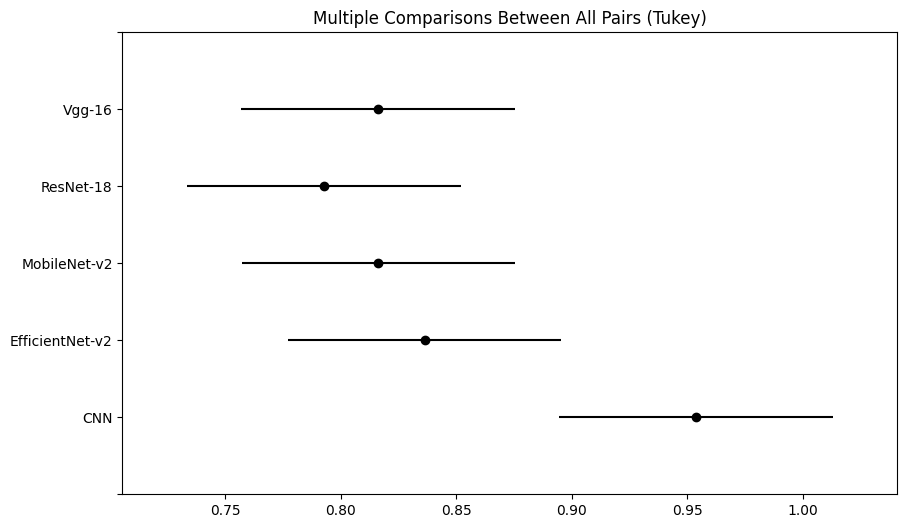

In [3]:
import numpy as np
from scipy.stats import kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

# Realizar el test de Kruskal-Wallis
stat, p = kruskal(*data)
print("Test de Kruskal-Wallis:")
print(f"Estadístico de prueba: {stat}")
print(f"Valor p: {p}")
print()

# Realizar comparaciones post hoc utilizando la prueba de Tukey HSD
if p > 0.05:
    print("No se encontraron diferencias significativas entre los grupos. No es necesario realizar comparaciones post hoc.")
else:
    print("Realizando comparaciones post hoc utilizando la prueba de Tukey HSD:")
    posthoc_results = pairwise_tukeyhsd(np.concatenate(data), np.repeat(model_names, [len(d) for d in data]))
    print(posthoc_results)

    # Representación de los resultados
    posthoc_results.plot_simultaneous()
    plt.show()